Beer3 Positive Results
==============

1. LDA
-------

In [1]:
from lda_for_fragments import run_lda
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

In [2]:
n_topics = 50
n_samples = 500

**Features.**

For each document (i.e. parent peak), we have the following bag-of-words of features:
1. The discretised m/z value of its fragment peaks. For the value, we use the the logged intensity of the fragment peak, scaled from 0..100.
2. The discretised m/z value of neutral losses. For the value, we use the log intensity of the neutral loss peak, scaled from 0..100.
3. The discretised m/z differences between each pair of fragment peaks. For the value, we use the count of occurences of such m/z differences (e.g. 1, 2, 3), scaled from 0..100.

A lot of heuristics (thresholding, etc). were used when extracting these features from the mzXML files. See extractFeatures.R for more details.

The discretisation step we use to prerocess the input before passing it to the model seems quite dodgy now. We see in the histogram below the tall bars at bin=10, 20 and 30. These come from (3) above. The rest of the histogram bins come from (1) and (2).

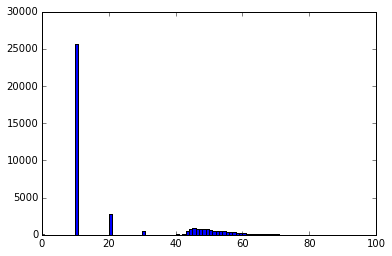

Data shape (856, 3758)
Fitting model...
DONE!
Writing topics to results/beer3_pos/beer3_pos_topics.csv
Writing fragments x topics to results/beer3_pos/beer3_pos_all.csv
Writing topic docs to results/beer3_pos/beer3_pos_docs.csv


In [3]:
ms1 = pd.read_csv('input/Beer_3_T10_POS_ms1.csv', index_col=0)
ms2 = pd.read_csv('input/Beer_3_T10_POS_ms2.csv', index_col=0)
data, model, topicdf, docdf = run_lda('beer3_pos', 
                         'input/Beer_3_T10_POS_fragments.csv', 
                         'input/Beer_3_T10_POS_losses.csv', 
                         'input/Beer_3_T10_POS_mzdiffs.csv', 
                         n_topics, n_samples)

LDA results can be found in the three files generated above.

2. PCA
-------

Here we use PCA to project the topics to lower-dimensional space for visualisation purposes. First ensure the variables are scaled.

In [4]:
from sklearn import preprocessing
# df = docdf # topics x documents matrix
df = topicdf.transpose() # topics x words matrix
print df.shape

# normalise and scale the variables
scaled_mat = preprocessing.scale(df, axis=0)
# print scaled_mat.mean(axis=0)
# print scaled_mat.std(axis=0)

(50, 3758)


Then run PCA

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(scaled_mat)
X_r = pca.transform(scaled_mat)

But the explained variances by the first two principal components are too low ..??

In [6]:
print X_r.shape
print('explained variance by the first two principal components: %s' % str(pca.explained_variance_ratio_))

(50, 2)
explained variance by the first two principal components: [ 0.05593861  0.03847196]


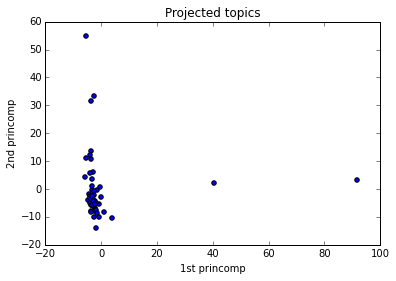

In [7]:
plt.figure()
plt.scatter(X_r[:, 0], X_r[:, 1])
plt.xlabel('1st princomp')
plt.ylabel('2nd princomp')
plt.title('Projected topics')

3. Network
------------

We can try to put the topics on a network too.

In [8]:
df = topicdf.transpose()
print df.shape # df is the topic x terms matrix

(50, 3758)


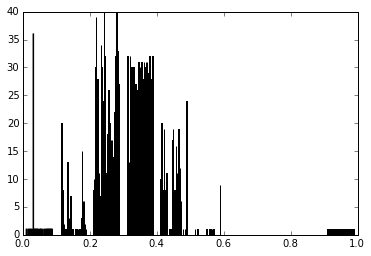

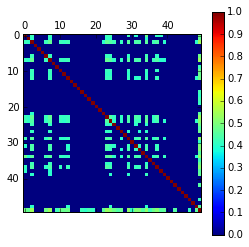

In [9]:
# create adjacency matrix A

# first compute euclidean distance between the topics
from scipy.spatial.distance import cdist
A = cdist(scaled_mat, scaled_mat, 'euclidean')

# crudely convert to similarities
maxval = A.max()
A = 1-(A/maxval)
plt.hist(A)

# set a threshold of 0.3 for the similarity values for the network graph
for i in xrange(A.shape[0]):
    for j in xrange(A.shape[1]):
        if A[i, j] < 0.40:
            A[i, j] = 0

plt.matshow(A)
plt.colorbar()
plt.show()

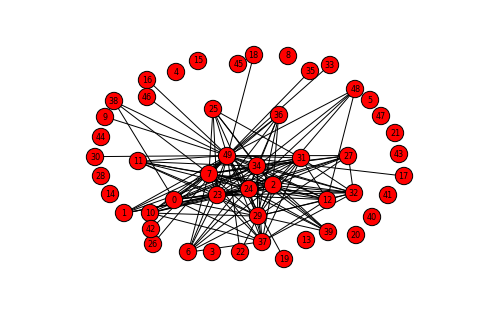

In [10]:
import networkx as nx
from networkx.readwrite import json_graph
dt = [('len', float)]
A = A.view(dt)
G = nx.from_numpy_matrix(A)
pos = nx.spring_layout(G, k=0.3, iterations=20)
nx.draw(G,pos,font_size=8)

Hard to conclude antyhing .... It seems like there are some 'core' topics that the rest are connected to (in the high-dimensional Euclidean space). However, take note the network graph above can be misleading due to the thresholding values used.

4. Topics
-----------

Visualise the document-topic distributions

(856, 50)


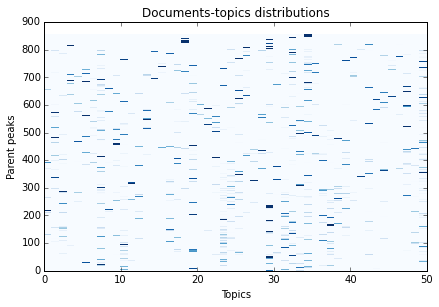

In [11]:
df = docdf.transpose()
print df.shape
plt.pcolor(df, norm=None, cmap='Blues')
plt.tight_layout()
plt.xlabel('Topics')
plt.ylabel('Parent peaks')
plt.title('Documents-topics distributions')
plt.show()

For every topic, check the words inside.

Topic 0

Parent peaks

     peakID	mz		rt		int		prob
1    10520	180.08657	630.413		2.820e+06	0.987
2    10519	180.08661	668.607		4.039e+06	0.974
3    10517	180.08660	603.508		1.188e+07	0.705
4    7776 	180.08663	565.722		2.087e+06	0.693
5    10513	162.07608	720.791		1.220e+07	0.682
6    9326 	240.10764	688.576		3.093e+05	0.619
7    10308	163.06003	601.884		1.957e+06	0.575
8    9956 	198.09720	627.372		7.743e+06	0.530
9    10307	163.05996	668.607		2.790e+06	0.458

Fragments

1    fragment_69.03368 (0.025)
 peakID  MSnParentPeakID  mz        rt       intensity
 21179    7776            69.03378  567.553   59525.43
 23615    9956            69.03368  627.809   45944.01
 23897   10307            69.03368  660.930  101374.60
 23900   10308            69.03369  595.245   41454.12
 24316   10513            69.03375  715.230  112027.50
 24348   10517            69.03368  603.859  292149.00
 24379   10519            69.03371  661.067   23031.22
 24389   10520            69.03367  626.438   3765

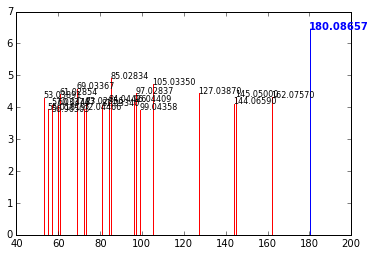

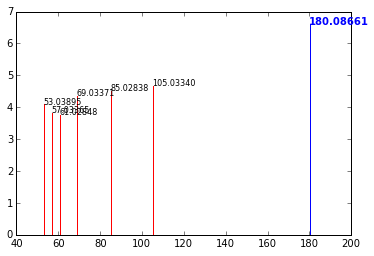

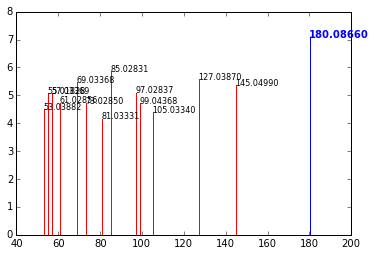

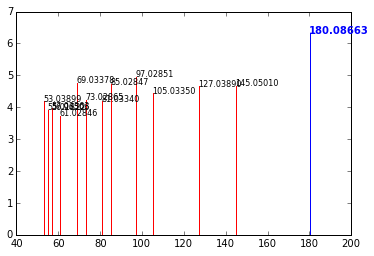

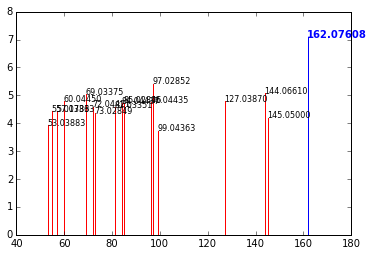

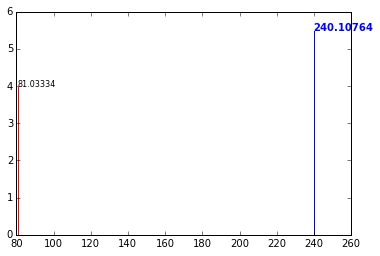

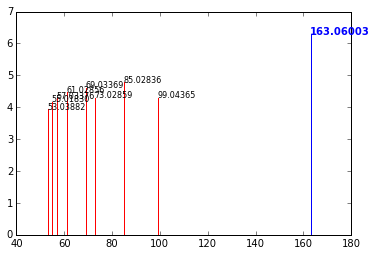

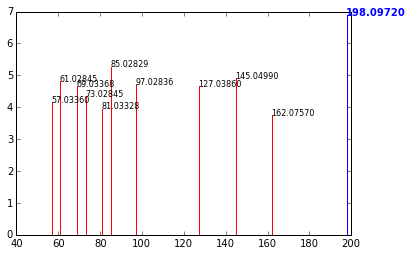

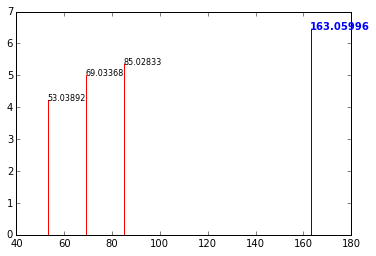

Topic 1

Parent peaks

     peakID	mz		rt		int		prob
1    6167 	265.05841	332.055		2.271e+06	0.988
2    6168 	265.05839	375.834		1.919e+06	0.988
3    4882 	301.11827	383.864		4.774e+06	0.985
4    10381	175.14411	842.825		1.179e+07	0.936
5    8957 	219.13393	670.770		1.612e+06	0.910
6    9201 	203.05260	694.864		1.542e+06	0.900
7    10411	189.15968	859.763		5.535e+07	0.805
8    8805 	351.21261	655.682		7.614e+05	0.777
9    8343 	277.13932	617.886		5.031e+06	0.540

Fragments

1    fragment_84.08071 (0.196)
 peakID  MSnParentPeakID  mz        rt       intensity  
 22030    8343            84.08069  624.605   200168.400
 22591    8805            84.08068  653.683   104528.000
 22914    8957            84.08067  667.654   271942.600
 23030    9201            84.08071  690.589     7434.092
 24003   10381            84.08070  847.162  1674367.000
 24050   10411            84.08076  861.865  8671687.000
2    fragment_56.04978 (0.068)
 peakID  MSnParentPeakID  mz        rt       intensity
 2203

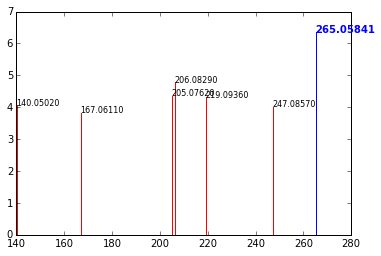

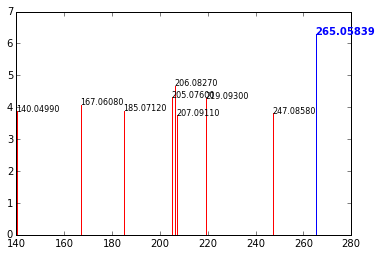

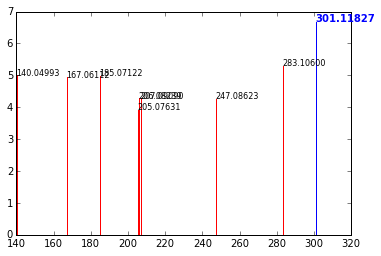

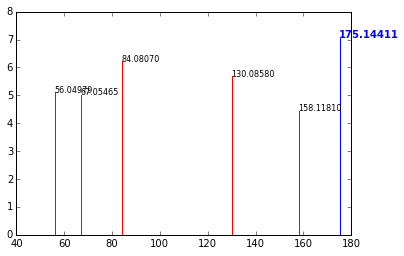

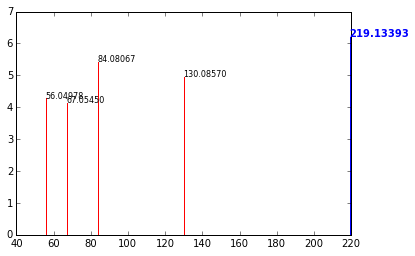

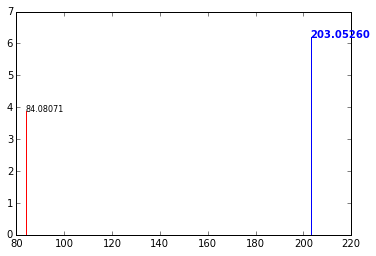

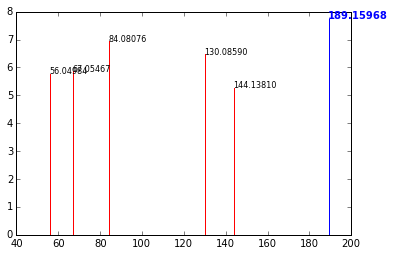

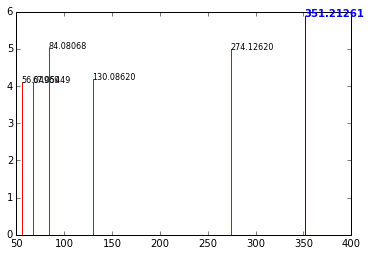

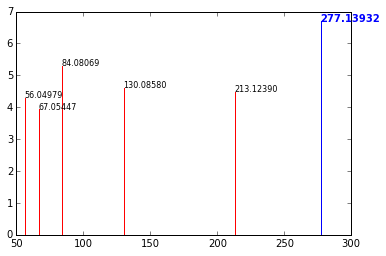

Topic 2

Parent peaks

     peakID	mz		rt		int		prob
1    6002 	201.05223	433.724		1.778e+06	0.981
2    5839 	134.08116	404.875		8.499e+06	0.965
3    5283 	243.09755	412.921		6.523e+06	0.836
4    5932 	148.09680	372.653		1.562e+06	0.790
5    9790 	184.07331	617.886		2.333e+07	0.711
6    6948 	300.12057	513.775		1.034e+06	0.665
7    7035 	126.06624	479.488		2.470e+07	0.656
8    7167 	218.10219	490.026		8.090e+05	0.650
9    8632 	335.09473	628.893		6.897e+05	0.647

Fragments

1    fragment_56.04978 (0.104)
 peakID  MSnParentPeakID  mz         rt       intensity    
 18117   5932             56.049785  394.670   39259.410156
 19752   6948             56.049700  514.460    7613.390000
 19948   7035             56.049880  482.727  183733.500000
 23508   9790             56.049790  633.858   30457.050000
2    fragment_98.98387 (0.057)
 peakID  MSnParentPeakID  mz         rt       intensity   
 18217   6002             98.983791  426.729  367432.90625
 19746   6948             98.983860  514.

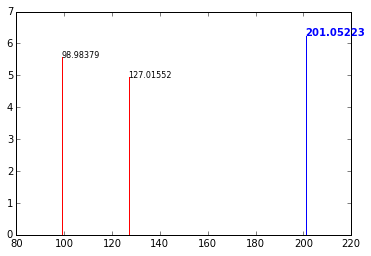

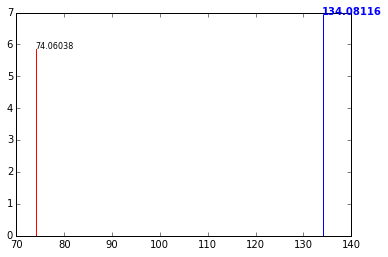

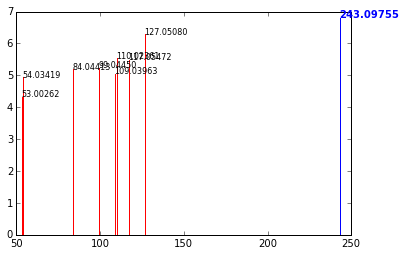

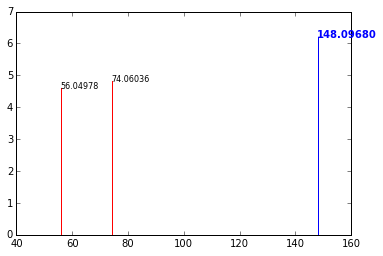

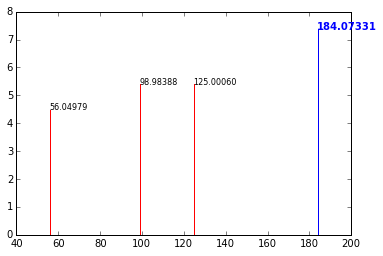

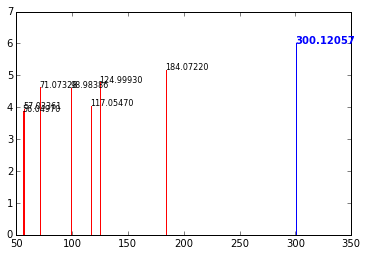

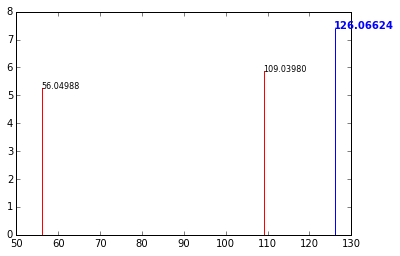

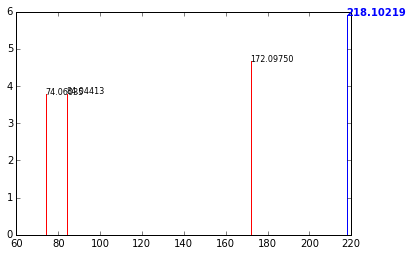

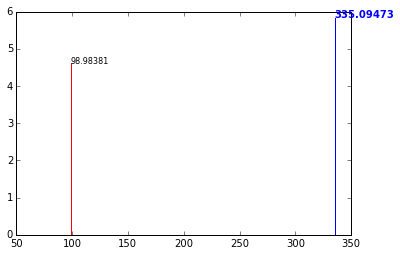

Topic 3

Parent peaks

     peakID	mz		rt		int		prob
1    8582 	546.68913	611.450		1.029e+06	0.997
2    8577 	374.79834	645.990		1.258e+06	0.992
3    8581 	546.68903	636.638		1.312e+06	0.991
4    8082 	374.79827	597.184		2.910e+06	0.983
5    8869 	364.79478	611.450		2.669e+06	0.970
6    8564 	561.69431	619.436		8.725e+05	0.931
7    6523 	469.20801	494.747		1.176e+06	0.908
8    5524 	298.09687	412.921		3.007e+07	0.877
9    8576 	374.79834	622.592		5.219e+06	0.709

Fragments

1    fragment_136.06241 (0.058)
 peakID  MSnParentPeakID  mz          rt       intensity  
 17311   5524             136.062408  406.948  902816.6875
 21785   8082             136.062400  590.594  211645.4000
 22243   8564             136.062400  596.377  284565.7000
 22282   8576             136.062600  615.519  340990.1000
 22303   8577             136.062400  649.698  159527.5000
 22315   8581             136.062400  631.382  179770.1000
 22323   8582             136.062500  609.282  201043.4000
 22710   8869    

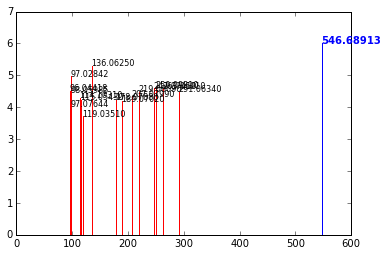

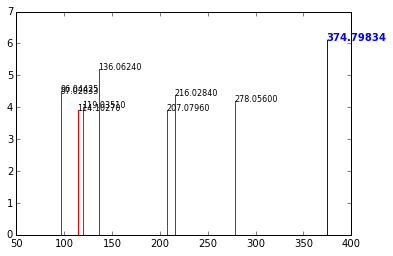

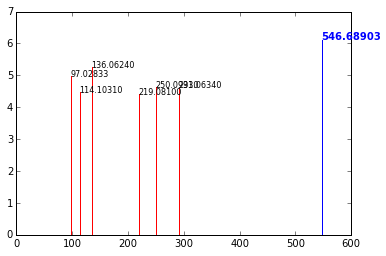

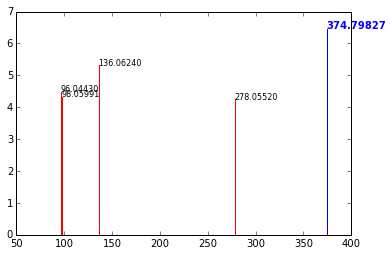

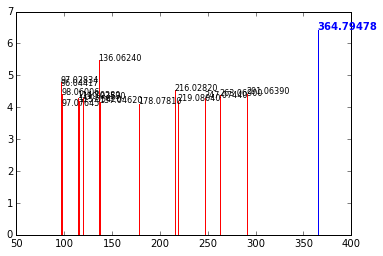

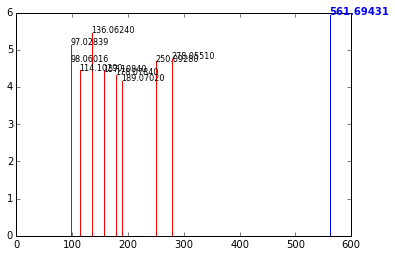

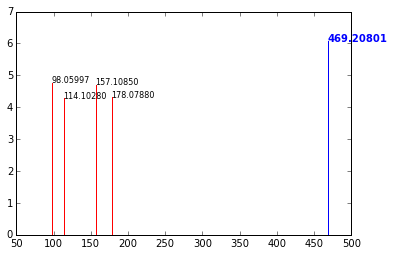

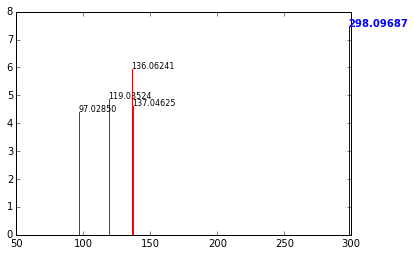

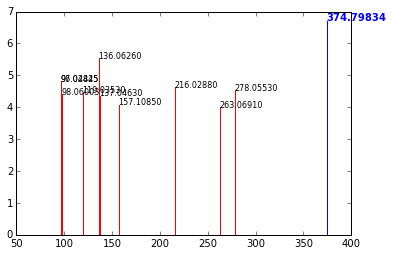

Topic 4

Parent peaks

     peakID	mz		rt		int		prob
1    10793	260.14908	955.832		3.927e+05	0.854
2    7168 	218.10224	518.554		8.733e+05	0.815
3    5002 	245.16483	409.811		1.280e+06	0.805
4    10792	260.14913	972.508		5.080e+05	0.801
5    10237	260.14913	857.431		4.439e+05	0.748
6    8514 	259.11322	605.017		9.520e+07	0.739
7    6512 	252.08650	499.470		8.493e+05	0.501
8    5592 	230.04813	440.293		2.099e+06	0.467
9    8415 	315.50208	633.586		6.399e+05	0.379

Fragments

1    fragment_70.06514 (0.026)
 peakID  MSnParentPeakID  mz         rt       intensity    
 16849    5002            70.065167  410.761   36727.355469
 17404    5592            70.065202  444.353   36351.941406
 22199    8415            70.065220  636.167  112502.900000
 23858   10237            70.065260  853.189   15215.790000
 24816   10792            70.065080  970.527   18890.000000
 24832   10793            70.065080  954.588   13447.680000
2    fragment_74.05986 (0.026)
 peakID  MSnParentPeakID  mz       rt  

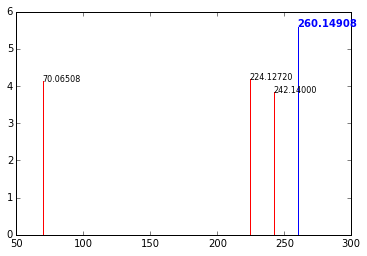

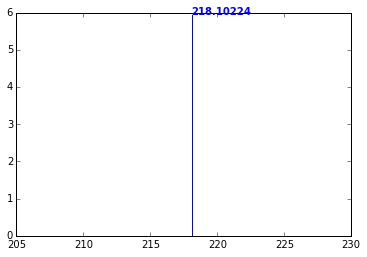

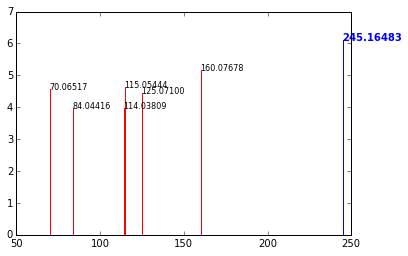

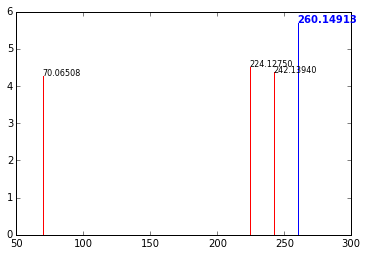

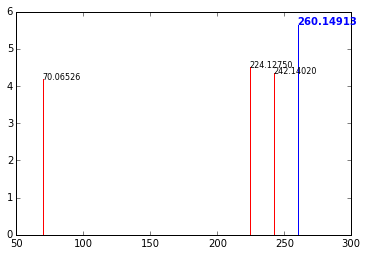

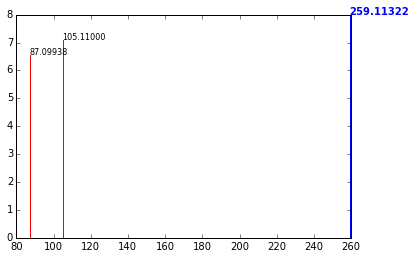

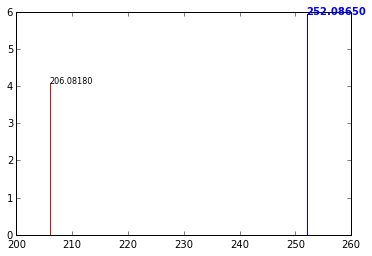

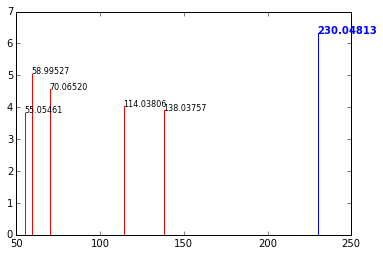

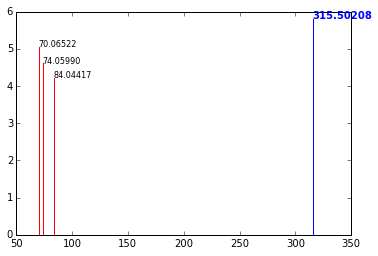

Topic 5

Parent peaks

     peakID	mz		rt		int		prob
1    703  	431.27921	203.748		9.602e+05	0.994
2    1053 	295.15397	205.410		3.533e+06	0.994
3    1663 	333.20596	207.039		4.866e+06	0.994
4    945  	417.26345	203.748		2.925e+06	0.993
5    2435 	265.10696	228.159		4.362e+05	0.991
6    735  	435.12384	213.692		6.674e+05	0.977
7    2600 	281.13820	205.410		3.306e+06	0.945
8    590  	449.23550	205.410		5.878e+05	0.919
9    977  	408.27431	207.039		8.984e+06	0.904

Fragments

1    fragment_69.07013 (0.041)
 peakID  MSnParentPeakID  mz         rt       intensity    
 12917    590             69.070097  205.005    9306.687500
 12998    703             69.070072  200.217   11291.631836
 13030    735             69.070117  211.763    9196.691406
 13177    945             69.070059  199.065   13670.776367
 13680   1663             69.070176  202.788  151470.703125
2    fragment_91.05413 (0.027)
 peakID  MSnParentPeakID  mz         rt       intensity   
 12914    590             91.054314  205

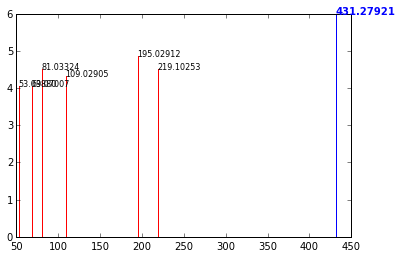

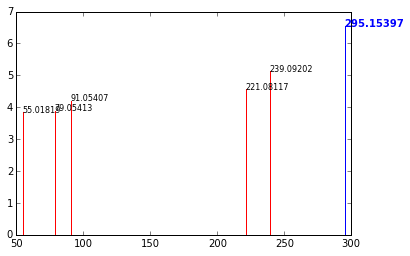

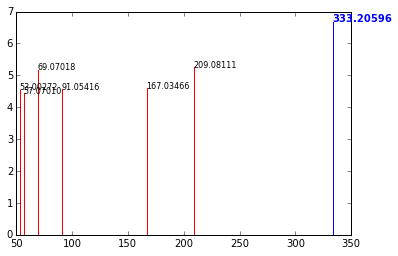

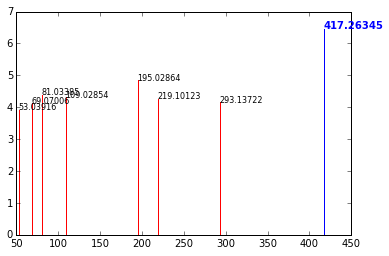

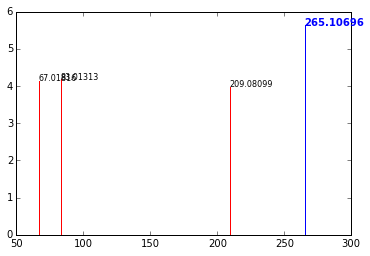

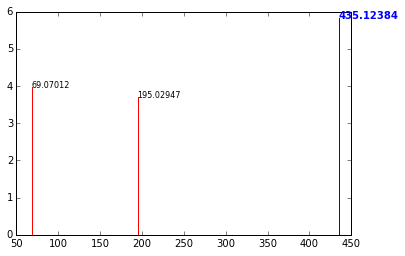

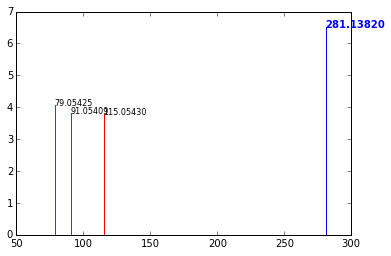

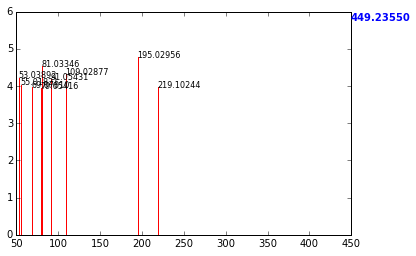

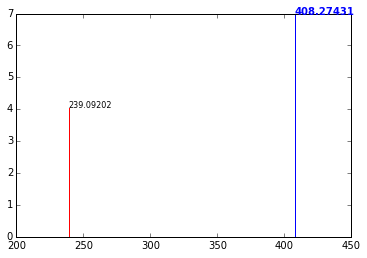

Topic 6

Parent peaks

     peakID	mz		rt		int		prob
1    8068 	286.11303	597.184		2.129e+06	0.938
2    5362 	282.11956	358.105		1.578e+06	0.935
3    5964 	260.11281	422.465		2.050e+06	0.648
4    8444 	205.06826	614.695		6.735e+07	0.618
5    6824 	529.17571	513.775		1.126e+06	0.524
6    5360 	282.11960	412.921		1.886e+07	0.517
7    10153	236.14916	864.146		3.279e+05	0.475
8    6051 	320.13405	460.808		4.898e+06	0.405
9    6969 	763.28442	515.409		1.445e+06	0.380

Fragments

1    fragment_69.03368 (0.036)
 peakID  MSnParentPeakID  mz         rt       intensity   
 17153   5360             69.033726  421.109  38013.769531
 17183   5362             69.033697  357.210  42572.511719
 18286   6051             69.033604  455.346  14696.692383
2    fragment_57.03369 (0.027)
 peakID  MSnParentPeakID  mz         rt       intensity   
 17155   5360             57.033665  421.109  30924.328125
 17189   5362             57.033606  357.210  11454.097656
 21746   8068             57.033720  591.773  

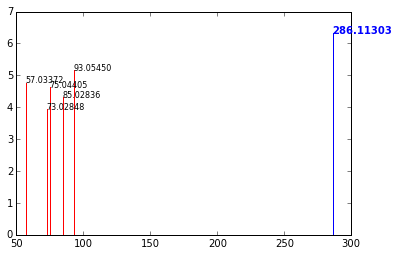

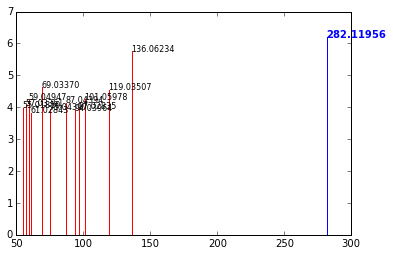

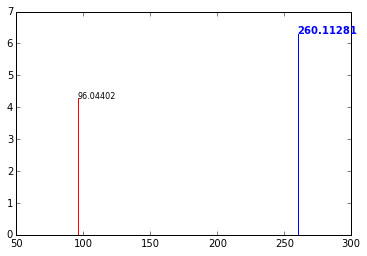

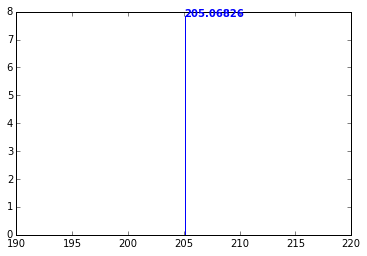

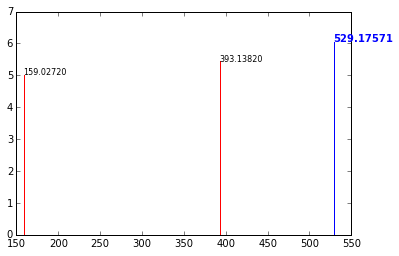

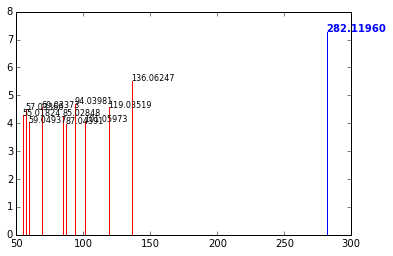

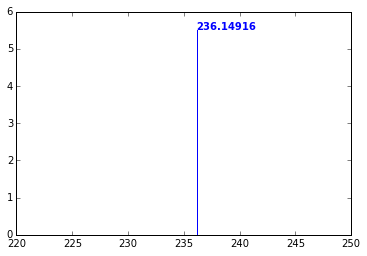

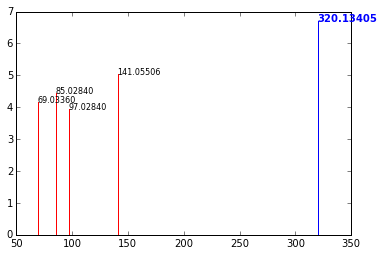

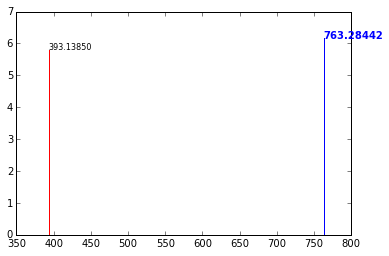

Topic 7

Parent peaks

     peakID	mz		rt		int		prob
1    12207	104.10696	988.951		1.220e+07	0.973
2    10539	204.14012	929.629		5.989e+05	0.948
3    6429 	366.07940	493.109		6.089e+05	0.948
4    800  	378.26370	205.410		1.458e+06	0.900
5    3503 	553.36919	276.253		1.080e+06	0.896
6    8086 	794.29776	606.606		6.344e+05	0.849
7    12209	104.10696	1012.390		4.703e+06	0.784
8    6522 	318.09499	501.043		1.132e+06	0.766
9    3421 	259.20147	251.436		2.108e+06	0.758

Fragments

1    fragment_86.09652 (0.223)
 peakID  MSnParentPeakID  mz         rt       intensity   
 15432   3421             86.096431  261.729  84439.757812
 15569   3503             86.096483  279.908   5118.236328
 19222   6522             86.096490  498.800  32292.030000
 21792   8086             86.096590  606.209  87597.330000
2    fragment_69.07013 (0.109)
 peakID  MSnParentPeakID  mz         rt       intensity   
 13085    800             69.070079  203.485   7062.980469
 15436   3421             69.070036  261.729 

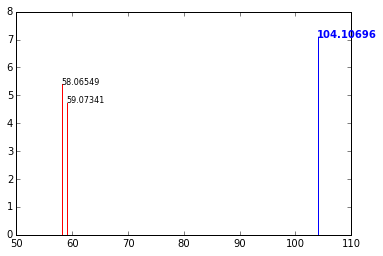

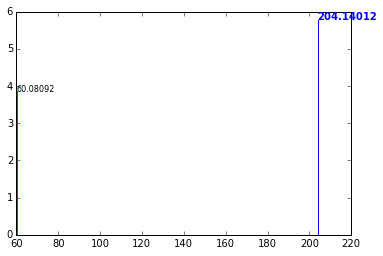

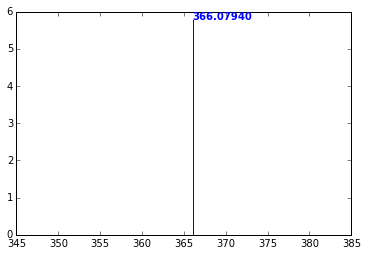

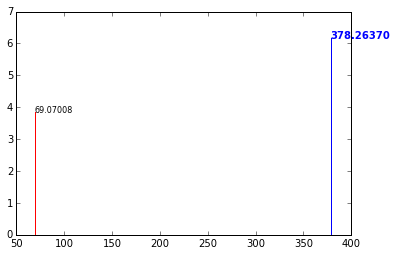

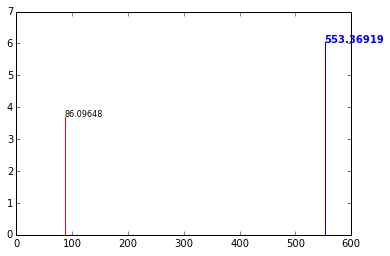

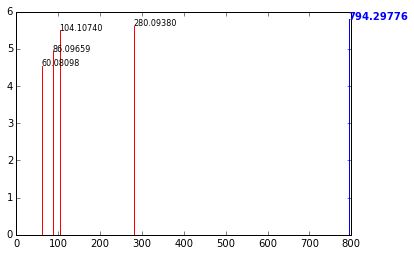

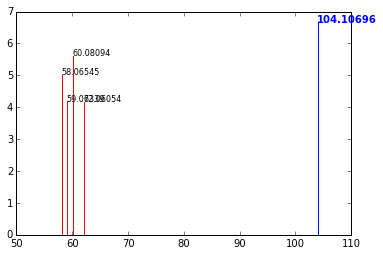

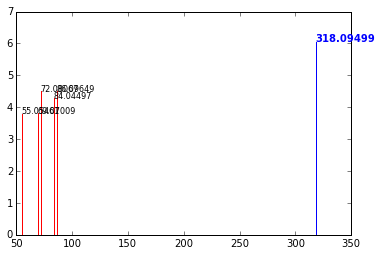

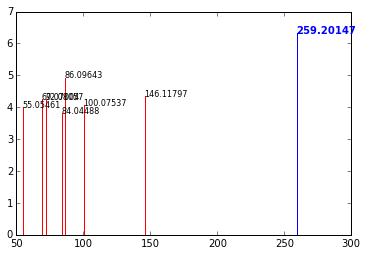

Topic 8

Parent peaks

     peakID	mz		rt		int		prob
1    6055 	342.15476	304.187		3.516e+05	0.819
2    6058 	342.15481	332.055		4.321e+05	0.709
3    5005 	303.13403	414.504		4.038e+06	0.692
4    6056 	342.15480	348.358		5.443e+05	0.622
5    7193 	180.08662	465.402		4.349e+06	0.604
6    6783 	180.10183	438.661		5.660e+05	0.594
7    10464	251.16003	636.638		9.815e+05	0.464
8    4732 	196.13323	274.685		2.531e+06	0.419
9    9795 	294.16420	756.510		8.001e+05	0.416

Fragments

1    fragment_134.09682 (0.024)
 peakID  MSnParentPeakID  mz        rt       intensity
 19522   6783             134.0968  436.917   9177.987
 20404   7193             134.0969  473.982  20610.620
2    fragment_162.09143 (0.020)
 peakID  MSnParentPeakID  mz        rt       intensity
 19516   6783             162.0912  436.917  22626.12 
 20406   7193             162.0914  473.982  16015.79 
3    fragment_276.12192 (0.017)
 peakID  MSnParentPeakID  mz        rt       intensity
 18363   6055             276.1212  301.

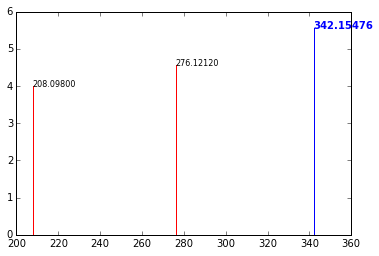

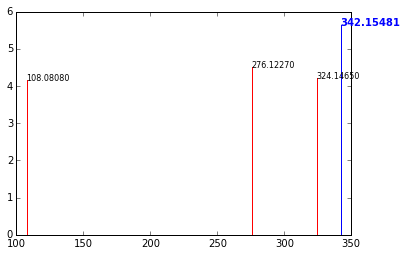

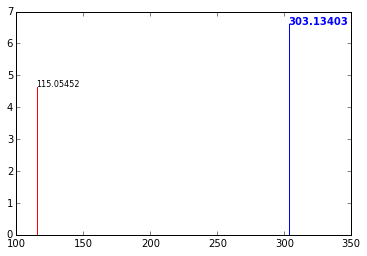

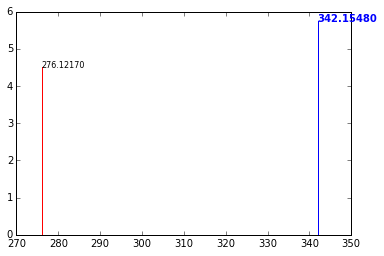

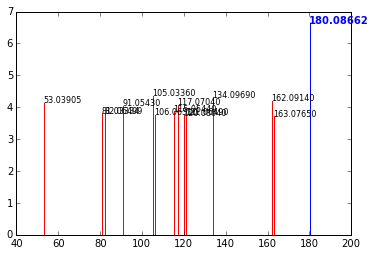

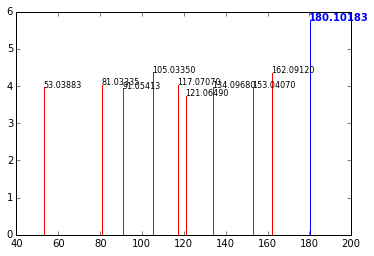

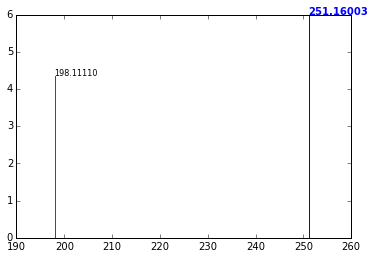

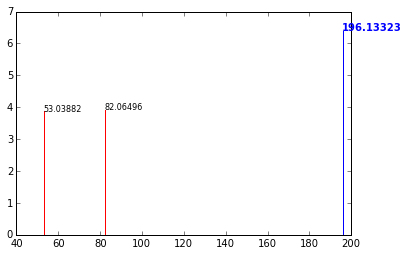

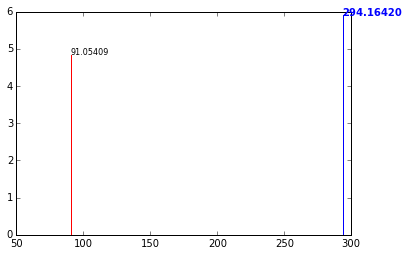

Topic 9

Parent peaks

     peakID	mz		rt		int		prob
1    6345 	259.09236	482.456		2.661e+07	0.991
2    7082 	258.10841	473.204		8.552e+06	0.972
3    1430 	301.21216	238.237		1.911e+06	0.886
4    6954 	316.16158	513.775		1.136e+06	0.834
5    6654 	315.12980	504.302		8.902e+05	0.780
6    8919 	237.09024	674.743		3.756e+05	0.763
7    7785 	259.12881	559.317		1.632e+06	0.747
8    8617 	147.07636	630.413		2.536e+07	0.738
9    6723 	261.14447	459.215		6.398e+05	0.713

Fragments

1    fragment_84.04422 (0.065)
 peakID  MSnParentPeakID  mz         rt       intensity 
 13498   1430             84.044227  234.193   172442.75
 18804   6345             84.044170  478.187  4347238.00
 19402   6723             84.044240  456.037    52880.60
 19768   6954             84.044150  511.353   410019.40
 20052   7082             84.044130  467.468   677000.90
 21261   7785             84.044160  564.503   470839.80
 22400   8617             84.044150  623.277   571146.30
2    fragment_56.04978 (0.056)
 pe

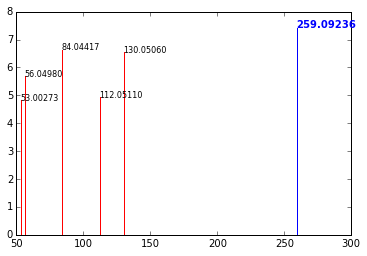

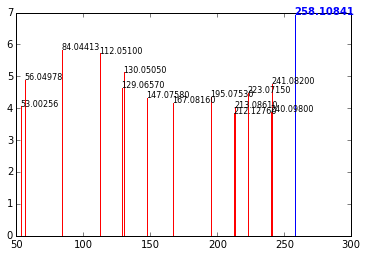

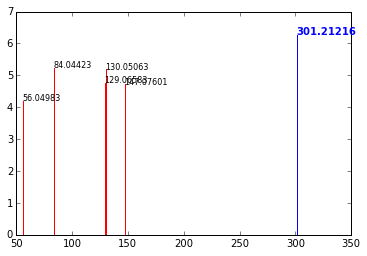

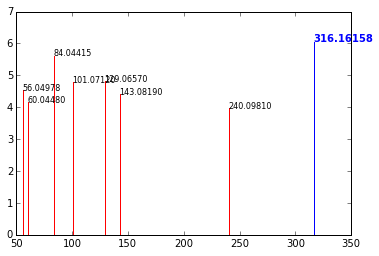

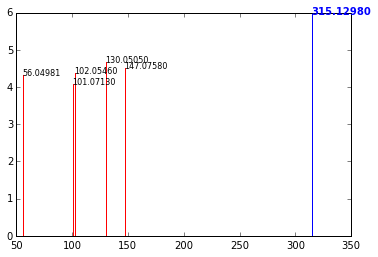

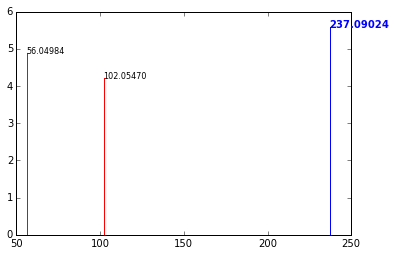

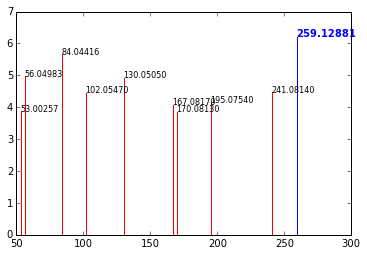

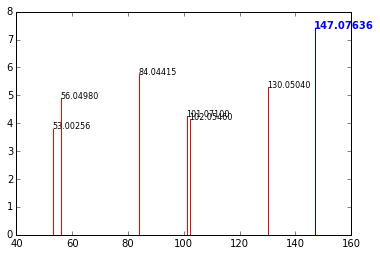

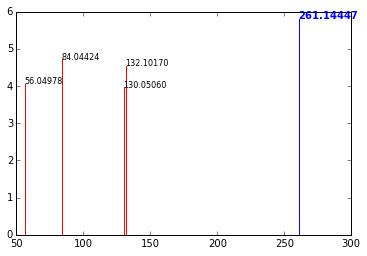

Topic 10

Parent peaks

     peakID	mz		rt		int		prob
1    7179 	137.04578	512.170		5.750e+07	0.994
2    7216 	136.06172	496.313		5.973e+08	0.989
3    7180 	137.04582	438.661		6.213e+06	0.985
4    8971 	446.15175	677.129		7.945e+05	0.935
5    7181 	137.04581	482.456		4.707e+07	0.932
6    7704 	112.05052	552.842		1.928e+07	0.902
7    10543	319.14979	943.404		4.451e+05	0.774
8    7963 	267.11969	585.875		1.540e+07	0.703
9    12382	131.12911	905.222		1.268e+07	0.634

Fragments

1    fragment_55.02948 (0.046)
 peakID  MSnParentPeakID  mz        rt       intensity
 20354    7179            55.02951  515.680  534164.40
 20360    7180            55.02952  443.707   40000.85
 20364    7181            55.02950  484.044  749151.60
 21477    7963            55.02958  592.683   24610.16
 25170   12382            55.02945  899.306   30287.15
2    fragment_82.04028 (0.023)
 peakID  MSnParentPeakID  mz        rt       intensity
 20355   7179             82.04027  515.680  505484.20
 20362   7180     

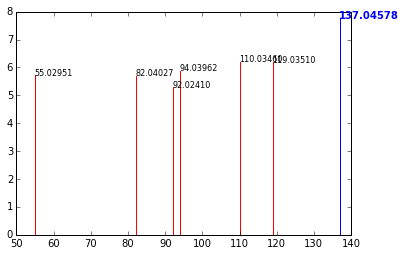

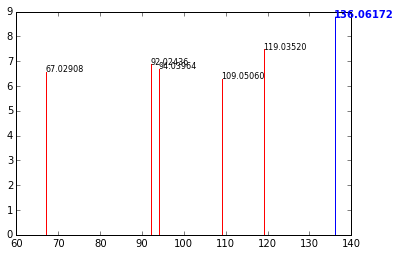

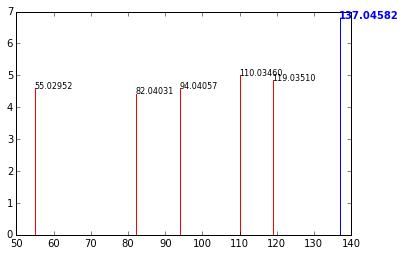

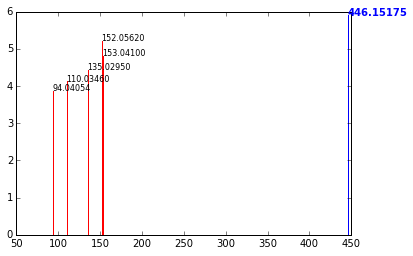

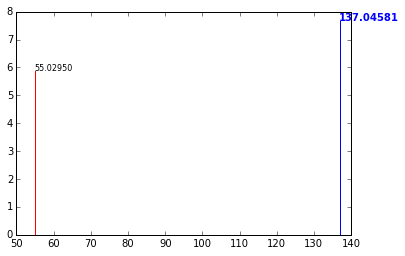

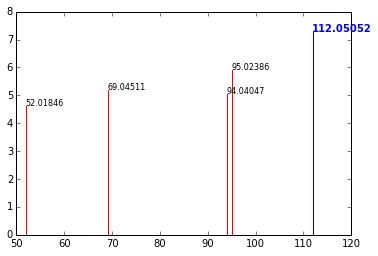

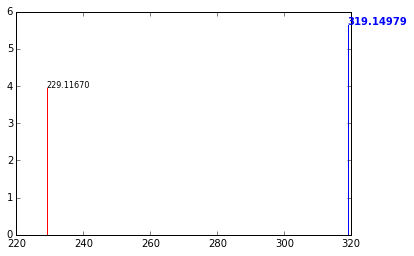

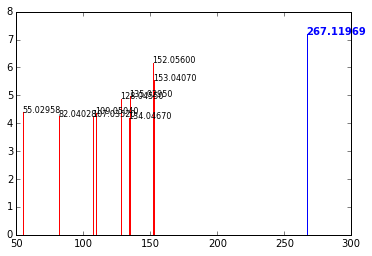

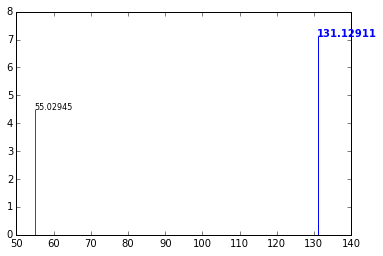

Topic 11

Parent peaks

     peakID	mz		rt		int		prob
1    7778 	212.09513	557.680		7.742e+06	0.996
2    10527	212.09507	649.151		3.917e+06	0.996
3    10524	212.09509	739.434		5.293e+06	0.996
4    10526	212.09505	593.907		5.924e+06	0.994
5    7780 	212.09512	515.409		5.867e+06	0.992
6    5962 	250.05088	462.438		6.961e+05	0.974
7    3749 	250.05156	359.749		5.252e+05	0.951
8    7779 	212.09533	456.158		3.811e+06	0.883
9    10692	189.13445	925.292		4.621e+06	0.446

Fragments

1    fragment_88.07588 (0.041)
 peakID  MSnParentPeakID  mz        rt       intensity
 21218    7778            88.07594  553.205  56838.83 
 21230    7779            88.07592  456.884  25458.70 
 21253    7780            88.07590  522.024  30746.19 
 24470   10524            88.07590  744.766  36420.23 
 24494   10526            88.07590  600.511  29177.66 
 24504   10527            88.07595  647.979  26853.08 
2    fragment_58.06553 (0.034)
 peakID  MSnParentPeakID  mz        rt       intensity
 21214    7778    

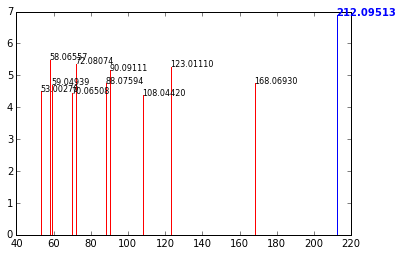

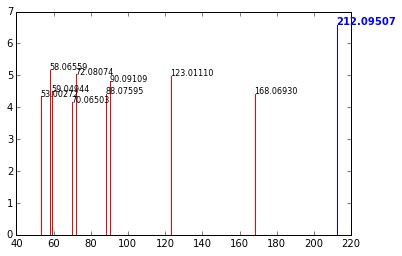

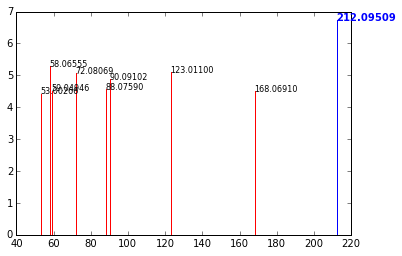

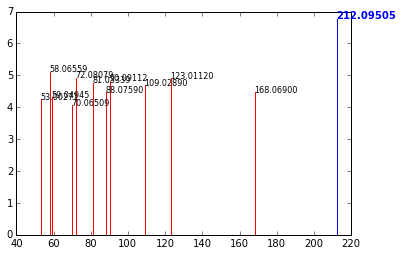

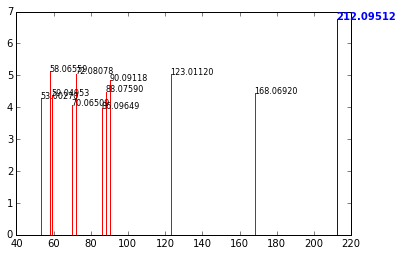

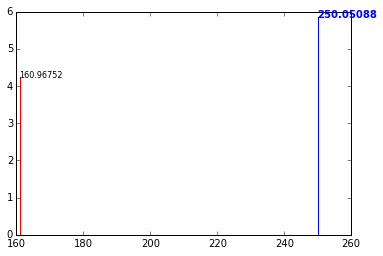

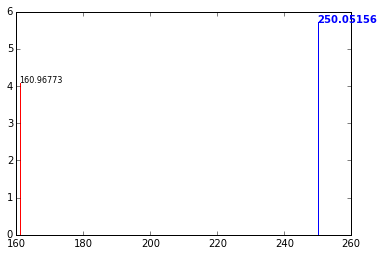

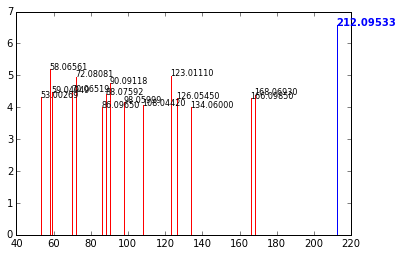

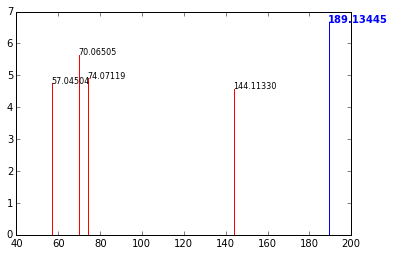

Topic 12

Parent peaks

     peakID	mz		rt		int		prob
1    6041 	237.08692	468.549		2.044e+06	0.995
2    6387 	240.12291	382.238		7.140e+05	0.803
3    7983 	143.08145	582.999		6.445e+06	0.781
4    3995 	277.11822	290.983		7.819e+05	0.757
5    7117 	166.08629	290.983		6.524e+05	0.701
6    6092 	194.08106	471.593		6.886e+05	0.676
7    6044 	237.08689	443.301		9.559e+05	0.676
8    5024 	194.08116	372.653		2.269e+06	0.618
9    7727 	205.09718	554.431		3.592e+07	0.498

Fragments

1    fragment_118.06547 (0.025)
 peakID  MSnParentPeakID  mz          rt       intensity     
 16929   5024             118.065304  373.337    10445.157227
 18246   6041             118.065441  460.133    48399.578125
 18271   6044             118.065536  442.767    23708.974609
 21053   7727             118.065500  557.952  2201909.000000
2    fragment_120.08041 (0.024)
 peakID  MSnParentPeakID  mz          rt       intensity    
 15853   3995             120.080354  291.669  236747.234375
 16920   5024           

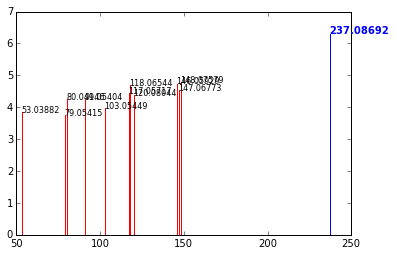

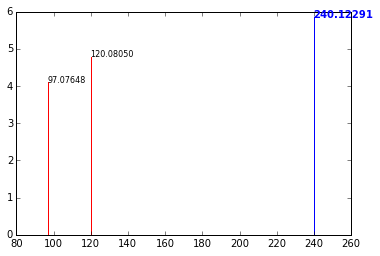

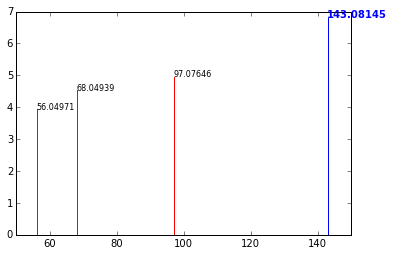

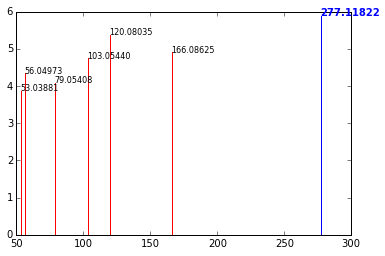

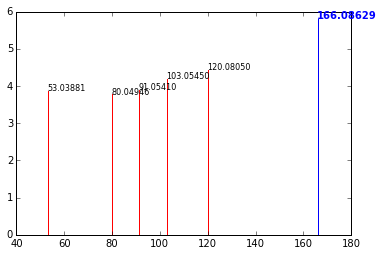

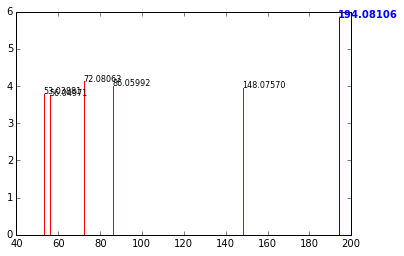

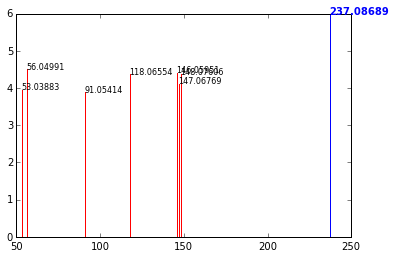

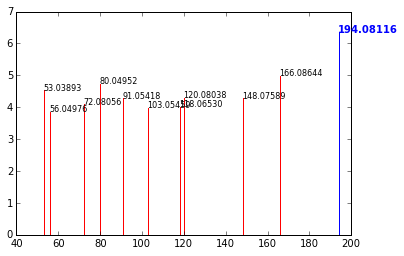

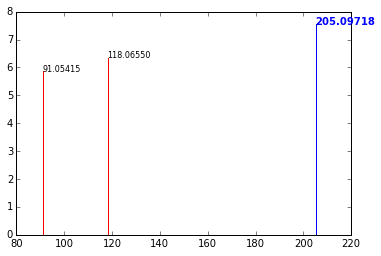

Topic 13

Parent peaks

     peakID	mz		rt		int		prob
1    10531	291.16316	593.907		4.721e+06	0.998
2    10532	291.16317	729.738		5.737e+06	0.989
3    10467	306.16862	636.638		2.560e+06	0.979
4    6414 	291.08388	465.402		2.522e+07	0.935
5    10022	363.18438	791.985		1.081e+06	0.918
6    10528	291.16318	632.053		6.842e+06	0.915
7    10521	372.18967	636.638		2.905e+06	0.833
8    10504	276.15782	595.502		9.881e+05	0.814
9    10503	276.15795	636.638		1.591e+06	0.768

Fragments

1    fragment_55.05468 (0.022)
 peakID  MSnParentPeakID  mz        rt       intensity
 19004    6414            55.05463  464.416   23436.44
 23724   10022            55.05479  798.207   25147.07
 24126   10467            55.05471  639.006   55585.34
 24222   10503            55.05475  633.998   30902.27
 24252   10504            55.05478  602.709   11747.62
 24429   10521            55.05465  652.836   46639.52
 24515   10528            55.05473  643.487  129542.90
 24686   10531            55.05468  594.306   900

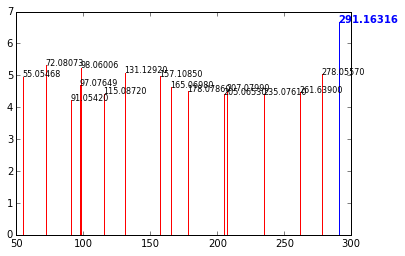

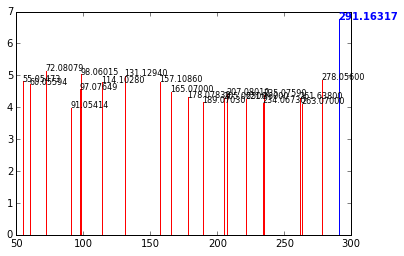

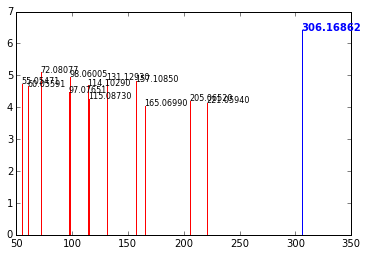

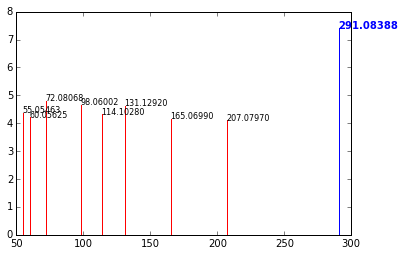

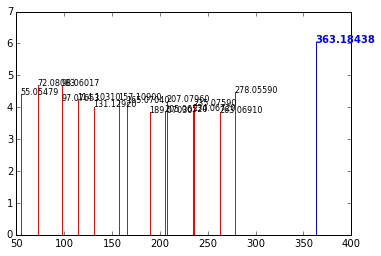

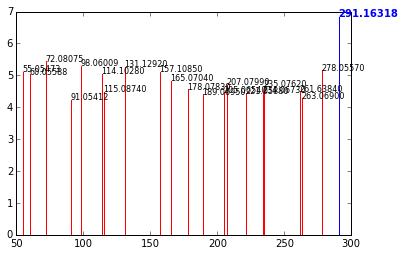

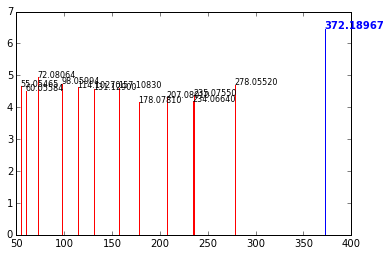

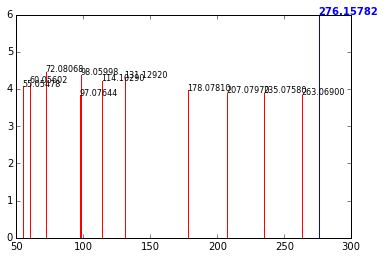

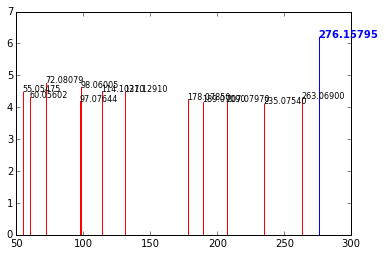

Topic 14

Parent peaks

     peakID	mz		rt		int		prob
1    5777 	310.12846	372.653		7.748e+05	0.809
2    6593 	490.19215	452.947		5.970e+05	0.790
3    6592 	490.19202	491.538		2.827e+06	0.732
4    4521 	222.11246	286.004		2.699e+06	0.679
5    7115 	166.08624	499.470		1.505e+07	0.505
6    7275 	344.13393	534.050		3.699e+06	0.380
7    1323 	292.19063	221.946		5.747e+05	0.341
8    2098 	293.13821	205.410		3.040e+06	0.306
9    6349 	328.13907	419.222		2.445e+07	0.304

Fragments

1    fragment_120.08041 (0.032)
 peakID  MSnParentPeakID  mz          rt       intensity     
 13377   1323             120.080319  220.990   169138.390625
 13948   2098             120.080408  218.204     9115.150391
 16410   4521             120.080296  286.324    11386.847656
 17991   5777             120.080462  370.349    43705.054688
 18811   6349             120.080300  440.567  1160733.000000
 19285   6592             120.080500  493.387   187073.800000
 19308   6593             120.080400  451.186    45437

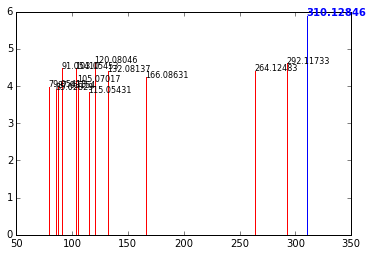

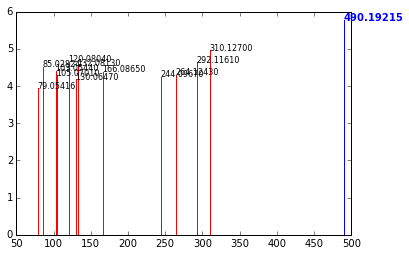

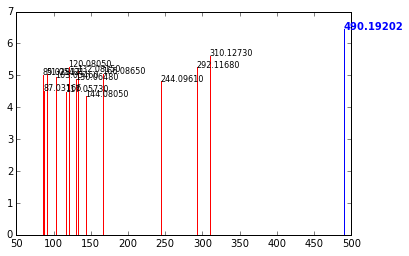

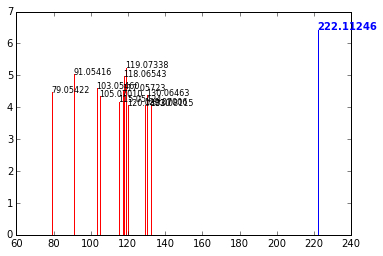

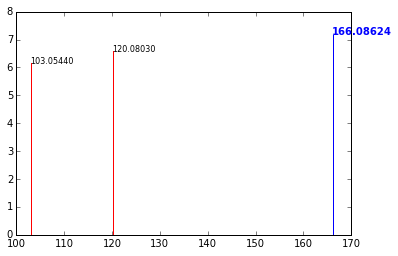

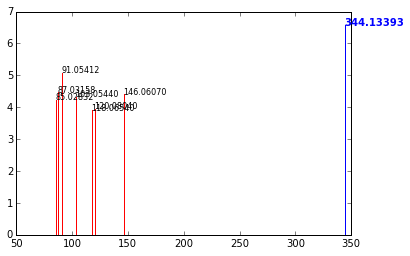

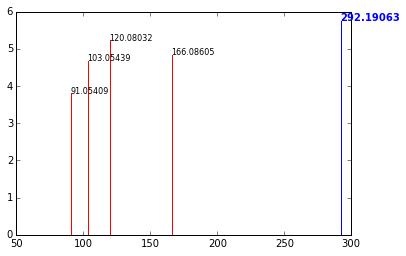

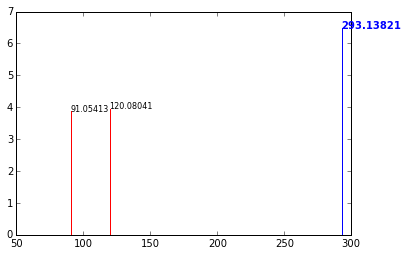

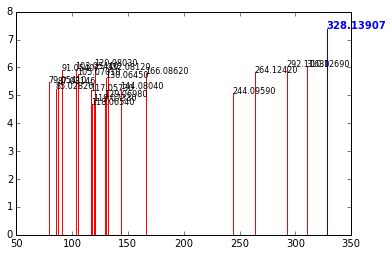

Topic 15

Parent peaks

     peakID	mz		rt		int		prob
1    11289	413.21290	1051.830		7.377e+05	0.990
2    11285	413.21294	1120.580		9.242e+05	0.973
3    693  	371.16205	207.039		5.925e+05	0.904
4    11286	413.21291	970.739		3.720e+05	0.875
5    10370	416.21393	905.841		4.464e+05	0.865
6    7625 	260.11272	543.289		1.364e+07	0.792
7    8845 	238.03790	668.607		4.814e+05	0.685
8    11226	254.16094	1153.580		3.362e+06	0.571
9    7869 	627.18648	587.564		9.447e+05	0.568

Fragments

1    fragment_167.1183 (0.026)
 peakID  MSnParentPeakID  mz        rt        intensity 
 23981   10370            167.1184   898.962    9830.064
 24992   11226            167.1183  1156.940  121141.500
 25052   11285            167.1183  1108.130   13708.970
 25091   11289            167.1179  1046.990   14042.610
2    fragment_84.08071 (0.022)
 peakID  MSnParentPeakID  mz        rt        intensity
 20826    7625            84.08064   553.343  45248.70 
 25046   11285            84.08082  1108.130  31328.49 
 2

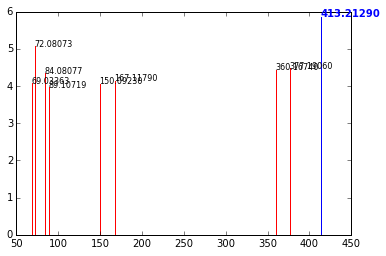

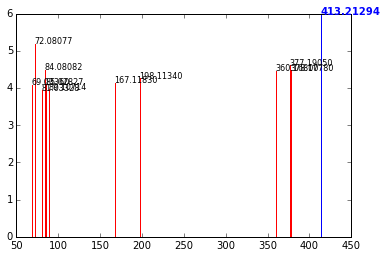

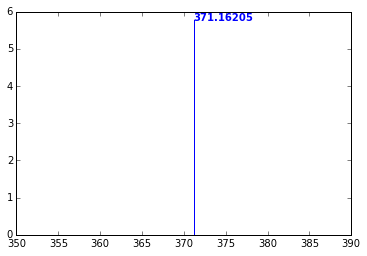

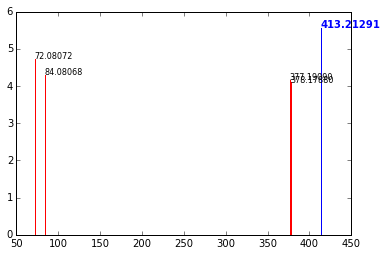

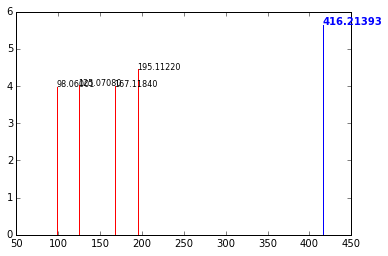

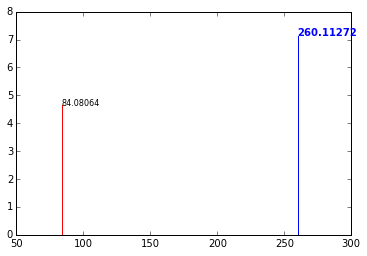

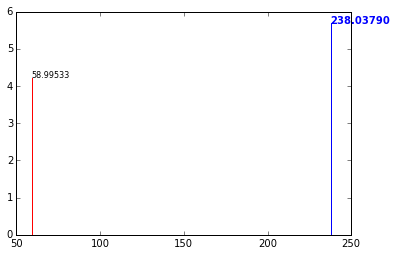

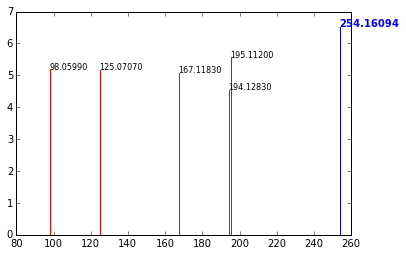

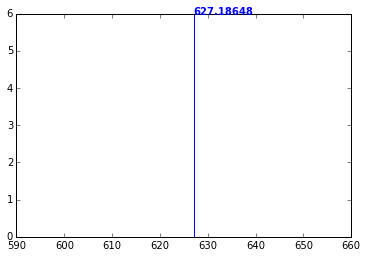

Topic 16

Parent peaks

     peakID	mz		rt		int		prob
1    5263 	264.07443	417.639		1.603e+07	0.977
2    10450	156.07680	752.158		1.105e+06	0.852
3    10449	156.07677	620.990		1.158e+08	0.830
4    6888 	143.08151	501.043		7.521e+06	0.811
5    6443 	483.22023	479.488		1.048e+06	0.810
6    10451	156.07680	668.607		3.111e+06	0.780
7    4052 	234.13352	302.542		2.976e+05	0.768
8    5734 	127.05023	414.504		2.761e+07	0.762
9    6243 	153.06585	425.682		8.899e+05	0.711

Fragments

1    fragment_83.06042 (0.085)
 peakID  MSnParentPeakID  mz        rt       intensity 
 19074    6443            83.06039  479.233    41134.05
 19686    6888            83.06034  507.891    13182.40
 24087   10449            83.06039  627.643  2166262.00
 24092   10450            83.06034  754.666    70002.38
 24103   10451            83.06040  659.351   209421.00
2    fragment_95.06076 (0.071)
 peakID  MSnParentPeakID  mz         rt       intensity    
 15895    4052            95.060779  312.466   18818.697266
 1

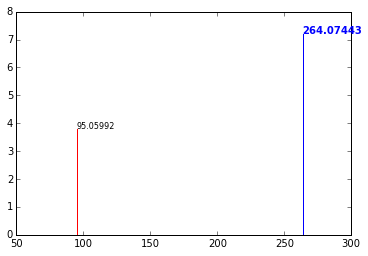

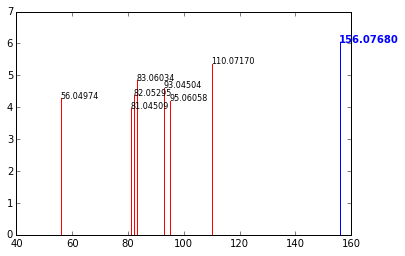

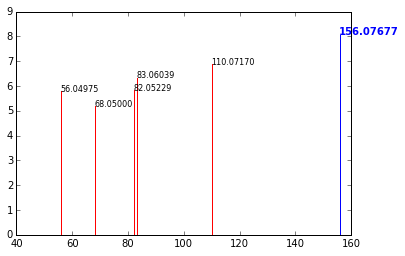

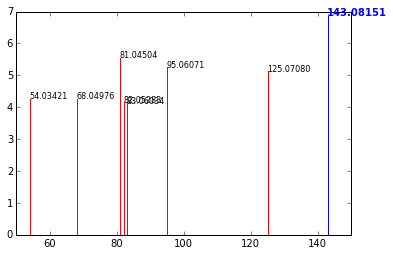

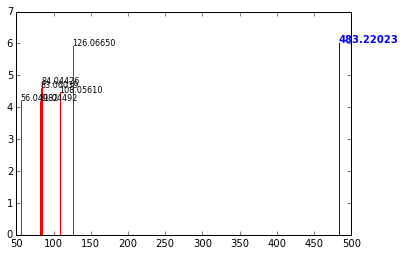

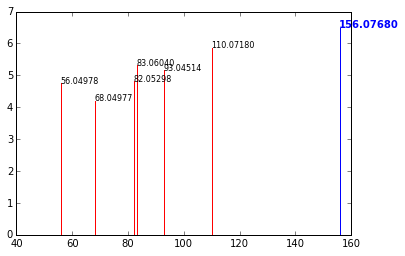

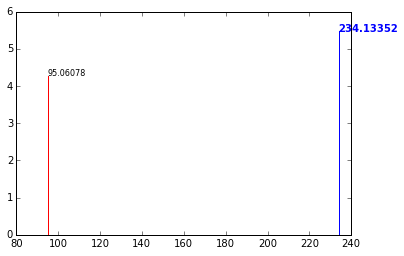

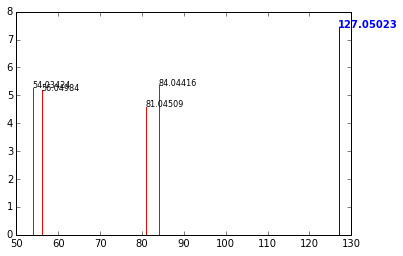

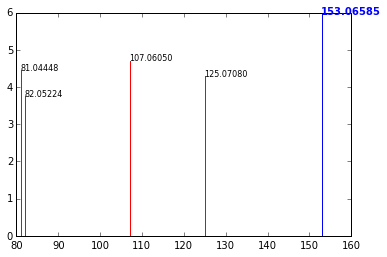

Topic 17

Parent peaks

     peakID	mz		rt		int		prob
1    10965	244.14033	1107.850		8.386e+05	0.857
2    10964	244.14032	1112.590		1.008e+06	0.856
3    10897	258.15598	1076.090		3.197e+05	0.836
4    8003 	239.15006	589.081		1.883e+06	0.819
5    11004	228.14548	1120.260		1.092e+06	0.794
6    5769 	239.13891	408.169		1.170e+06	0.676
7    10345	203.15026	860.383		3.283e+07	0.633
8    9638 	318.16867	730.481		2.863e+05	0.503
9    12387	131.12912	825.457		1.448e+07	0.484

Fragments

1    fragment_73.0647 (0.038)
Empty DataFrame
Columns: [peakID, MSnParentPeakID, mz, rt, intensity]
Index: []
2    fragment_98.05999 (0.028)
 peakID  MSnParentPeakID  mz        rt       intensity
 24854   10897            98.05993  1068.84  12004.37 
 24911   10964            98.06000  1111.03  26877.97 
 24939   10965            98.05994  1095.64  10616.89 
 24968   11004            98.05999  1115.19  63692.62 
3    fragment_101.05975 (0.026)
Empty DataFrame
Columns: [peakID, MSnParentPeakID, mz, rt, intensity

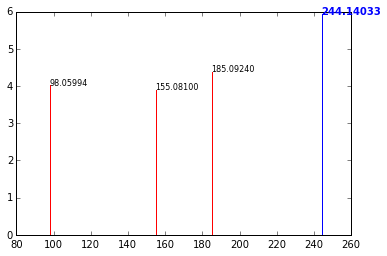

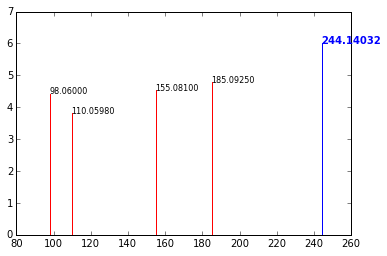

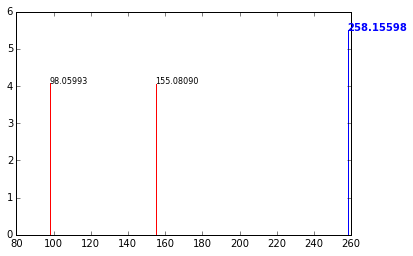

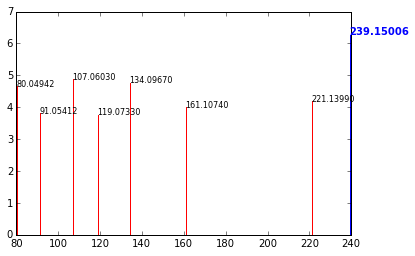

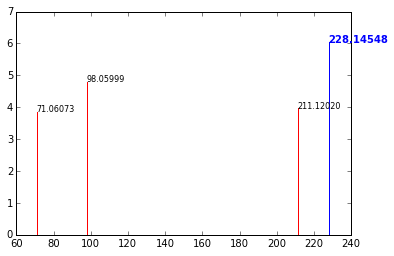

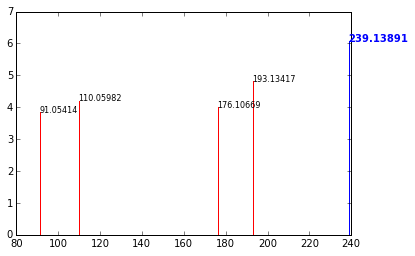

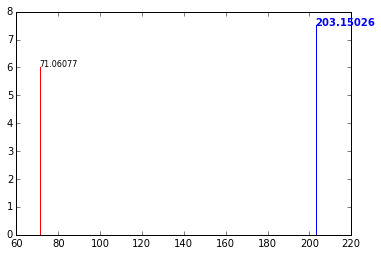

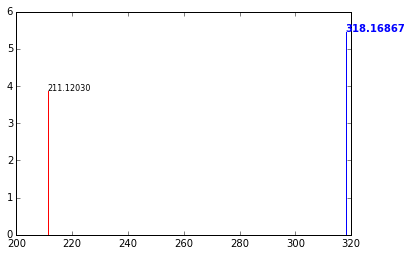

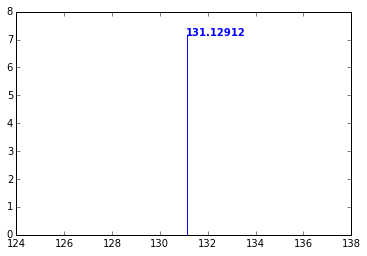

Topic 18

Parent peaks

     peakID	mz		rt		int		prob
1    2462 	606.37016	269.747		6.308e+05	0.995
2    2464 	650.39629	269.747		5.869e+05	0.993
3    2236 	672.40933	269.747		4.630e+05	0.959
4    2461 	584.35683	271.396		6.243e+05	0.947
5    1288 	352.30572	234.884		3.942e+05	0.809
6    2720 	344.22788	284.365		5.089e+05	0.800
7    5603 	254.10221	294.270		4.091e+05	0.679
8    2510 	388.25394	281.137		4.226e+05	0.675
9    2653 	560.47120	271.396		1.007e+06	0.641

Fragments

1    fragment_89.06008 (0.053)
 peakID  MSnParentPeakID  mz         rt       intensity    
 13345   1288             89.060167  234.615   46216.964844
 14359   2461             89.060126  267.989  157699.296875
 14386   2462             89.060042  267.709  169642.421875
 14476   2510             89.060067  282.320   49058.621094
 14765   2653             89.060053  265.310   16611.023438
 14842   2720             89.060068  283.964   61295.398438
2    fragment_133.08628 (0.041)
 peakID  MSnParentPeakID  mz         

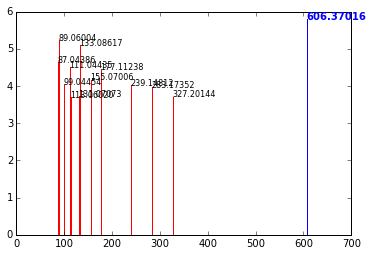

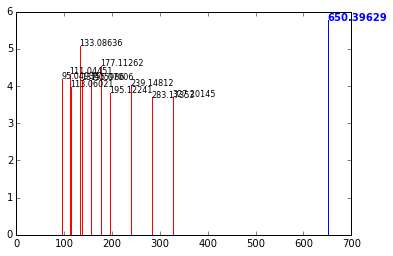

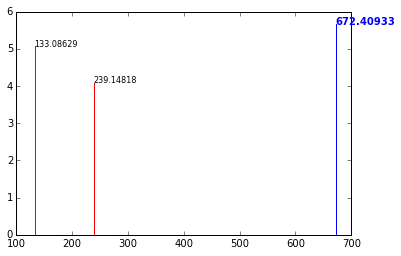

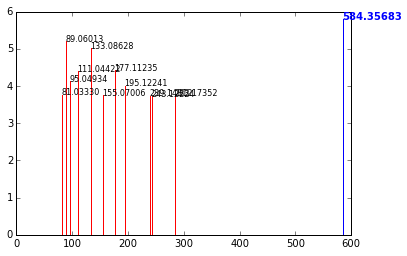

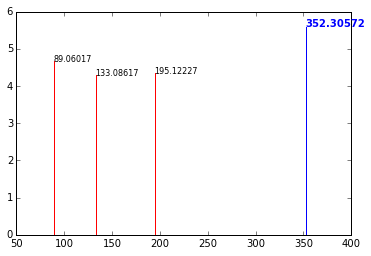

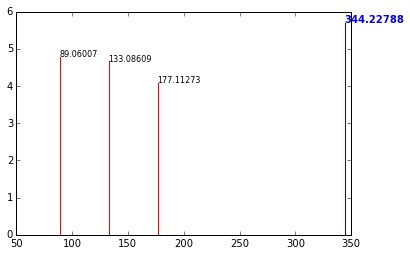

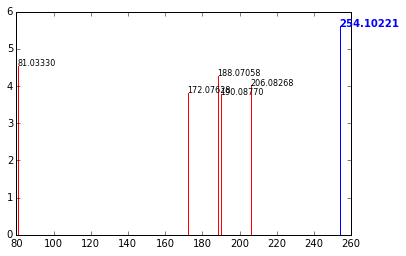

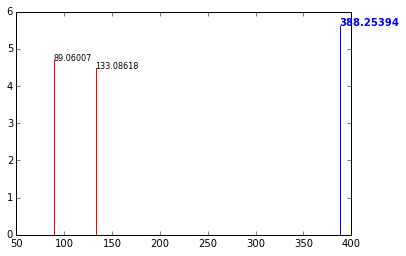

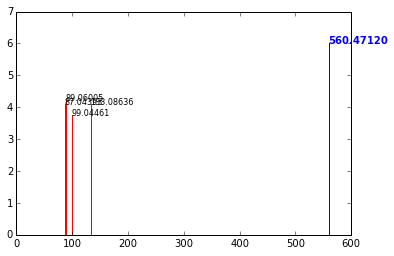

Topic 19

Parent peaks

     peakID	mz		rt		int		prob
1    10627	257.16059	966.056		2.596e+05	0.979
2    11379	175.11894	1027.770		3.669e+06	0.951
3    11380	175.11897	1050.210		9.611e+05	0.919
4    8889 	90.05496	630.413		7.314e+06	0.891
5    9501 	499.22482	711.245		3.067e+06	0.877
6    9113 	218.12476	691.613		4.311e+05	0.872
7    10505	319.16114	896.485		5.220e+06	0.871
8    10589	244.17650	927.424		5.341e+05	0.813
9    7508 	416.26157	556.072		6.047e+05	0.800

Fragments

1    fragment_72.08072 (0.144)
 peakID  MSnParentPeakID  mz        rt        intensity
 20782    7508            72.08124   555.950  12327.520
 22802    8889            72.08066   624.880  20298.170
 23241    9501            72.08087   705.474  23294.640
 24275   10505            72.08069   896.165  32150.750
 24772   10589            72.08071   927.975  17914.320
 24780   10627            72.08075   966.739  24379.410
 25119   11379            72.08071  1033.000  13502.080
 25127   11380            72.08067  1048

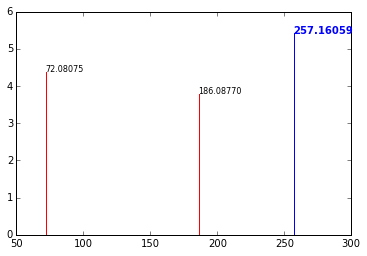

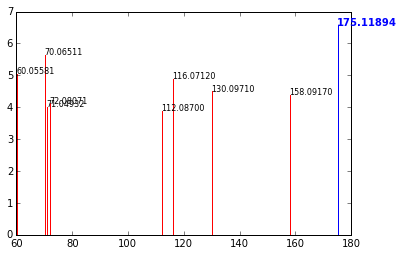

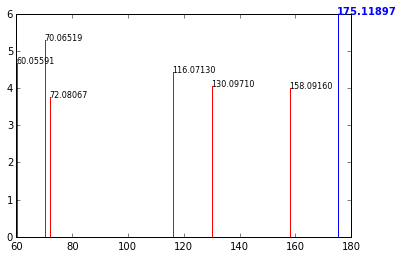

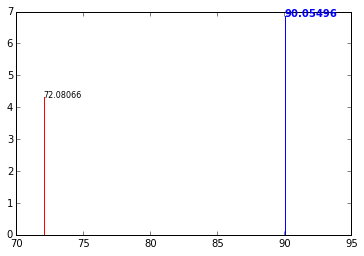

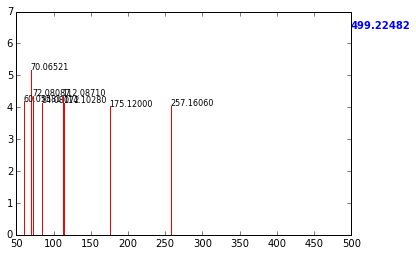

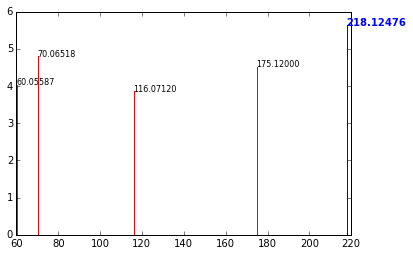

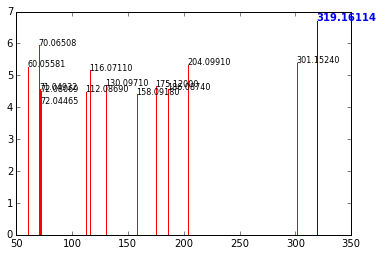

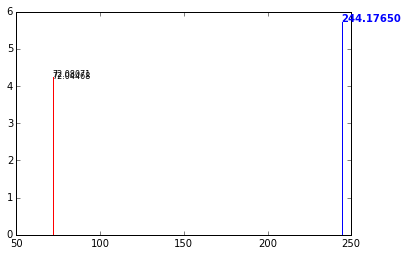

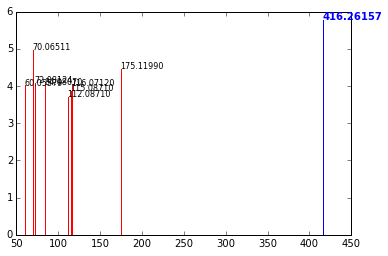

Topic 20

Parent peaks

     peakID	mz		rt		int		prob
1    5253 	314.15982	412.921		7.184e+06	0.483
2    5448 	318.15485	432.115		7.443e+05	0.419
3    8049 	252.10761	592.308		3.563e+07	0.414
4    6054 	342.15486	412.921		2.899e+06	0.356
5    8396 	296.09760	624.196		3.083e+06	0.293
6    7275 	344.13393	534.050		3.699e+06	0.190
7    4709 	306.13360	281.137		2.536e+06	0.094
8    10528	291.16318	632.053		6.842e+06	0.062
9    5493 	420.18633	449.698		7.103e+05	0.054

Fragments

1    fragment_80.04949 (0.006)
 peakID  MSnParentPeakID  mz        rt       intensity
 18328   6054             80.04962  410.623  22422.330
 21696   8049             80.04946  597.457  17708.470
 22150   8396             80.04947  620.049   9795.518
2    fragment_55.01824 (0.006)
 peakID  MSnParentPeakID  mz         rt       intensity   
 16522    4709            55.018225  275.506  10389.076172
 17073    5253            55.018195  412.106  25511.324219
 18319    6054            55.018380  410.623  38058.300000
 2

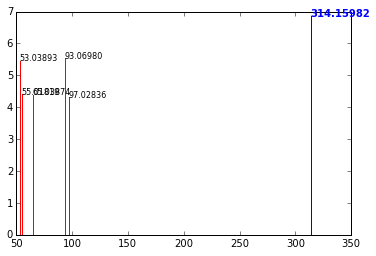

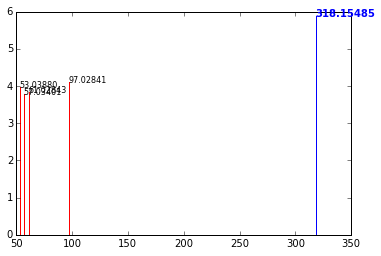

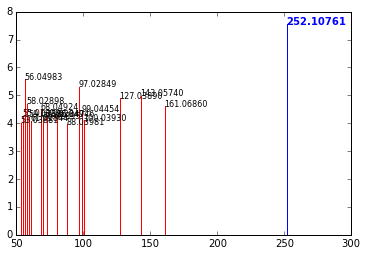

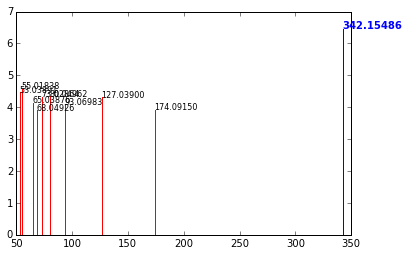

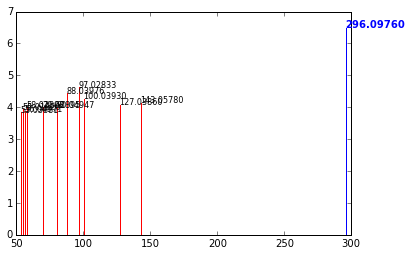

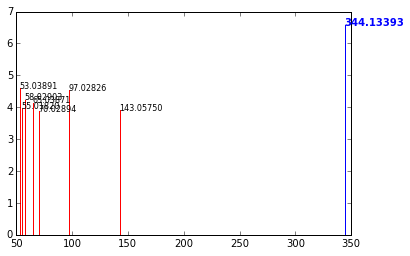

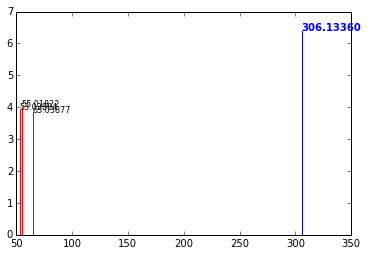

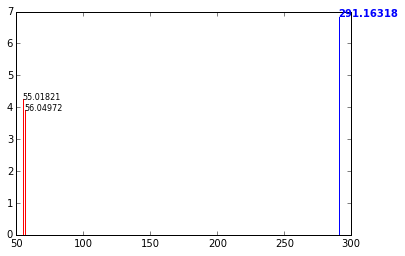

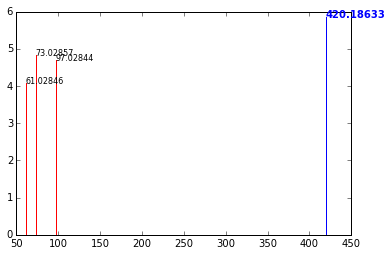

Topic 21

Parent peaks

     peakID	mz		rt		int		prob
1    2784 	280.15430	256.419		6.771e+05	0.934
2    1754 	258.20632	224.227		6.017e+05	0.850
3    6822 	510.21608	518.554		6.404e+05	0.791
4    670  	489.24841	210.369		4.691e+05	0.771
5    2183 	244.19068	228.159		8.796e+05	0.655
6    7822 	311.12365	570.233		6.113e+05	0.603
7    2625 	355.15395	249.786		8.741e+06	0.586
8    1323 	292.19063	221.946		5.747e+05	0.514
9    4497 	202.14378	243.181		2.058e+06	0.507

Fragments

1    fragment_57.07007 (0.043)
 peakID  MSnParentPeakID  mz         rt       intensity    
 12964    670             57.070019  211.906   13425.283203
 13380   1323             57.070048  220.990   30512.082031
 13794   1754             57.070148  222.501   27836.250000
 14101   2183             57.070103  224.501   25091.460938
 16320   4497             57.070172  240.575  124687.468750
2    fragment_95.04936 (0.029)
 peakID  MSnParentPeakID  mz         rt       intensity   
 14598   2625             95.049379  25

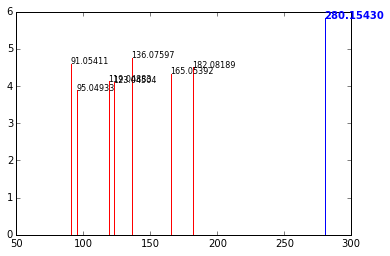

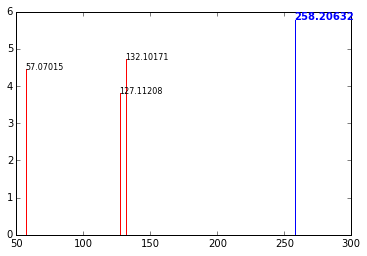

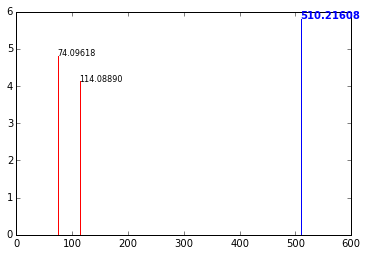

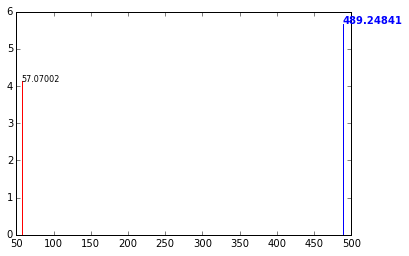

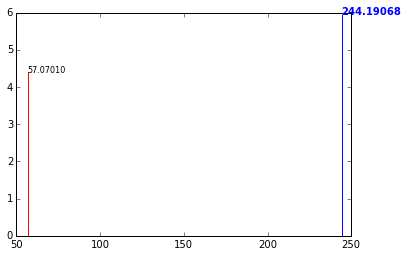

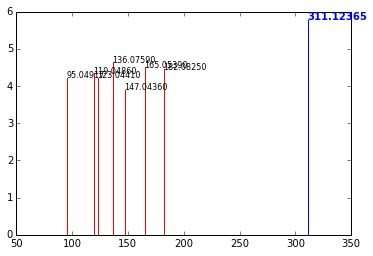

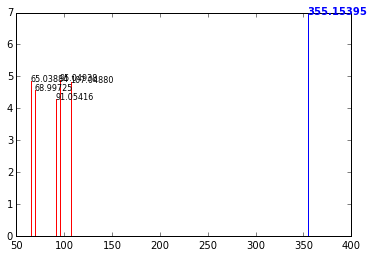

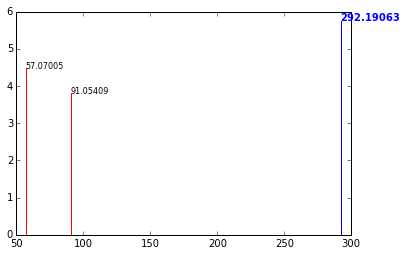

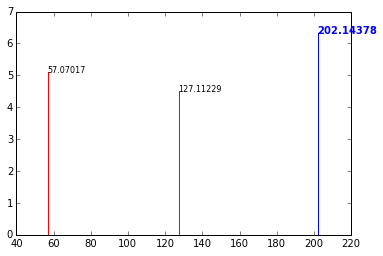

Topic 22

Parent peaks

     peakID	mz		rt		int		prob
1    4388 	245.12839	369.407		1.629e+06	0.948
2    4387 	245.12839	282.730		4.700e+06	0.945
3    8886 	272.13516	669.781		5.689e+05	0.916
4    6139 	249.08444	428.854		6.401e+05	0.898
5    10182	277.16578	749.460		6.976e+06	0.855
6    10185	277.16580	776.132		5.715e+06	0.848
7    10597	455.21367	955.832		4.399e+05	0.832
8    10511	251.13887	911.813		6.170e+05	0.795
9    4620 	261.12325	372.653		1.202e+06	0.717

Fragments

1    fragment_91.05413 (0.070)
 peakID  MSnParentPeakID  mz         rt       intensity    
 16257    4387            91.054152  277.391    7228.862793
 16279    4388            91.054053  366.472   10663.512695
 16432    4620            91.054160  376.704   41196.007812
 23852   10185            91.054110  777.026  633327.200000
 24300   10511            91.054070  905.010   70412.440000
 24775   10597            91.054170  948.337   51507.420000
2    fragment_147.04377 (0.064)
 peakID  MSnParentPeakID  mz         

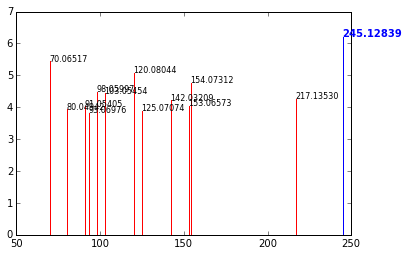

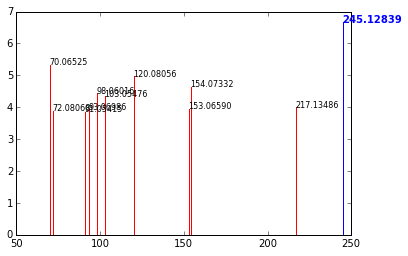

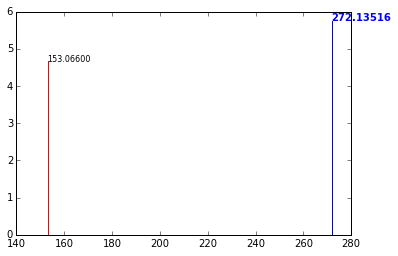

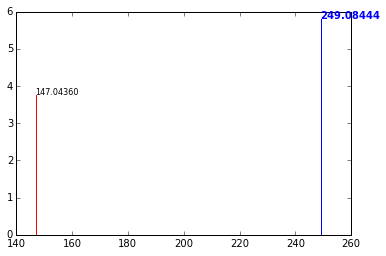

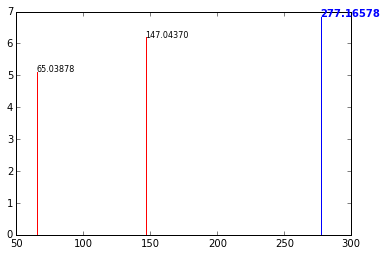

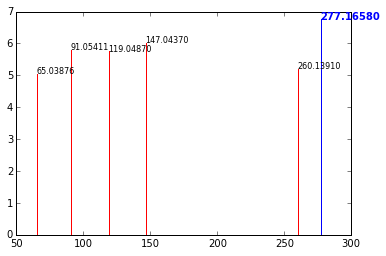

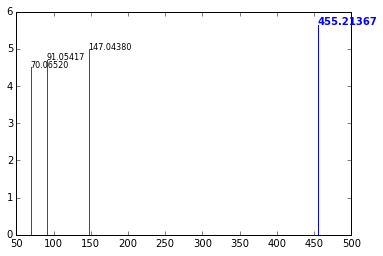

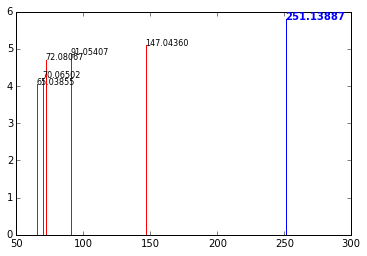

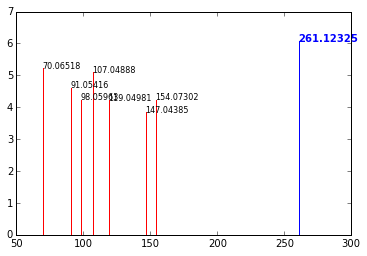

Topic 23

Parent peaks

     peakID	mz		rt		int		prob
1    7708 	133.06885	565.722		1.220e+06	0.978
2    4640 	309.03710	349.996		7.000e+05	0.900
3    7706 	119.08965	568.665		1.262e+06	0.890
4    2512 	407.23907	279.485		4.221e+05	0.865
5    3312 	365.19167	313.268		3.311e+05	0.829
6    3999 	351.17604	328.784		3.125e+05	0.802
7    7770 	138.05488	546.349		4.148e+08	0.568
8    8575 	351.12221	647.573		5.998e+05	0.536
9    7764 	118.08621	568.665		2.416e+07	0.489

Fragments

1    fragment_68.0498 (0.052)
 peakID  MSnParentPeakID  mz        rt       intensity
 22266   8575             68.04977  647.454  11247.87 
2    fragment_96.04414 (0.051)
 peakID  MSnParentPeakID  mz         rt       intensity     
 14489   2512             96.043844  281.013    14622.060547
 21176   7770             96.044240  551.480  1797892.000000
3    fragment_104.071 (0.017)
 peakID  MSnParentPeakID  mz       rt       intensity
 22257   8575             104.071  647.454  104984.7 
4    fragment_56.04978 (0.01

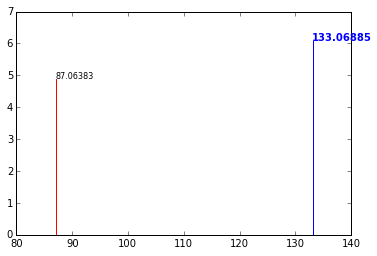

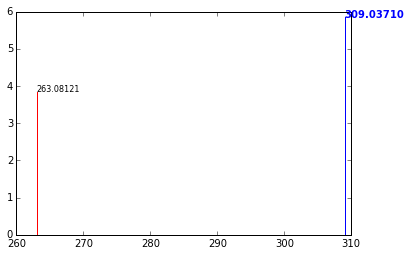

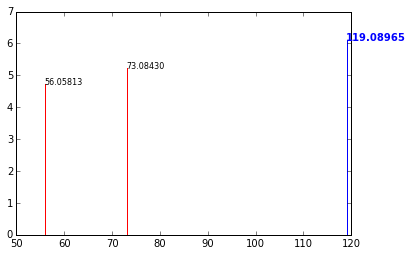

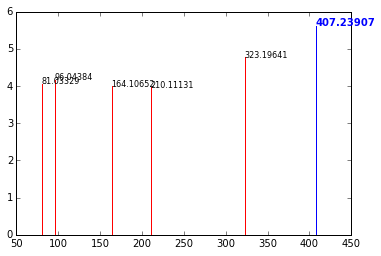

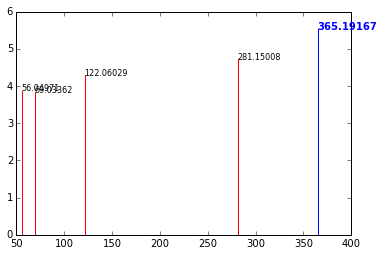

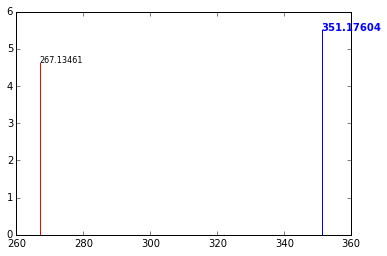

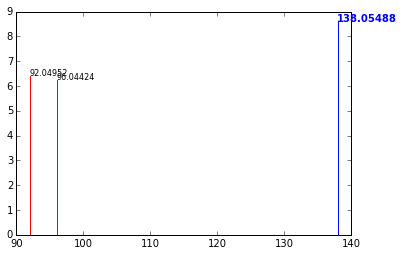

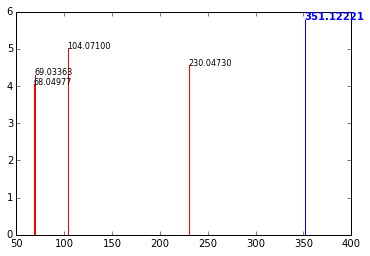

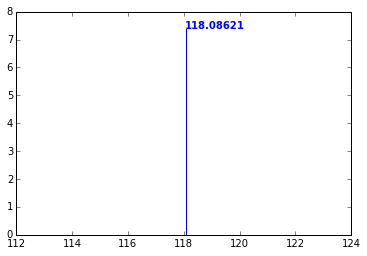

Topic 24

Parent peaks

     peakID	mz		rt		int		prob
1    9036 	183.08632	613.130		5.021e+07	0.738
2    1354 	654.33223	223.606		1.381e+06	0.693
3    7395 	193.07065	547.980		8.298e+05	0.645
4    7937 	138.05249	578.163		1.900e+07	0.496
5    8078 	205.11832	597.184		9.746e+06	0.482
6    6134 	73.06479	468.549		1.047e+06	0.480
7    6818 	439.19673	513.775		6.372e+05	0.460
8    6386 	240.12299	254.771		5.049e+05	0.459
9    10460	111.04405	593.907		3.439e+06	0.441

Fragments

1    fragment_55.05468 (0.115)
 peakID  MSnParentPeakID  mz         rt       intensity    
 13423    1354            55.054715  219.315   18105.853516
 18467    6134            55.054660  463.946  125429.900000
 18974    6386            55.054600  256.018    5671.164000
 19631    6818            55.054740  516.636   31981.900000
 20704    7395            55.054700  549.359   16219.830000
 21782    8078            55.054740  598.963  289080.100000
 22979    9036            55.054730  618.159  148950.300000
 24114   1

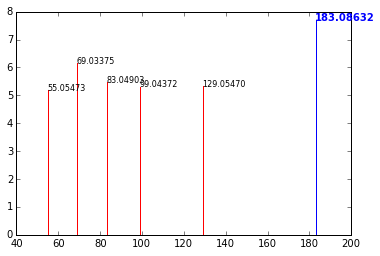

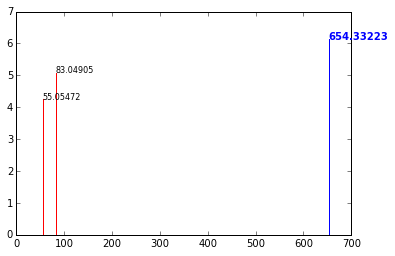

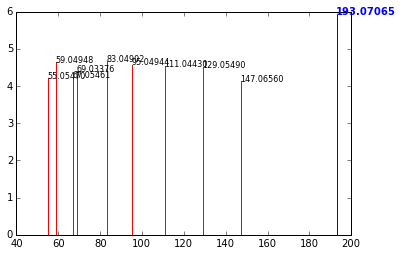

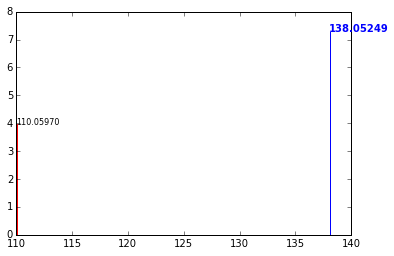

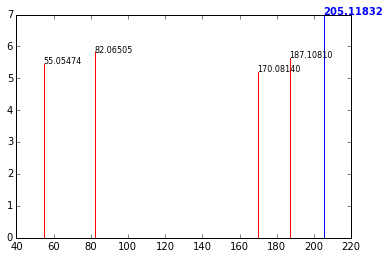

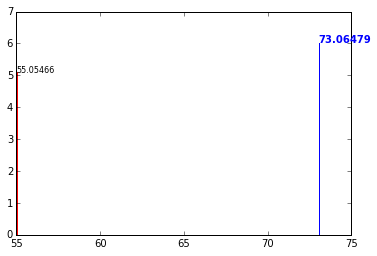

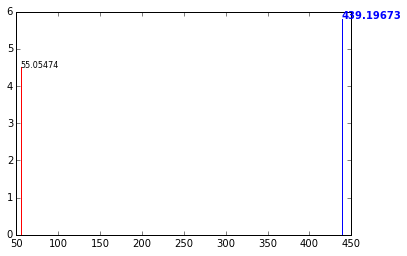

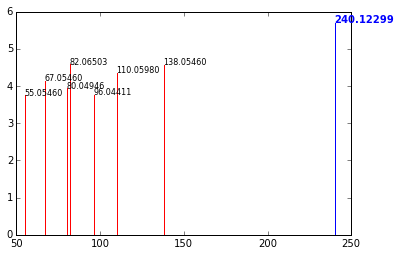

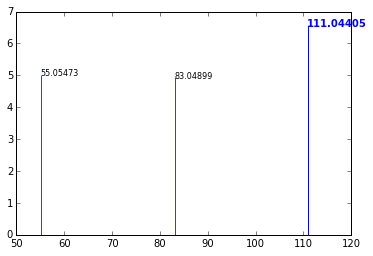

Topic 25

Parent peaks

     peakID	mz		rt		int		prob
1    5097 	452.21375	419.222		9.211e+05	0.995
2    6343 	227.10254	330.420		1.193e+07	0.995
3    5721 	324.15548	417.639		1.094e+06	0.994
4    5720 	324.15534	348.358		1.048e+06	0.993
5    5534 	453.19811	428.854		7.807e+05	0.992
6    5723 	324.15548	374.230		1.094e+06	0.992
7    5724 	324.15542	452.947		7.980e+05	0.991
8    3427 	326.17101	297.637		1.191e+06	0.904
9    3821 	340.18674	290.983		3.782e+06	0.874

Fragments

1    fragment_84.04422 (0.113)
 peakID  MSnParentPeakID  mz         rt       intensity     
 15470   3427             84.044015  295.380   150914.218750
 15803   3821             84.044204  285.741   101555.468750
 16968   5097             84.044243  419.103   121930.523438
 17325   5534             84.044171  438.541   140751.546875
 17801   5720             84.044750  345.788   146289.421875
 17807   5721             84.044813  418.551   123504.796875
 17814   5723             84.044247  380.351    84789.960938
 

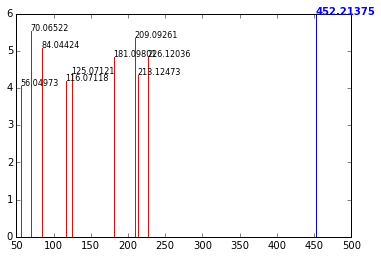

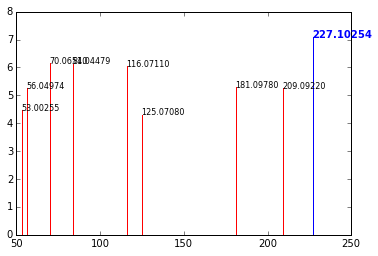

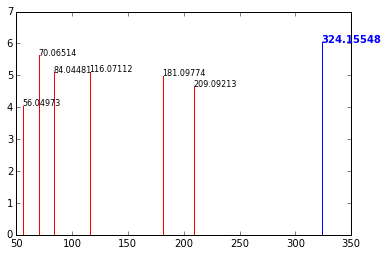

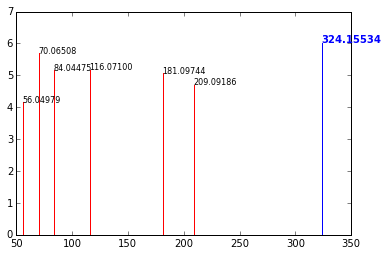

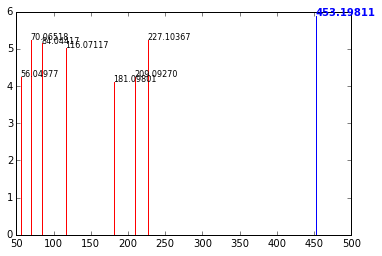

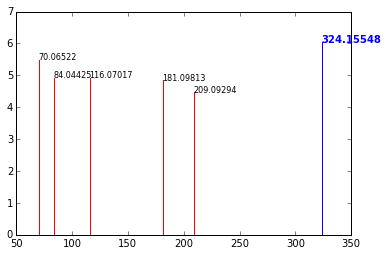

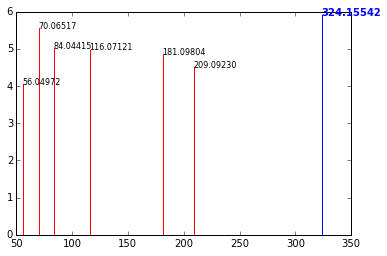

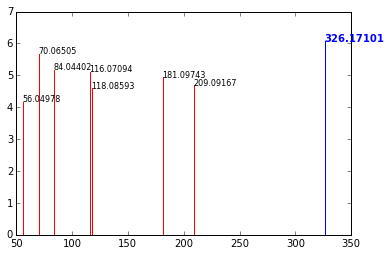

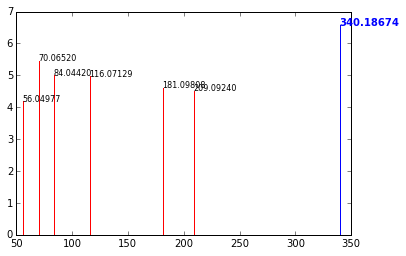

Topic 26

Parent peaks

     peakID	mz		rt		int		prob
1    9114 	527.15870	668.607		7.643e+06	0.989
2    9094 	851.26363	685.059		1.015e+06	0.963
3    6176 	316.13673	468.549		2.403e+06	0.962
4    7144 	393.13652	515.409		5.160e+06	0.957
5    9729 	331.14753	797.174		7.762e+05	0.832
6    9138 	633.27156	692.107		5.880e+05	0.767
7    7419 	304.10025	554.431		8.592e+05	0.689
8    9666 	471.21861	688.576		2.918e+06	0.679
9    9377 	331.14757	714.479		2.698e+05	0.643

Fragments

1    fragment_84.08071 (0.028)
 peakID  MSnParentPeakID  mz        rt       intensity
 20763   7419             84.08068  553.895   7612.365
 23016   9138             84.08077  690.314  50657.540
 23448   9666             84.08083  696.643  35084.430
2    fragment_143.03192 (0.025)
 peakID  MSnParentPeakID  mz        rt       intensity
 18540   6176             143.0318  473.844  34160.550
 20762   7419             143.0316  553.895   8471.085
 23498   9729             143.0322  793.017  13335.820
3    fragment_84.

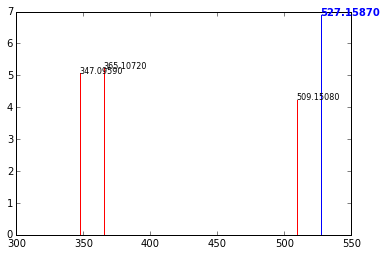

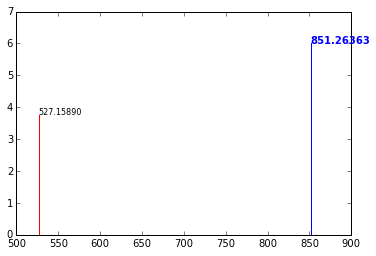

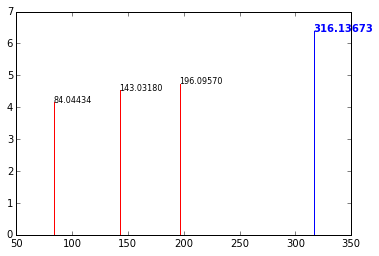

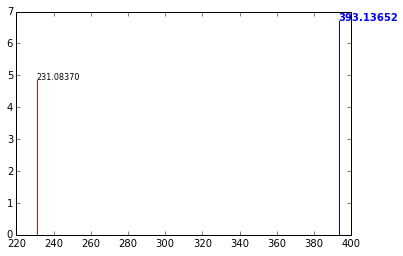

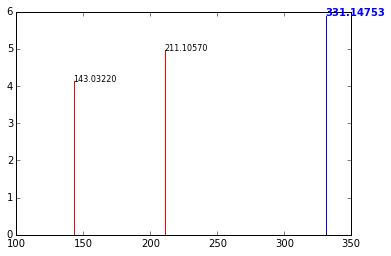

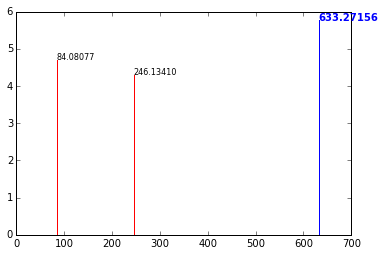

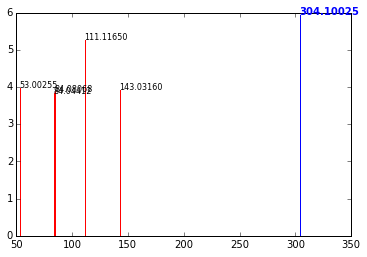

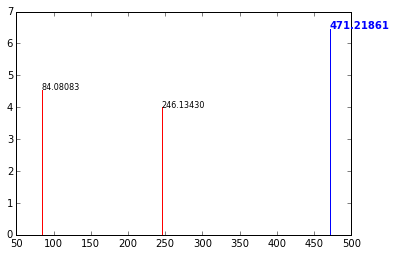

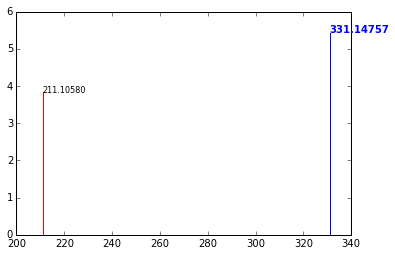

Topic 27

Parent peaks

     peakID	mz		rt		int		prob
1    6339 	216.12311	409.811		1.012e+07	0.975
2    6340 	216.12306	351.627		9.099e+05	0.955
3    3501 	553.36897	223.606		1.358e+07	0.896
4    6341 	216.12305	385.459		2.965e+06	0.861
5    5995 	200.09176	300.895		3.819e+05	0.619
6    1315 	237.11188	236.531		1.396e+06	0.525
7    8810 	218.13866	633.586		5.242e+06	0.519
8    5611 	321.05963	438.661		1.855e+06	0.493
9    1370 	319.15411	231.552		4.909e+05	0.441

Fragments

1    fragment_55.05468 (0.027)
 peakID  MSnParentPeakID  mz         rt       intensity   
 13372   1315             55.054609  232.689   5805.963379
 18731   6339             55.054710  406.808  27108.730000
 18751   6340             55.054580  358.515   9881.890000
 18776   6341             55.054660  390.717  30991.880000
 22604   8810             55.054660  632.703  35125.840000
2    fragment_154.08576 (0.022)
 peakID  MSnParentPeakID  mz          rt       intensity   
 18191   5995             154.085748  300.4

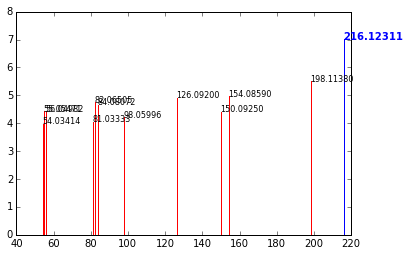

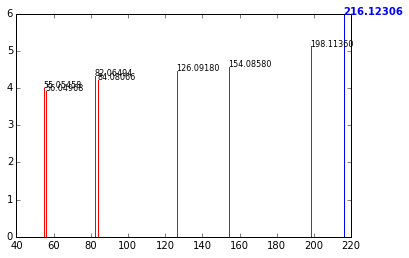

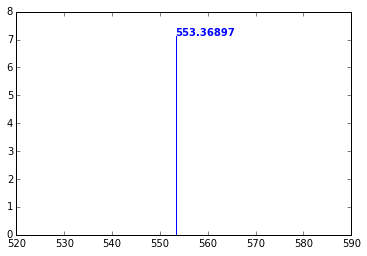

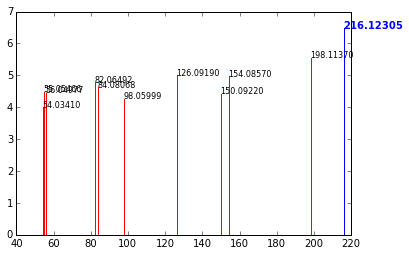

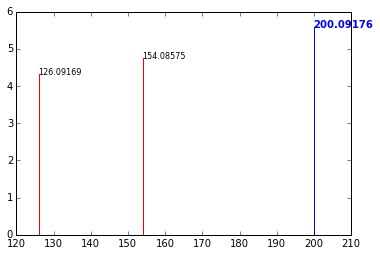

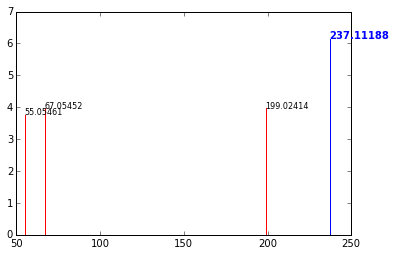

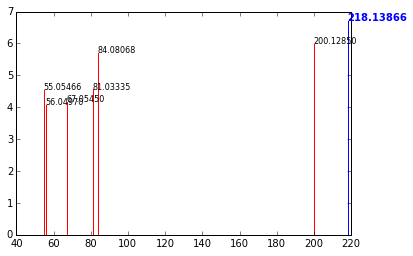

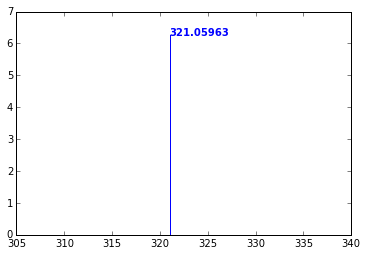

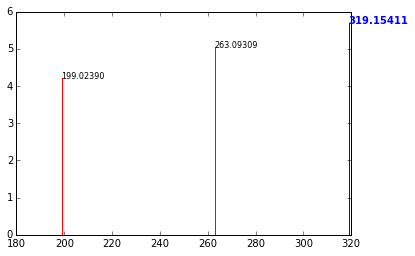

Topic 28

Parent peaks

     peakID	mz		rt		int		prob
1    7088 	294.15460	380.610		1.715e+06	0.870
2    7089 	294.15452	435.357		3.415e+07	0.862
3    8900 	252.10771	619.436		1.053e+06	0.836
4    3465 	336.16523	292.609		2.260e+06	0.745
5    7087 	294.15451	471.593		6.581e+07	0.716
6    3882 	308.17038	286.004		3.582e+06	0.701
7    8046 	234.09711	592.308		1.819e+07	0.686
8    7093 	456.20753	509.007		5.460e+06	0.628
9    7084 	262.12836	501.043		1.134e+07	0.573

Fragments

1    fragment_112.03985 (0.020)
 peakID  MSnParentPeakID  mz          rt       intensity    
 15818   3882             112.039788  283.410   40427.128906
 20097   7088             112.039900  392.899   19701.110000
 20115   7089             112.039900  425.956  228680.200000
 20136   7093             112.039800  503.220   46049.580000
 21635   8046             112.039900  599.082   36738.310000
2    fragment_97.02839 (0.020)
 peakID  MSnParentPeakID  mz         rt       intensity    
 15816   3882             97.02

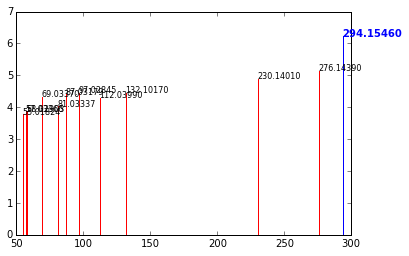

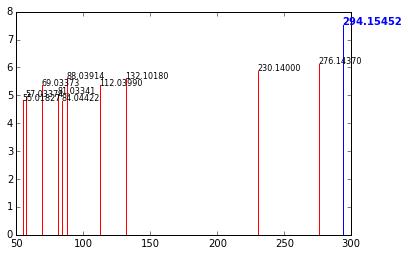

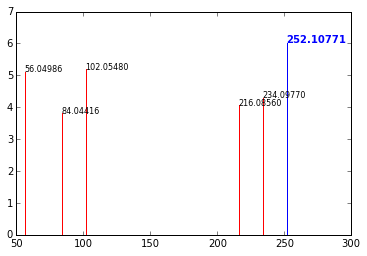

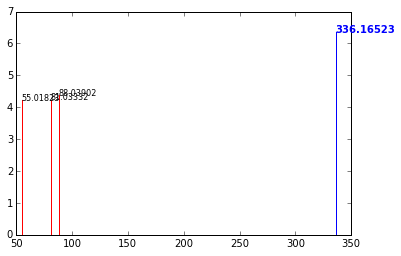

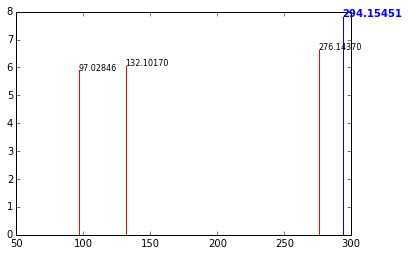

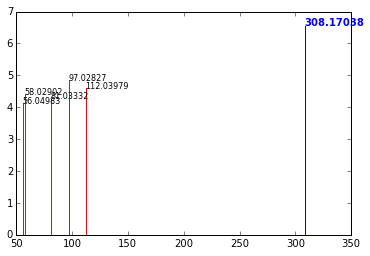

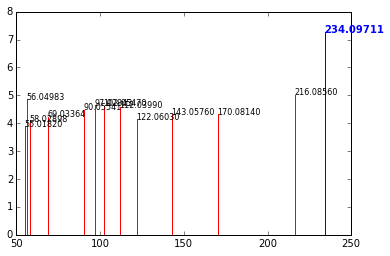

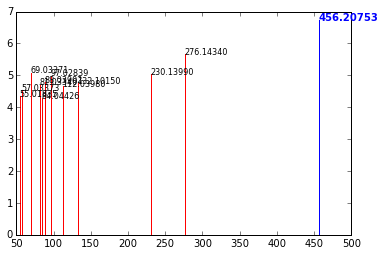

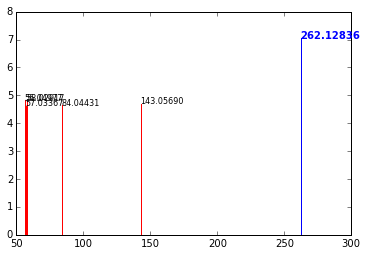

Topic 29

Parent peaks

     peakID	mz		rt		int		prob
1    7011 	121.06481	459.215		4.488e+06	0.997
2    10493	166.12263	696.858		4.826e+07	0.996
3    6755 	152.10700	259.764		3.178e+07	0.996
4    12563	180.13824	1018.080		7.479e+05	0.996
5    12561	180.13824	1111.520		1.270e+06	0.996
6    7010 	121.06480	259.764		5.622e+06	0.996
7    12548	180.13825	1163.280		4.215e+05	0.995
8    10494	166.12262	723.897		2.840e+07	0.995
9    12564	180.13824	1037.050		1.528e+06	0.995

Fragments

1    fragment_121.06489 (0.080)
 peakID  MSnParentPeakID  mz        rt        intensity  
 19421    6755            121.0649   258.397   7514146.00
 24201   10493            121.0650   697.130  10389399.00
 24210   10494            121.0648   744.657   1758415.00
 25219   12548            121.0649  1157.870     77280.87
 25269   12561            121.0648  1111.930    223040.20
 25290   12563            121.0650  1017.870    131445.20
 25312   12564            121.0649  1033.480    236402.00
2    fragment_53.038

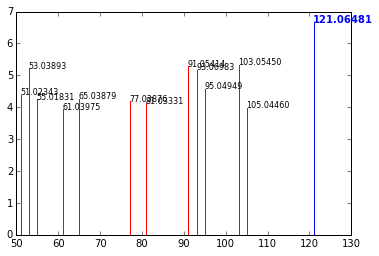

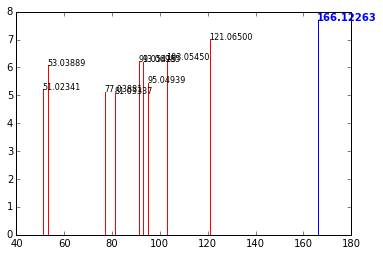

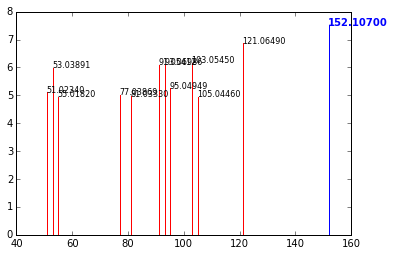

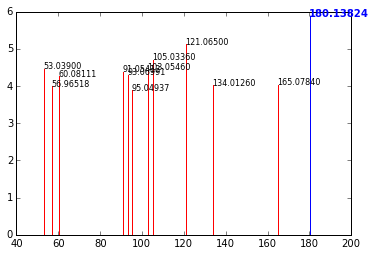

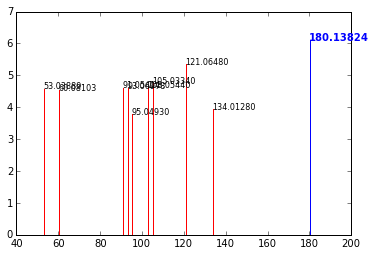

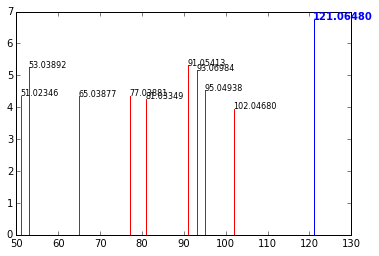

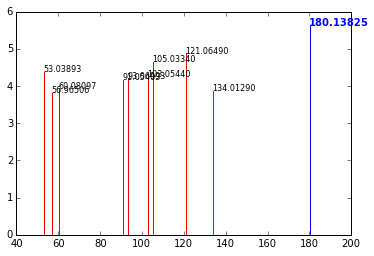

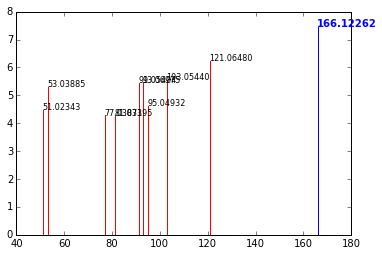

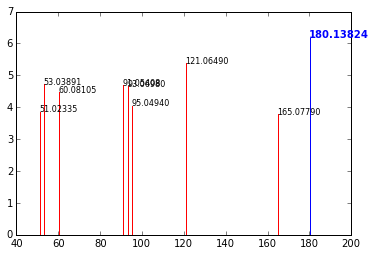

Topic 30

Parent peaks

     peakID	mz		rt		int		prob
1    5762 	236.09164	380.610		1.328e+06	0.893
2    5767 	236.09166	349.996		7.211e+05	0.893
3    4200 	218.08119	277.930		1.308e+06	0.892
4    4202 	218.08116	325.502		4.427e+05	0.870
5    6385 	240.12286	437.038		8.992e+05	0.634
6    2107 	353.19594	218.622		3.729e+05	0.579
7    9261 	175.02367	705.821		2.527e+05	0.386
8    7157 	127.03897	346.733		5.574e+05	0.369
9    2335 	256.09666	263.096		9.271e+05	0.350

Fragments

1    fragment_115.05434 (0.015)
 peakID  MSnParentPeakID  mz          rt       intensity   
 14219   2335             115.054518  259.084  39073.574219
 16042   4200             115.054362  275.367  26912.173828
 16105   4202             115.054298  322.399   9991.744141
 17847   5762             115.054389  375.057  19233.501953
 17913   5767             115.054309  357.731   9634.739258
2    fragment_172.07629 (0.013)
 peakID  MSnParentPeakID  mz          rt       intensity   
 16040   4200             172.076280

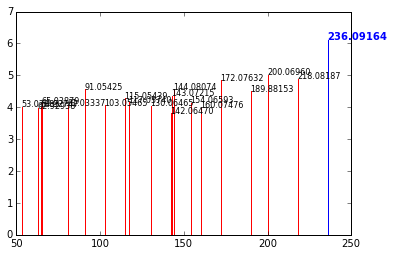

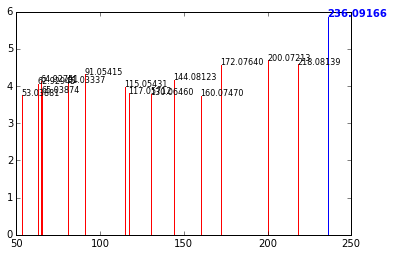

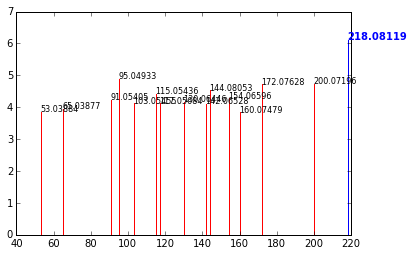

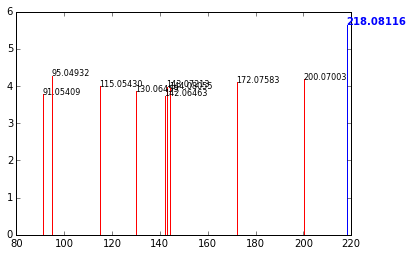

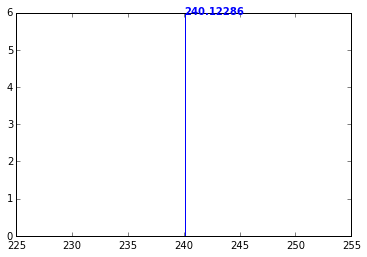

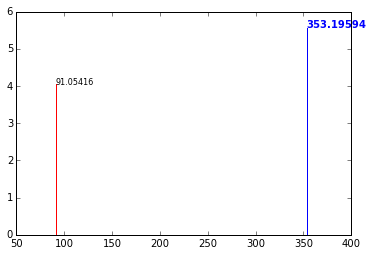

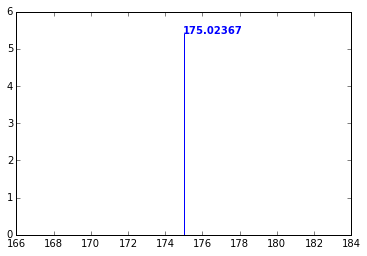

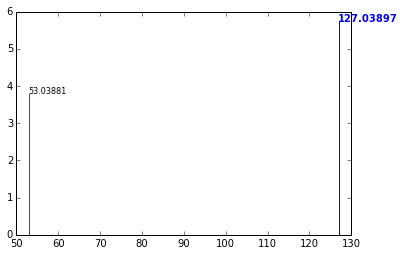

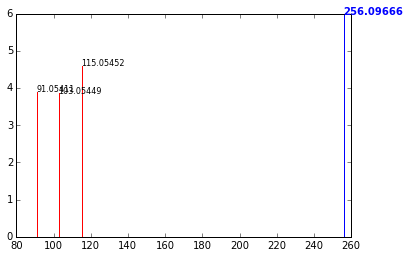

Topic 31

Parent peaks

     peakID	mz		rt		int		prob
1    7720 	176.09174	556.072		3.881e+06	0.753
2    10048	309.13776	846.264		3.148e+05	0.629
3    7185 	145.04957	466.972		7.999e+06	0.613
4    6893 	158.08120	438.661		2.542e+06	0.589
5    7120 	188.09171	510.582		6.463e+05	0.544
6    7990 	174.03854	587.564		7.360e+06	0.525
7    6753 	148.06029	494.747		1.646e+06	0.512
8    6648 	276.14406	435.357		4.778e+06	0.510
9    6289 	174.07613	424.099		1.978e+06	0.508

Fragments

1    fragment_55.01824 (0.042)
 peakID  MSnParentPeakID  mz        rt       intensity
 19346   6648             55.01832  437.311  16294.15 
 20376   7185             55.01824  467.330  59966.54 
2    fragment_56.04978 (0.031)
 peakID  MSnParentPeakID  mz        rt       intensity
 23790   10048            56.04973  848.534  7808.417 
3    fragment_98.05999 (0.031)
 peakID  MSnParentPeakID  mz        rt       intensity
 18655   6289             98.06010  426.315   13735.92
 21022   7720             98.06002  556.58

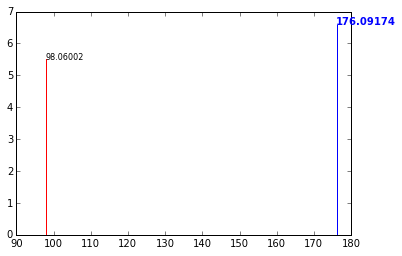

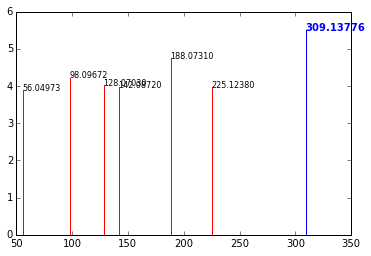

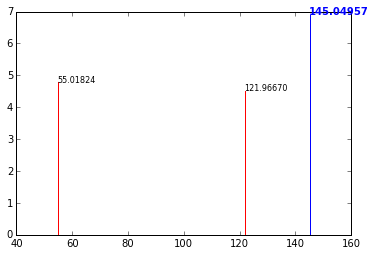

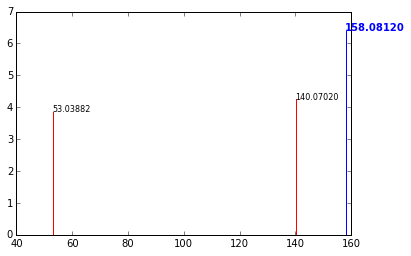

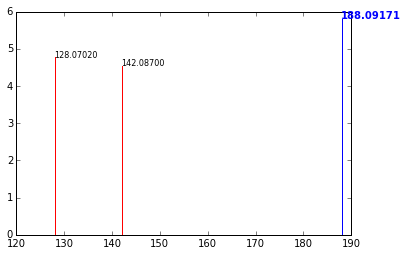

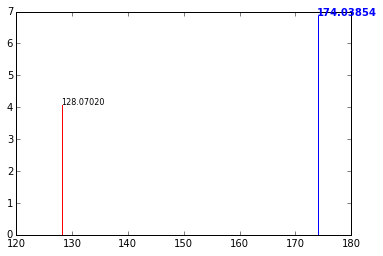

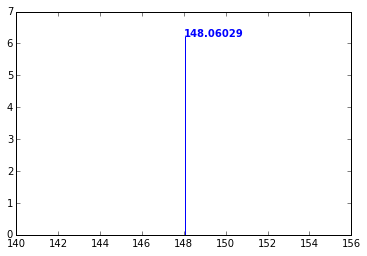

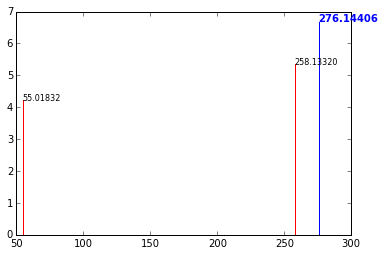

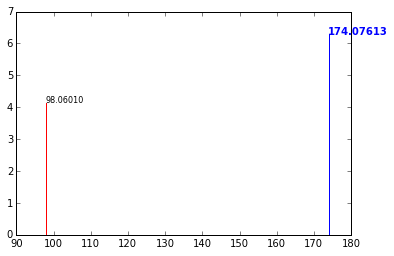

Topic 32

Parent peaks

     peakID	mz		rt		int		prob
1    953  	489.22746	228.159		4.075e+05	0.988
2    2630 	369.20378	248.128		5.472e+06	0.970
3    5733 	124.03935	335.339		4.551e+06	0.914
4    1144 	680.48034	221.946		1.786e+06	0.912
5    1741 	663.45372	221.946		2.136e+06	0.897
6    6363 	152.03182	483.773		6.049e+06	0.886
7    1085 	647.45872	220.295		1.120e+06	0.839
8    2598 	279.15900	236.531		1.055e+06	0.764
9    6284 	163.13286	259.764		4.586e+06	0.743

Fragments

1    fragment_53.03889 (0.109)
 peakID  MSnParentPeakID  mz         rt       intensity   
 13200    953             53.038812  227.060  12254.598633
 13301   1144             53.038841  216.680  17510.404297
 13787   1741             53.038900  216.827  28149.849609
 17831   5733             53.038857  337.263  36673.011719
2    fragment_105.07017 (0.081)
 peakID  MSnParentPeakID  mz          rt       intensity    
 13196    953             105.070131  227.060  211198.593750
 13304   1144             105.070232  21

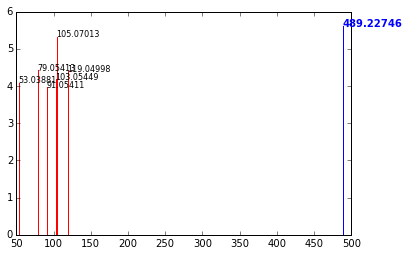

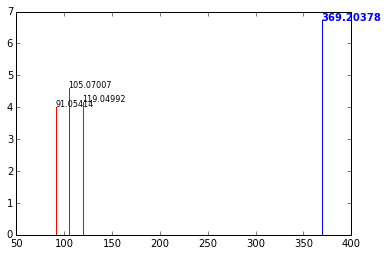

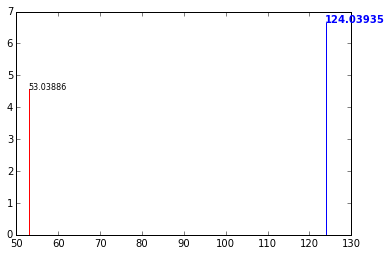

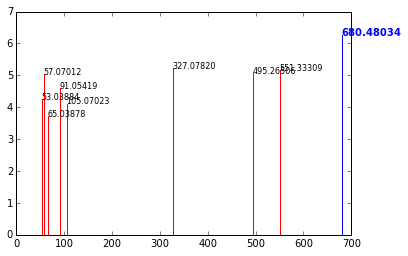

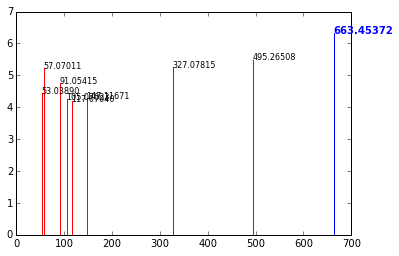

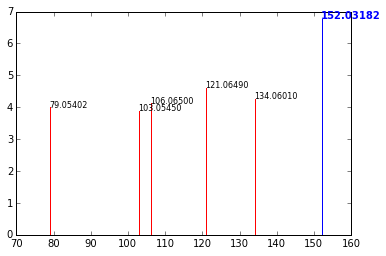

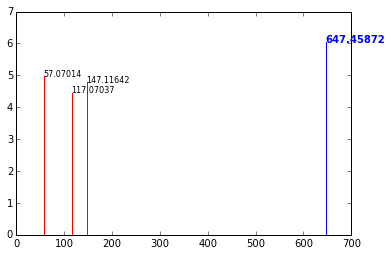

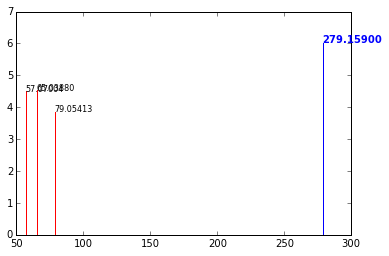

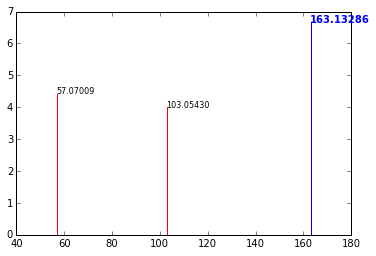

Topic 33

Parent peaks

     peakID	mz		rt		int		prob
1    4368 	210.17001	322.471		5.487e+05	0.991
2    2489 	268.21177	261.408		3.217e+05	0.970
3    7195 	193.14347	277.930		2.849e+07	0.842
4    7196 	193.14348	366.198		1.842e+06	0.837
5    9933 	97.02844	669.781		5.048e+06	0.736
6    4108 	251.18519	259.764		8.181e+06	0.714
7    8469 	288.10539	633.586		1.248e+06	0.665
8    4511 	211.14411	323.903		1.831e+06	0.622
9    3768 	236.11278	241.536		1.771e+07	0.604

Fragments

1    fragment_59.04942 (0.091)
 peakID  MSnParentPeakID  mz         rt       intensity     
 14459   2489             59.049504  262.832    70220.640625
 15981   4108             59.049479  252.998   226950.609375
 16162   4368             59.049477  322.124   106521.601562
 16384   4511             59.049326  318.278     8023.534668
 20439   7195             59.049310  283.003  1872565.000000
 20444   7196             59.049340  364.979   303205.500000
2    fragment_53.0026 (0.081)
 peakID  MSnParentPeakID  mz     

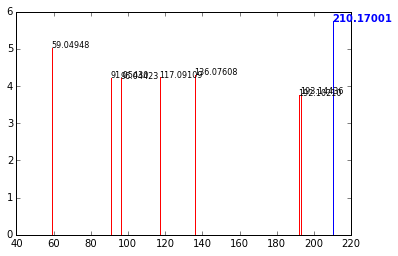

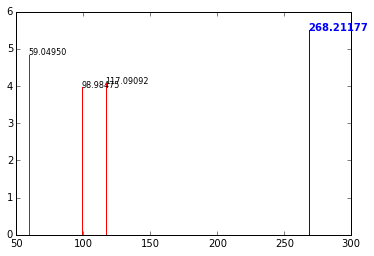

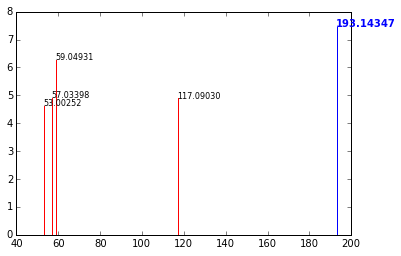

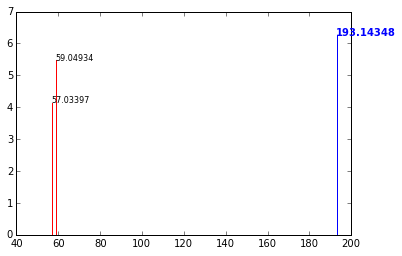

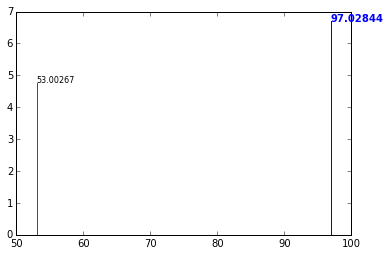

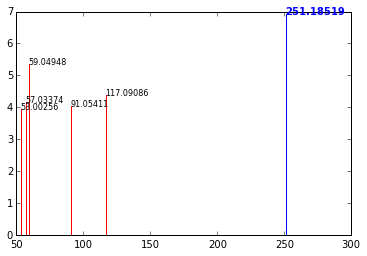

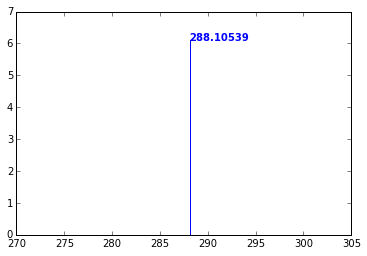

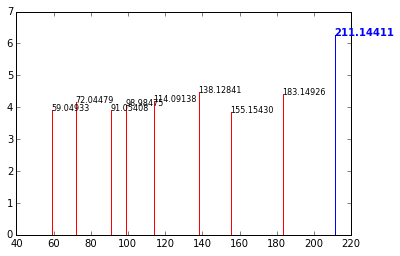

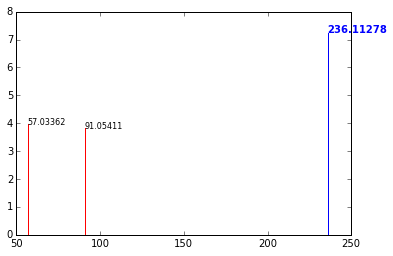

Topic 34

Parent peaks

     peakID	mz		rt		int		prob
1    9222 	684.25554	678.367		1.761e+07	0.996
2    9224 	1008.36142	688.576		1.930e+06	0.996
3    8827 	1009.34530	662.160		8.002e+05	0.995
4    8875 	1026.37226	662.160		1.128e+06	0.994
5    9490 	522.20296	662.160		5.828e+07	0.992
6    9338 	360.14997	705.057		3.450e+05	0.990
7    9029 	829.28123	684.580		1.110e+06	0.990
8    7211 	432.20766	513.775		1.162e+06	0.989
9    9641 	342.13954	714.479		1.633e+06	0.989

Fragments

1    fragment_85.02833 (0.103)
 peakID  MSnParentPeakID  mz        rt       intensity 
 20515   7211             85.02836  506.953    151066.5
 22622   8827             85.02827  657.976    600192.5
 22738   8875             85.02831  656.663    860349.8
 22967   9029             85.02826  676.640    357373.0
 23043   9222             85.02828  670.063   4950636.0
 23059   9224             85.02833  696.363   1042603.0
 23163   9338             85.02844  704.488     43442.4
 23234   9490             85.02830  65

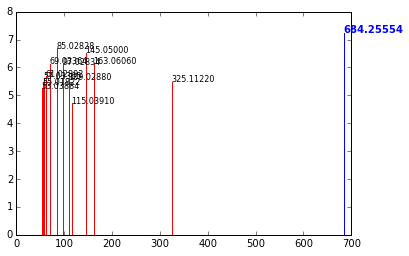

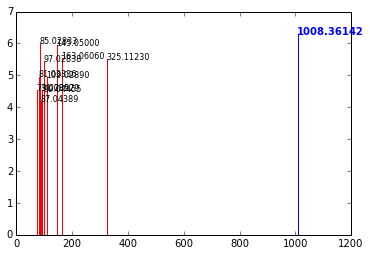

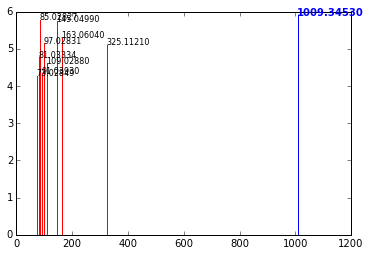

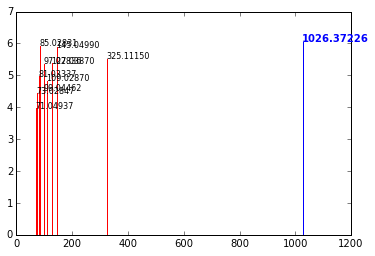

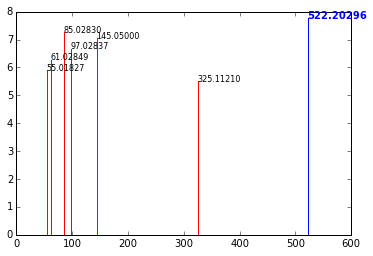

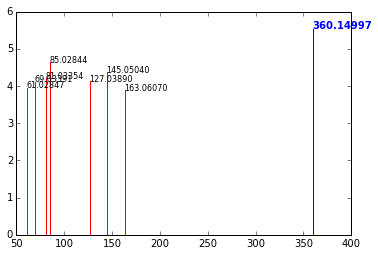

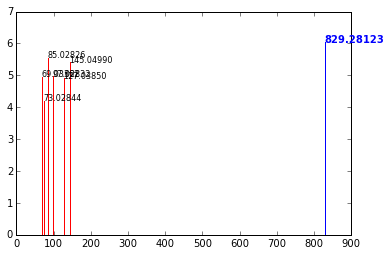

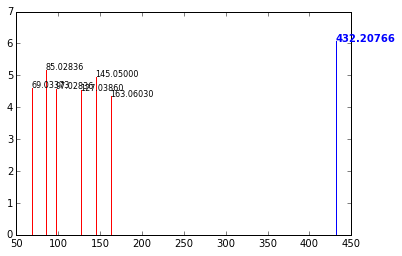

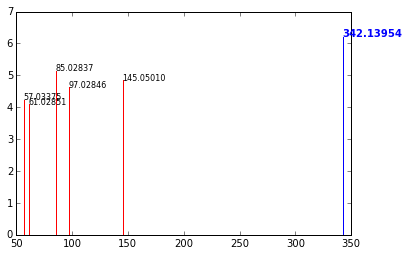

Topic 35

Parent peaks

     peakID	mz		rt		int		prob
1    8778 	428.17624	650.793		2.782e+07	0.742
2    8934 	386.16565	655.682		1.869e+06	0.711
3    7968 	282.11815	554.431		1.383e+07	0.657
4    7626 	264.10764	552.842		2.453e+06	0.630
5    6924 	230.10228	469.996		1.287e+07	0.560
6    9234 	265.13927	684.096		8.845e+05	0.551
7    8837 	590.22941	658.950		1.993e+06	0.529
8    5592 	230.04813	440.293		2.099e+06	0.455
9    2811 	447.24487	290.983		5.433e+05	0.330

Fragments

1    fragment_98.05999 (0.019)
 peakID  MSnParentPeakID  mz         rt       intensity    
 17399   5592             98.060011  444.353  100248.820312
 19712   6924             98.059990  464.659  591394.200000
 20851   7626             98.060060  548.944   26074.140000
 21486   7968             98.059970  556.347  227871.500000
 22561   8778             98.060000  655.959  304267.300000
 22896   8934             98.059940  651.481   11132.330000
 23085   9234             98.059960  678.912   10327.230000
2    frag

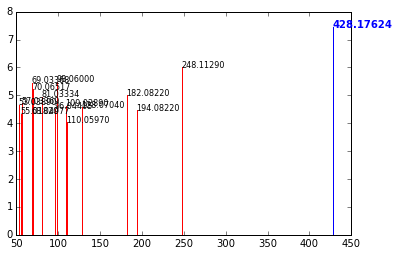

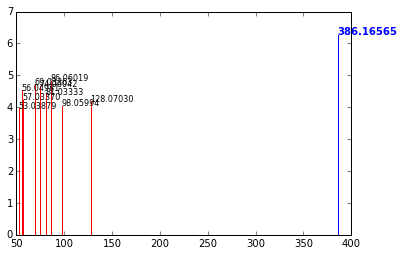

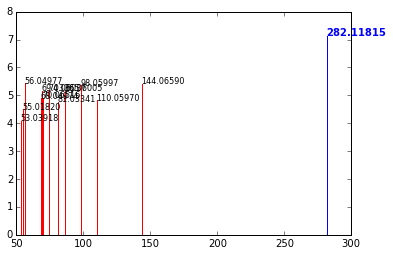

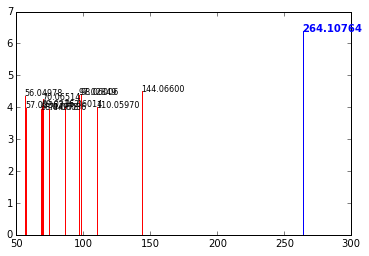

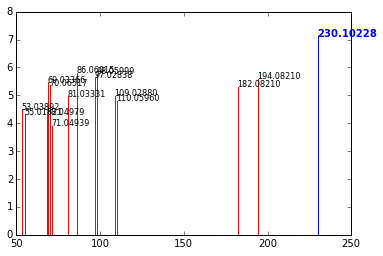

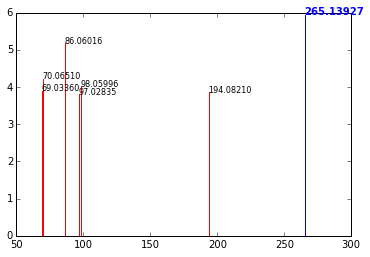

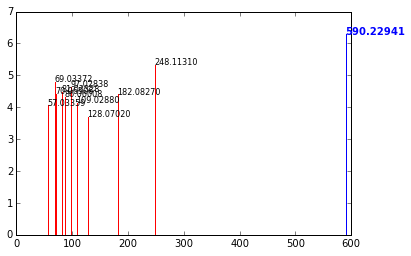

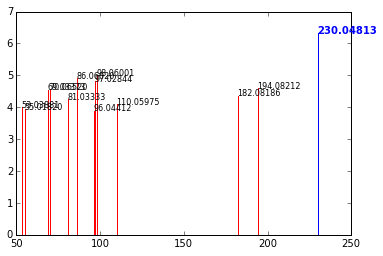

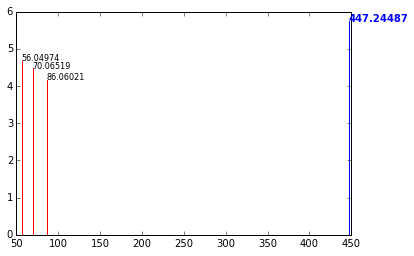

Topic 36

Parent peaks

     peakID	mz		rt		int		prob
1    5141 	188.12809	292.609		2.908e+06	0.811
2    7734 	241.15448	544.850		2.319e+06	0.791
3    5917 	174.11251	457.696		1.369e+06	0.775
4    7733 	241.15453	490.026		5.606e+06	0.771
5    5142 	188.12813	411.438		3.608e+06	0.755
6    5920 	174.11255	411.438		1.937e+06	0.710
7    7710 	144.10189	515.409		9.397e+06	0.687
8    5125 	479.11858	422.465		9.422e+05	0.600
9    4499 	202.14378	284.365		1.247e+06	0.593

Fragments

1    fragment_86.06014 (0.076)
 peakID  MSnParentPeakID  mz         rt       intensity    
 16999   5141             86.060074  290.299   53524.324219
 17012   5142             86.060204  410.483  103558.234375
 18102   5917             86.060185  463.123   70168.445312
 18113   5920             86.060231  413.422   67554.117188
2    fragment_87.04389 (0.058)
 peakID  MSnParentPeakID  mz         rt       intensity   
 18103   5917             87.043937  463.123  64472.007812
3    fragment_58.06553 (0.037)
 peakID  

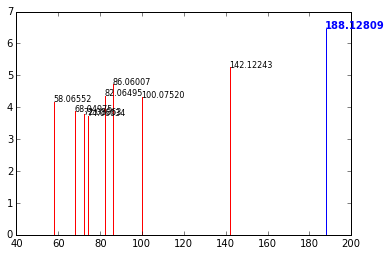

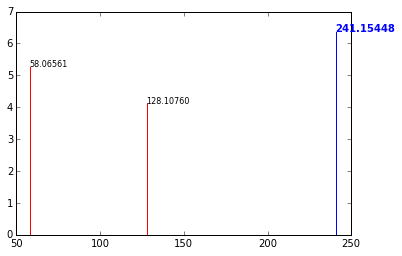

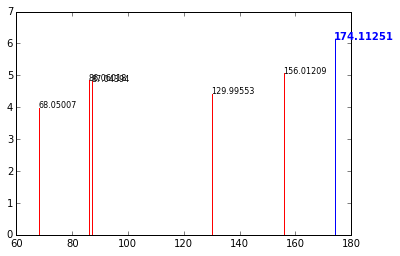

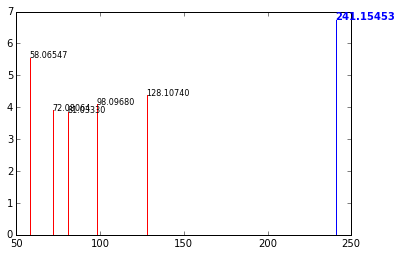

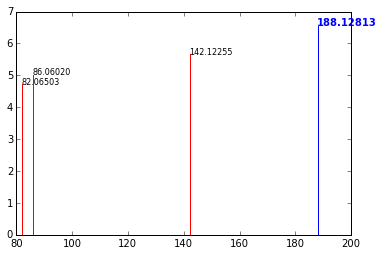

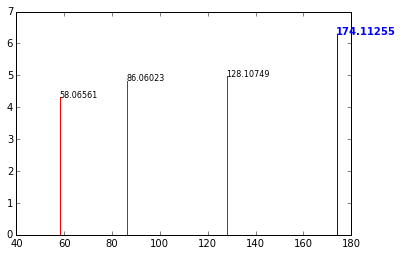

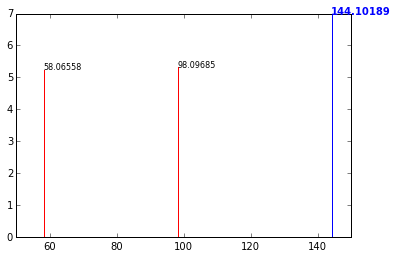

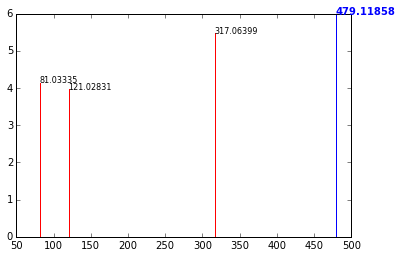

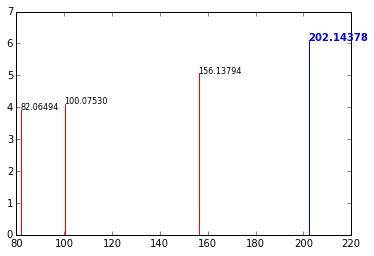

Topic 37

Parent peaks

     peakID	mz		rt		int		prob
1    5897 	162.09133	336.992		4.985e+06	0.996
2    5899 	162.09133	305.834		1.665e+06	0.993
3    5896 	162.09132	377.378		4.903e+06	0.957
4    2229 	425.13602	241.536		4.185e+06	0.902
5    4839 	173.12850	374.230		5.343e+06	0.795
6    6085 	132.06554	435.357		2.628e+06	0.787
7    4842 	173.12852	406.488		4.160e+06	0.777
8    4840 	173.12850	300.895		2.972e+06	0.760
9    4841 	173.12851	333.702		3.698e+06	0.734

Fragments

1    fragment_60.04476 (0.034)
 peakID  MSnParentPeakID  mz         rt       intensity   
 16683   4839             60.044818  376.318  27303.105469
 16689   4840             60.044750  311.009   8328.958984
 16694   4841             60.044878  327.551  15189.791016
 18097   5899             60.044723  296.809   6627.529297
2    fragment_144.08074 (0.026)
 peakID  MSnParentPeakID  mz          rt       intensity   
 18065   5896             144.080774  376.427  1365107.1250
 18079   5897             144.080639  327.

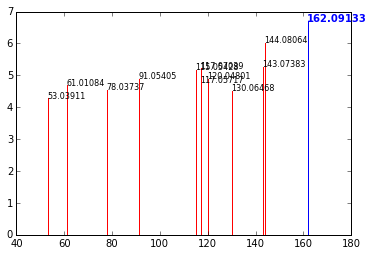

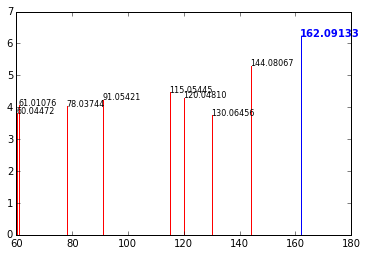

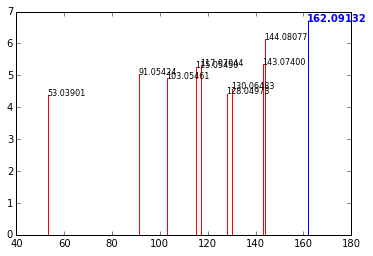

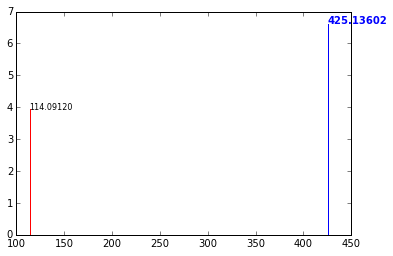

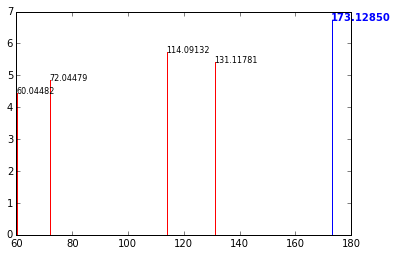

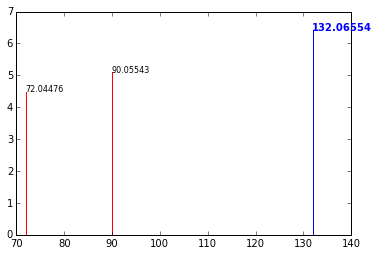

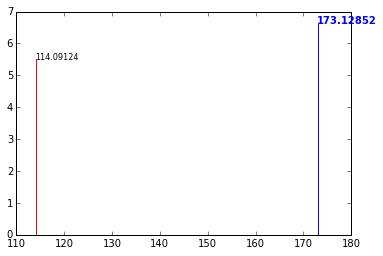

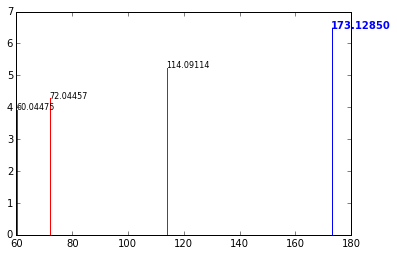

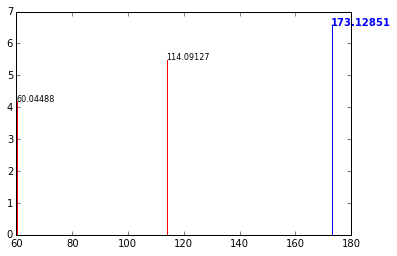

Topic 38

Parent peaks

     peakID	mz		rt		int		prob
1    2432 	264.08993	274.685		1.072e+06	0.945
2    7060 	190.10734	328.784		5.665e+06	0.874
3    6377 	198.11249	459.215		1.452e+06	0.870
4    2716 	321.14790	286.004		1.516e+06	0.814
5    3517 	515.41312	223.606		1.255e+07	0.804
6    7061 	190.10737	416.080		5.417e+06	0.800
7    7063 	190.10733	387.071		2.743e+06	0.732
8    6291 	186.07611	441.780		1.643e+06	0.718
9    8266 	191.10254	598.691		1.518e+07	0.556

Fragments

1    fragment_144.10184 (0.025)
 peakID  MSnParentPeakID  mz        rt       intensity
 19969   7060             144.1019  324.176  383642.50
 19973   7061             144.1021  405.531   61936.46
 20001   7063             144.1018  389.231  146233.60
2    fragment_60.04476 (0.017)
 peakID  MSnParentPeakID  mz        rt       intensity
 19985   7061             60.04432  405.531   6537.277
 20013   7063             60.04480  389.231  13178.990
3    fragment_126.05565 (0.015)
 peakID  MSnParentPeakID  mz          rt

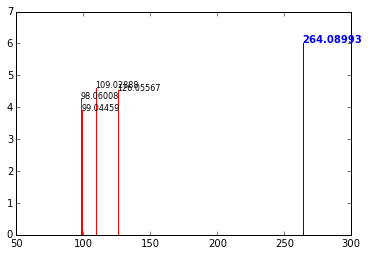

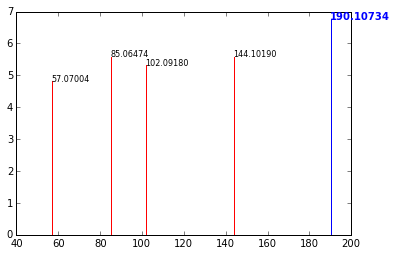

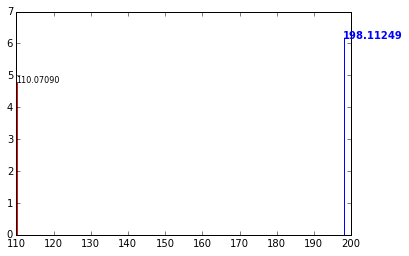

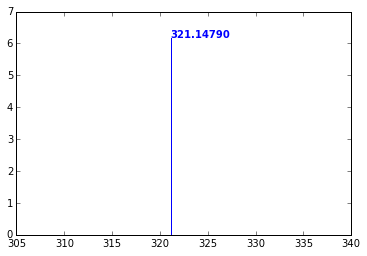

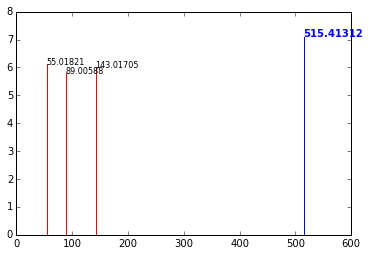

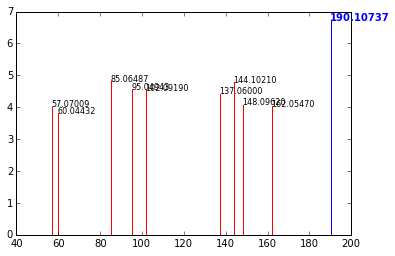

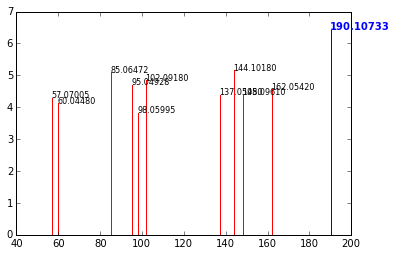

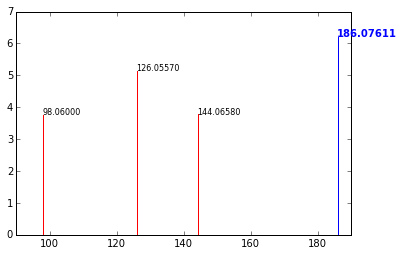

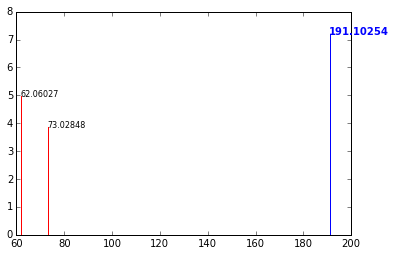

Topic 39

Parent peaks

     peakID	mz		rt		int		prob
1    5559 	271.08110	349.996		8.397e+05	0.809
2    4624 	276.12295	266.414		6.335e+05	0.687
3    3661 	237.14843	216.950		6.623e+05	0.662
4    9548 	260.15478	754.395		7.278e+05	0.568
5    6781 	180.10187	273.033		1.428e+07	0.555
6    4305 	149.02337	239.890		1.390e+06	0.460
7    6397 	146.08117	471.593		6.029e+06	0.433
8    8246 	217.06824	619.436		1.134e+06	0.405
9    6779 	180.10186	369.407		1.026e+07	0.317

Fragments

1    fragment_112.07583 (0.040)
 peakID  MSnParentPeakID  mz        rt       intensity 
 19501   6781             112.0759  271.668  344835.200
 21898   8246             112.0758  616.996    5262.199
2    fragment_65.03877 (0.028)
 peakID  MSnParentPeakID  mz         rt       intensity   
 15721   3661             65.038775  215.197   6997.137207
 16135   4305             65.038877  232.963  24829.335938
 17379   5559             65.038725  360.646   6662.404785
3    fragment_138.09146 (0.023)
 peakID  MSnParentPea

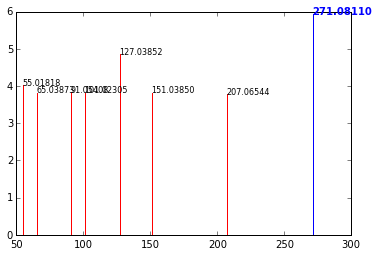

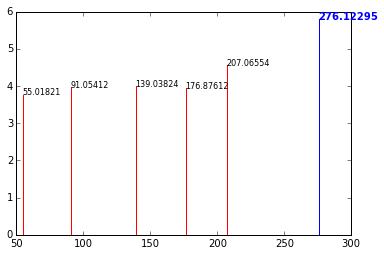

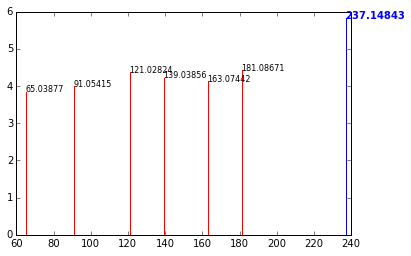

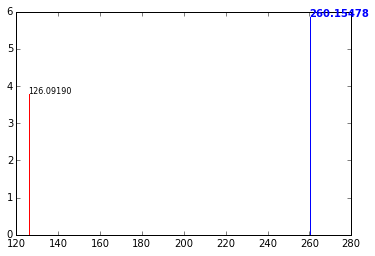

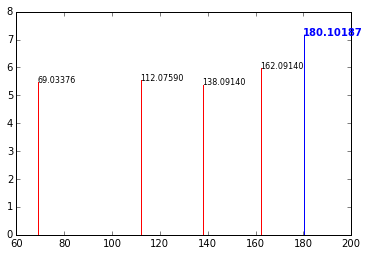

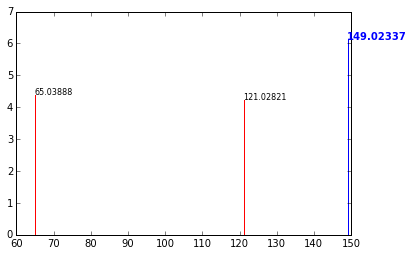

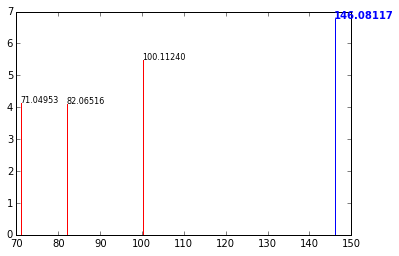

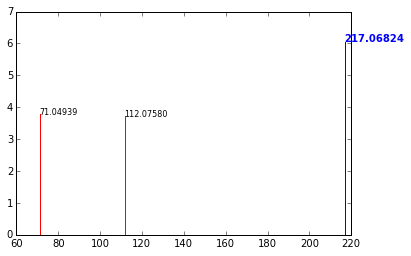

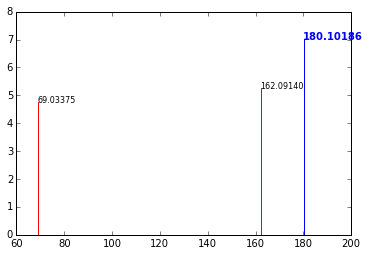

Topic 40

Parent peaks

     peakID	mz		rt		int		prob
1    8012 	295.11348	589.081		8.320e+06	0.921
2    6546 	247.09232	502.727		9.222e+05	0.899
3    8162 	457.16641	613.130		7.006e+05	0.874
4    4087 	184.06051	362.957		4.007e+05	0.804
5    4086 	184.06046	266.414		7.590e+06	0.794
6    6579 	244.08150	502.727		2.463e+06	0.629
7    4402 	287.22154	229.964		3.431e+06	0.571
8    7225 	304.24822	229.964		7.227e+06	0.398
9    7249 	372.18873	541.633		1.201e+06	0.371

Fragments

1    fragment_69.03368 (0.038)
 peakID  MSnParentPeakID  mz        rt       intensity
 19253   6546             69.03372  503.359  19991.330
 19265   6579             69.03366  509.417   8169.144
 20559   7249             69.03362  539.204   9460.348
 21589   8012             69.03358  589.355  99417.890
 21833   8162             69.03370  614.576  24666.770
2    fragment_84.04487 (0.035)
 peakID  MSnParentPeakID  mz         rt       intensity  
 16312   4402             84.044897  240.164  8406.499023
3    fragmen

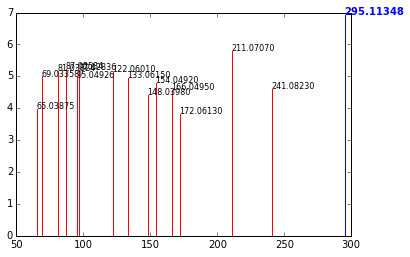

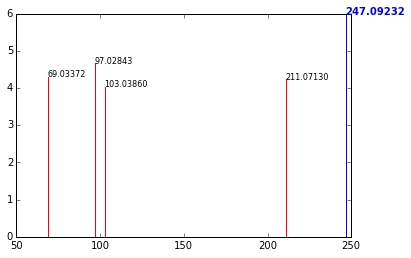

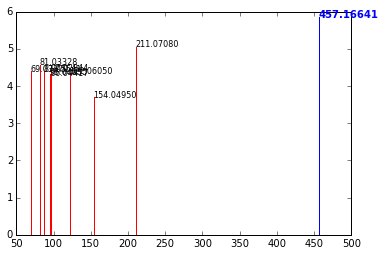

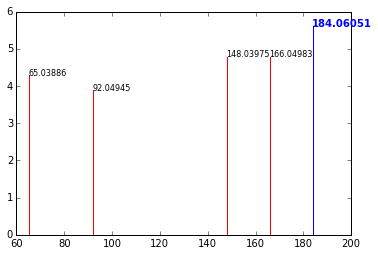

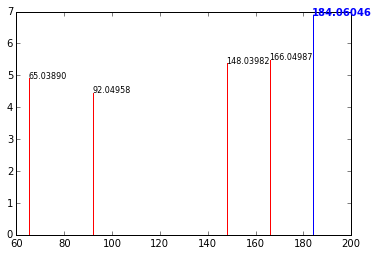

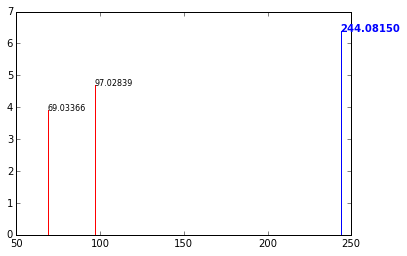

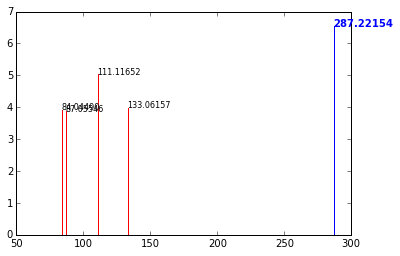

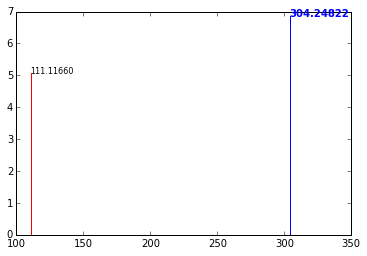

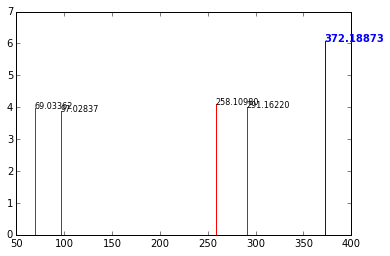

Topic 41

Parent peaks

     peakID	mz		rt		int		prob
1    1376 	354.19100	243.181		9.973e+05	0.997
2    2254 	340.17556	254.771		5.694e+05	0.997
3    1674 	382.22217	231.552		6.558e+05	0.996
4    1168 	366.19963	224.227		5.821e+05	0.995
5    1733 	398.21725	231.552		3.862e+05	0.987
6    1569 	367.21161	212.026		1.617e+06	0.977
7    4375 	220.11798	374.230		2.018e+06	0.918
8    1018 	387.15665	208.697		8.009e+06	0.900
9    3397 	349.20080	210.369		4.867e+07	0.881

Fragments

1    fragment_91.05413 (0.019)
 peakID  MSnParentPeakID  mz         rt       intensity    
 13335   1168             91.054109  211.483   43397.925781
 13441   1376             91.054248  240.715   32612.078125
 13660   1569             91.054097  220.851    6773.506348
 13691   1674             91.054179  229.059   18043.933594
 14127   2254             91.054010  252.859   19300.445312
 15404   3397             91.054056  215.595  244172.187500
2    fragment_79.05417 (0.016)
 peakID  MSnParentPeakID  mz         r

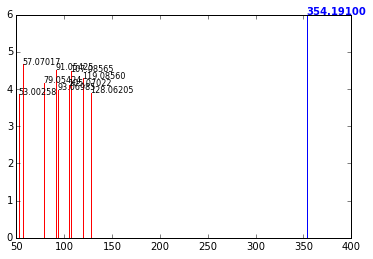

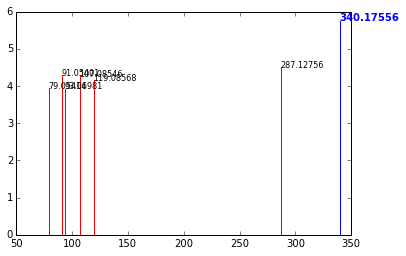

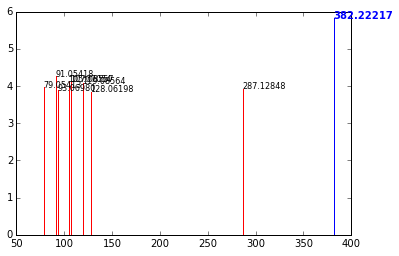

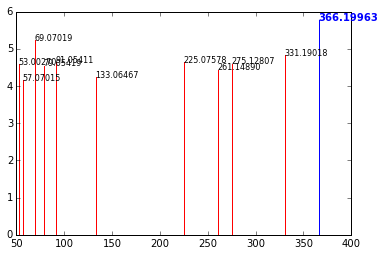

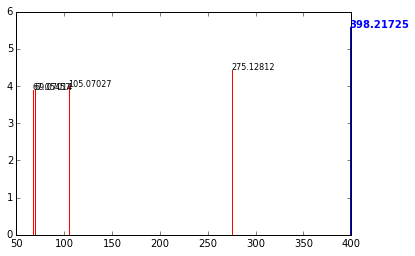

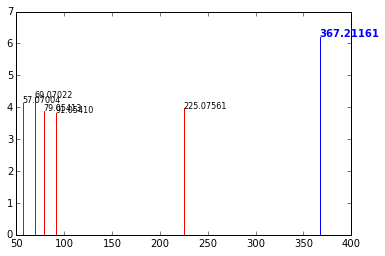

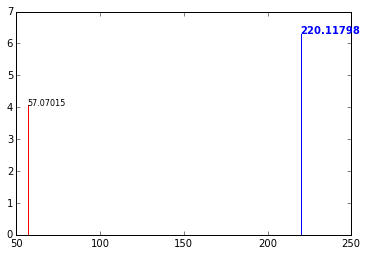

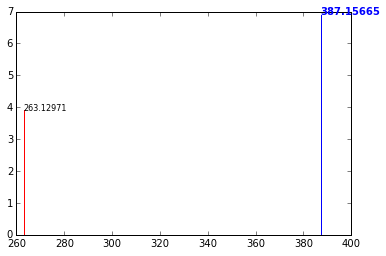

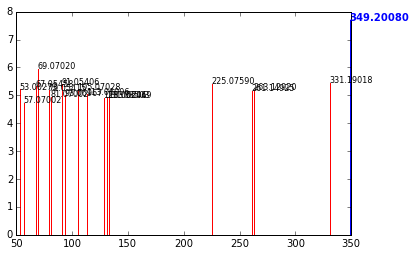

Topic 42

Parent peaks

     peakID	mz		rt		int		prob
1    3743 	532.43947	223.606		6.335e+07	0.980
2    5953 	150.07745	438.661		1.751e+07	0.923
3    7510 	487.17874	559.317		1.266e+06	0.881
4    8968 	282.11955	657.338		5.294e+06	0.879
5    10952	255.09736	1076.090		1.333e+06	0.812
6    6457 	344.09753	491.538		7.625e+05	0.776
7    4158 	228.12308	263.096		5.307e+05	0.721
8    2652 	560.47099	223.606		6.039e+06	0.648
9    5699 	210.11246	244.833		8.170e+05	0.628

Fragments

1    fragment_80.04949 (0.092)
 peakID  MSnParentPeakID  mz         rt        intensity    
 16013    4158            80.049475   262.142    7278.554688
 17764    5699            80.049547   242.217   60244.566406
 18141    5953            80.049485   445.091   57399.175781
 19081    6457            80.049420   489.766  223665.500000
 24891   10952            80.049540  1078.540   58031.200000
2    fragment_53.03889 (0.030)
 peakID  MSnParentPeakID  mz         rt       intensity   
 17775   5699             53.038

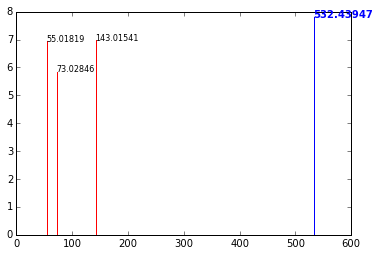

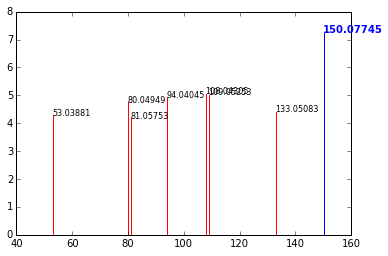

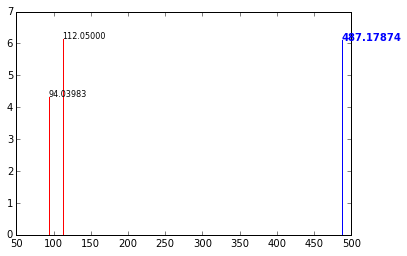

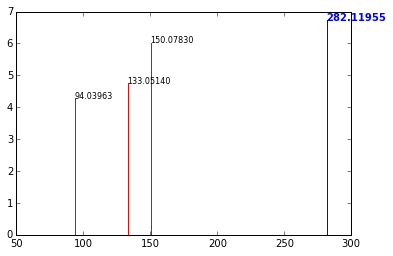

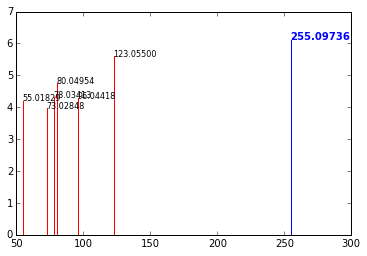

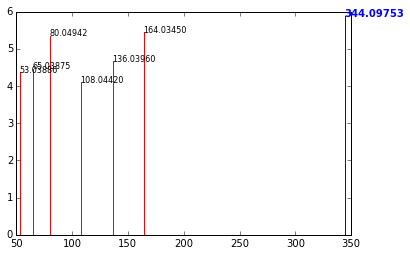

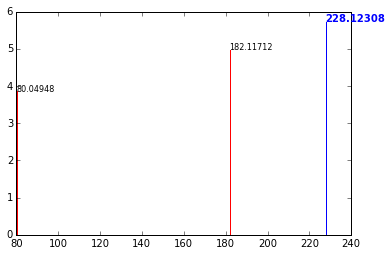

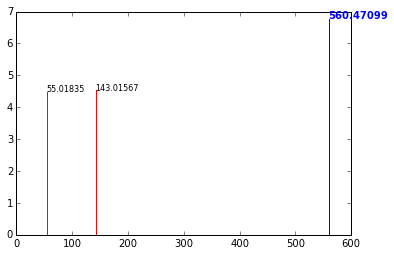

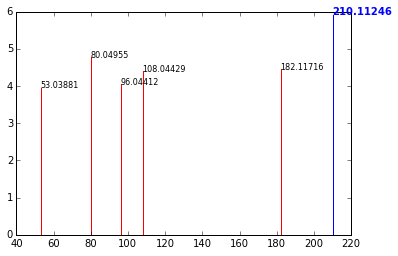

Topic 43

Parent peaks

     peakID	mz		rt		int		prob
1    12752	265.15453	1145.810		4.082e+05	0.982
2    8702 	498.26006	619.436		2.220e+06	0.952
3    2650 	540.27088	263.096		5.566e+06	0.932
4    2287 	540.33066	274.685		5.148e+05	0.909
5    8318 	323.17141	565.722		1.952e+06	0.896
6    3579 	369.11816	290.983		4.275e+05	0.804
7    8088 	307.17645	565.722		1.986e+06	0.751
8    8204 	307.09988	614.695		1.755e+06	0.591
9    2574 	246.11238	264.755		4.201e+05	0.247

Fragments

1    fragment_89.03862 (0.039)
 peakID  MSnParentPeakID  mz         rt        intensity    
 14158    2287            89.038674   274.145  333513.281250
 14723    2650            89.038643   271.813  459883.218750
 15623    3579            89.038588   292.200   89281.671875
 21798    8088            89.038580   573.652  147716.100000
 21855    8204            89.038590   612.455   91483.410000
 21964    8318            89.038600   558.501  218118.100000
 22512    8702            89.038520   626.697  345589.500000


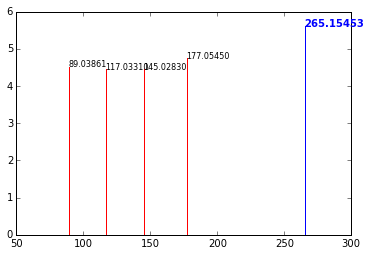

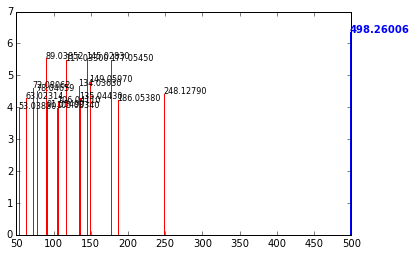

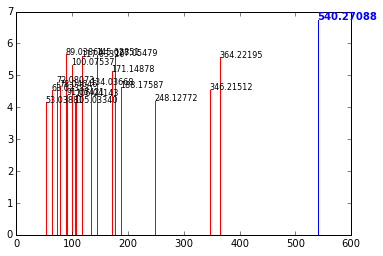

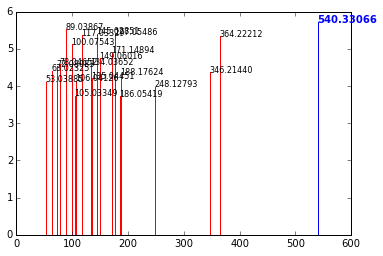

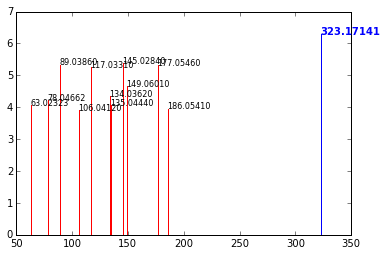

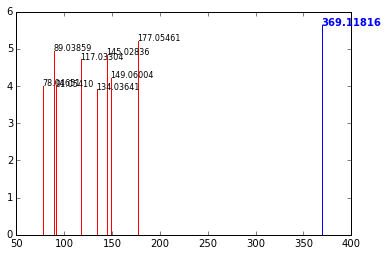

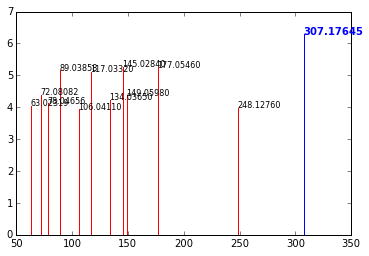

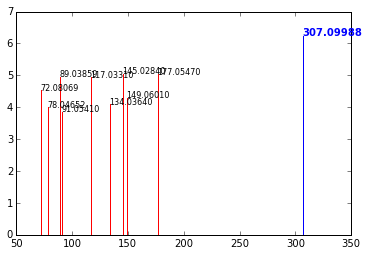

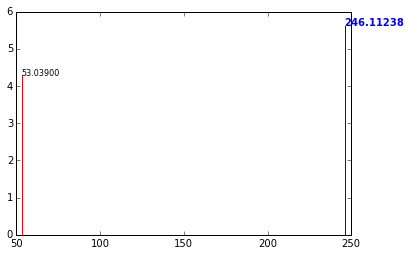

Topic 44

Parent peaks

     peakID	mz		rt		int		prob
1    9996 	309.16551	711.245		7.023e+06	0.774
2    9508 	295.14995	687.048		1.306e+06	0.745
3    9663 	337.17161	710.377		1.150e+07	0.703
4    8917 	457.20278	672.871		3.506e+05	0.690
5    7908 	318.12953	570.233		4.967e+06	0.663
6    9997 	309.16551	736.276		4.482e+05	0.661
7    8071 	480.18242	598.691		1.895e+06	0.535
8    7756 	440.17634	568.665		1.129e+06	0.526
9    9664 	337.17170	736.276		9.892e+05	0.450

Fragments

1    fragment_81.03337 (0.045)
 peakID  MSnParentPeakID  mz        rt       intensity 
 21131   7756             81.03333  566.872    9354.040
 21448   7908             81.03331  572.032  174663.300
 21770   8071             81.03340  595.108   62717.400
 23406   9663             81.03401  710.653   34753.780
 23699   9997             81.03334  735.693    7120.542
2    fragment_128.07032 (0.042)
 peakID  MSnParentPeakID  mz        rt       intensity
 21126   7756             128.0704  566.872  37511.15 
 23400   96

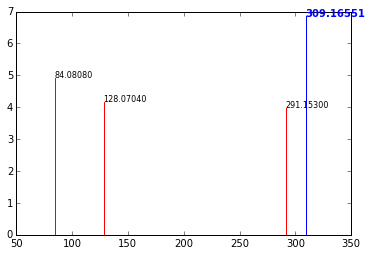

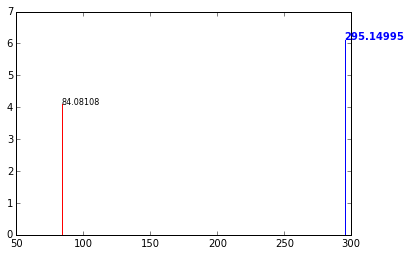

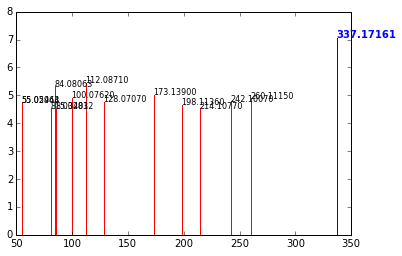

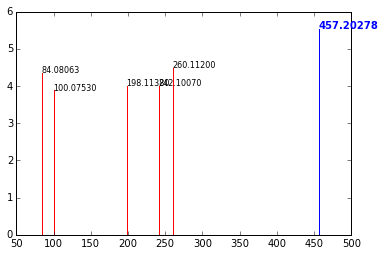

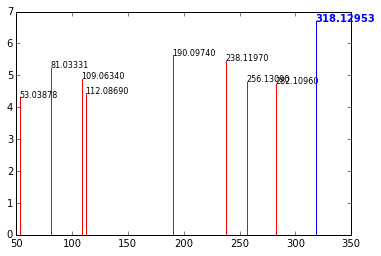

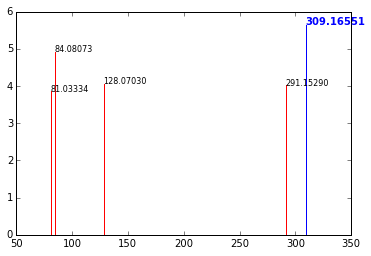

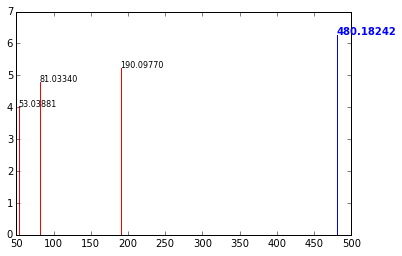

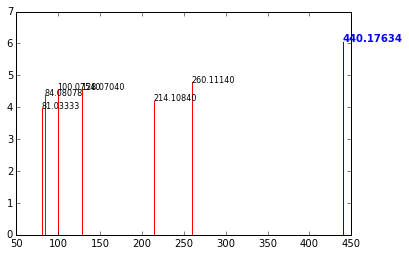

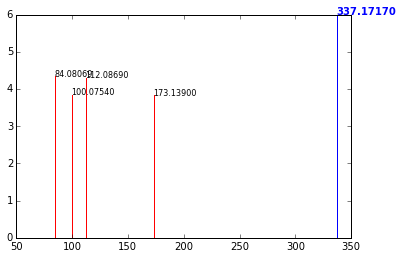

Topic 45

Parent peaks

     peakID	mz		rt		int		prob
1    781  	327.19533	208.697		7.372e+05	0.916
2    6521 	302.12098	501.043		2.892e+06	0.885
3    1386 	394.25876	208.697		5.095e+06	0.787
4    6657 	362.21650	502.727		6.763e+05	0.727
5    2338 	264.14408	241.536		1.020e+06	0.690
6    3625 	246.16992	244.833		5.421e+05	0.608
7    3297 	277.15831	299.240		7.832e+05	0.584
8    2978 	345.21336	294.270		6.040e+05	0.546
9    2726 	359.10373	286.004		7.618e+05	0.535

Fragments

1    fragment_110.07176 (0.041)
 peakID  MSnParentPeakID  mz          rt       intensity    
 15230   3297             110.071756  296.948  126824.101562
 19362   6657             110.071700  501.640   76164.800000
2    fragment_156.07692 (0.039)
 peakID  MSnParentPeakID  mz        rt      intensity
 19363   6657             156.0766  501.64  32188.6  
3    fragment_143.11762 (0.037)
 peakID  MSnParentPeakID  mz          rt       intensity   
 15088   2978             143.117671  294.002  35589.714844
 15234   3297

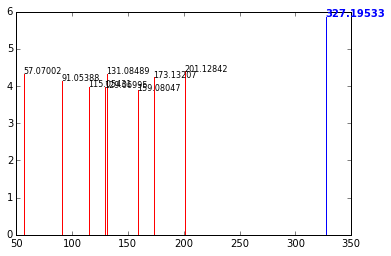

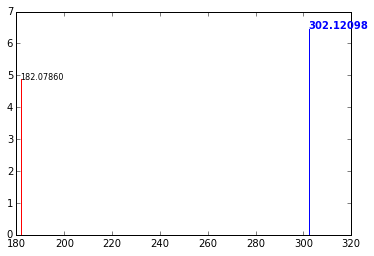

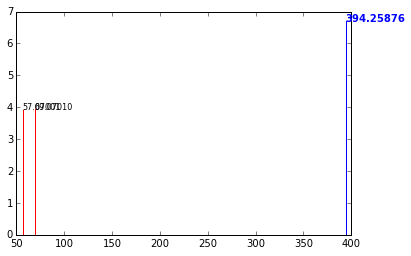

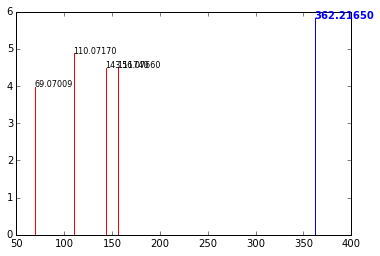

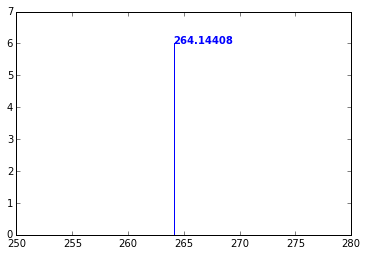

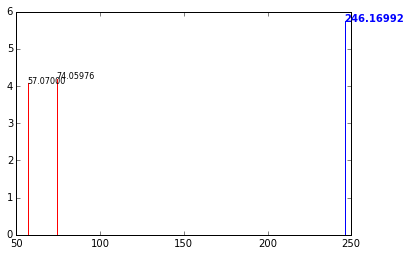

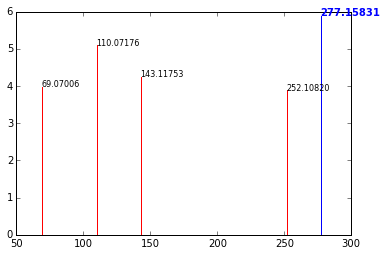

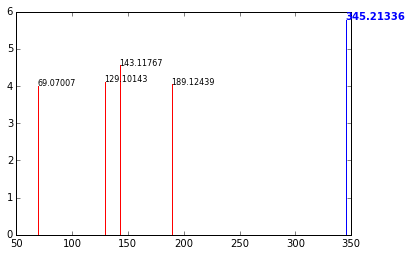

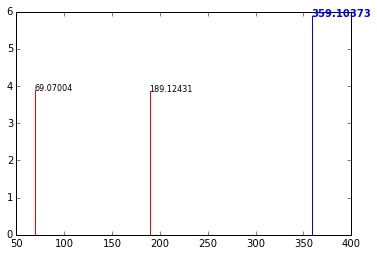

Topic 46

Parent peaks

     peakID	mz		rt		int		prob
1    7684 	274.09193	536.439		3.015e+07	0.962
2    1555 	324.21702	220.295		4.010e+05	0.911
3    7094 	465.10293	513.775		9.155e+05	0.855
4    8342 	268.10247	597.184		7.357e+06	0.706
5    8884 	220.08152	624.196		4.409e+06	0.696
6    8653 	238.09200	624.196		3.603e+06	0.335
7    8627 	234.09720	641.423		6.665e+05	0.303
8    7694 	402.15072	560.934		9.338e+05	0.264
9    6441 	370.16089	491.538		9.673e+05	0.223

Fragments

1    fragment_97.02839 (0.016)
 peakID  MSnParentPeakID  mz        rt       intensity 
 19038   6441             97.02837  489.075    15348.14
 20160   7094             97.02852  509.774    16686.51
 20919   7684             97.02836  534.323  2126861.00
 20957   7694             97.02829  557.139    25873.03
 22003   8342             97.02840  604.480    15961.70
 22431   8627             97.02846  642.333    15622.85
 22475   8653             97.02839  620.188    67284.66
 22748   8884             97.02849  619.1

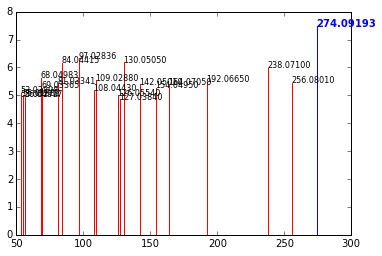

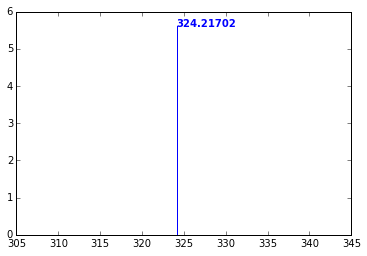

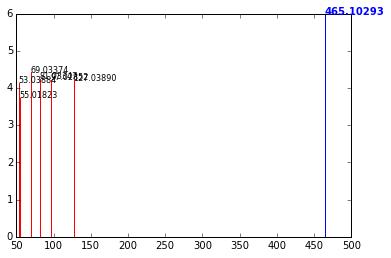

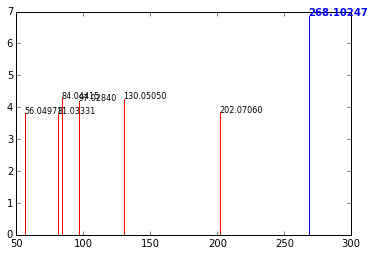

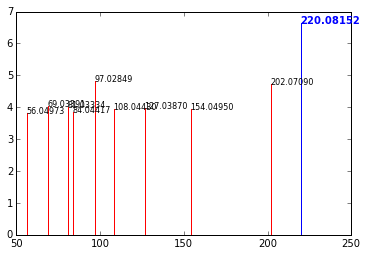

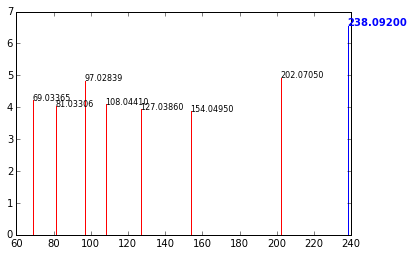

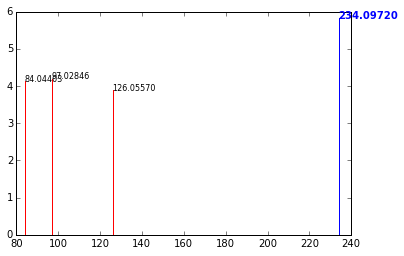

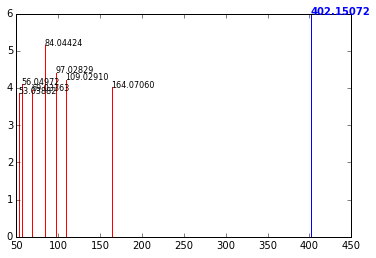

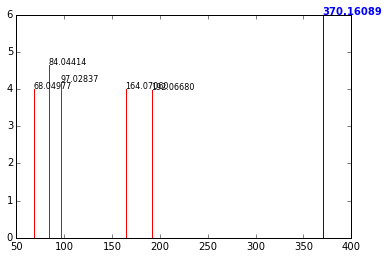

Topic 47

Parent peaks

     peakID	mz		rt		int		prob
1    3343 	338.34169	233.227		1.835e+06	0.991
2    1499 	277.21609	246.483		5.033e+05	0.990
3    2103 	331.24799	251.436		8.954e+05	0.979
4    2429 	257.04205	241.536		2.261e+06	0.960
5    2149 	291.26812	238.237		5.693e+05	0.952
6    906  	339.25308	216.950		1.582e+06	0.948
7    1828 	311.13680	254.771		6.126e+05	0.937
8    2622 	346.25883	253.125		1.561e+06	0.922
9    1987 	333.26348	246.483		6.679e+05	0.915

Fragments

1    fragment_67.05455 (0.053)
 peakID  MSnParentPeakID  mz         rt       intensity    
 13100    906             67.054667  214.917  162201.000000
 13542   1499             67.054537  246.078   14475.365234
 13802   1828             67.054620  254.370   19054.472656
 13923   1987             67.054588  244.151   43701.730469
 13969   2103             67.054532  251.034   39978.015625
 14052   2149             67.054516  237.694   26215.876953
 14307   2429             67.054533  237.270    6632.678711
 14569   

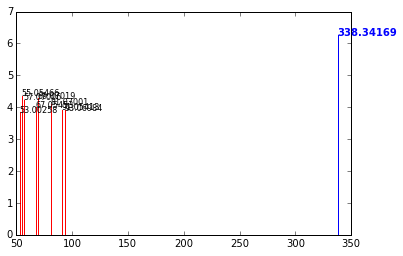

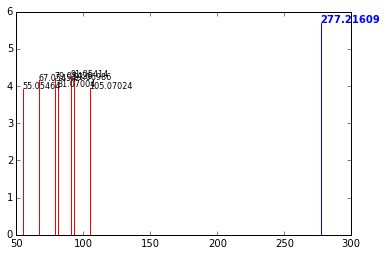

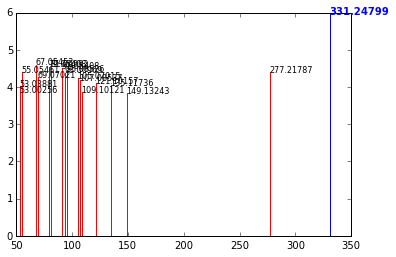

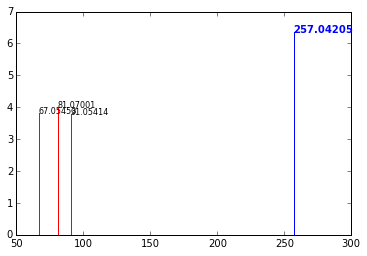

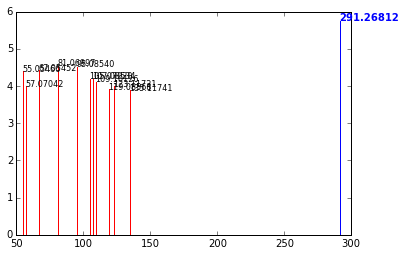

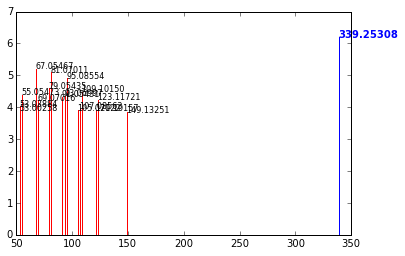

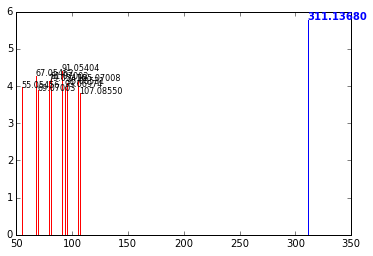

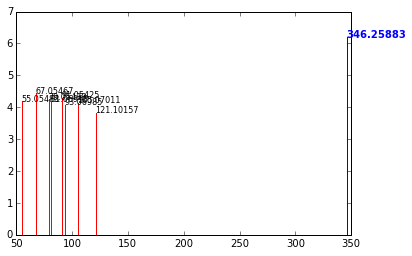

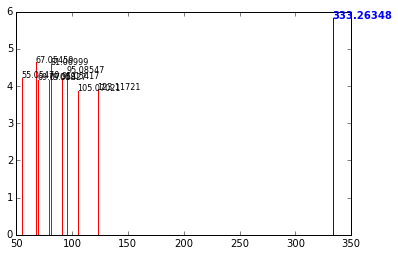

Topic 48

Parent peaks

     peakID	mz		rt		int		prob
1    5602 	254.10219	372.653		1.255e+06	0.730
2    5604 	254.10218	330.420		7.728e+05	0.557
3    5605 	254.10217	348.358		7.909e+05	0.542
4    6388 	240.12294	302.542		3.507e+05	0.482
5    7937 	138.05249	578.163		1.900e+07	0.457
6    6071 	180.06555	412.921		2.012e+06	0.380
7    5893 	140.07060	353.265		4.146e+05	0.368
8    6375 	198.11252	411.438		1.248e+07	0.350
9    6251 	196.09686	330.420		9.104e+05	0.349

Fragments

1    fragment_108.04426 (0.035)
 peakID  MSnParentPeakID  mz          rt       intensity    
 17517   5602             108.044350  375.337   17735.636719
 17597   5604             108.044258  326.053   11315.740234
 17637   5605             108.044191  358.932    9902.638672
 18404   6071             108.044300  413.560  167110.800000
 18930   6375             108.044300  402.194    6821.732000
 18987   6388             108.044200  303.508   27170.940000
2    fragment_94.06505 (0.033)
 peakID  MSnParentPeakID  mz  

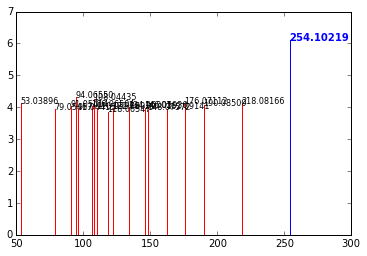

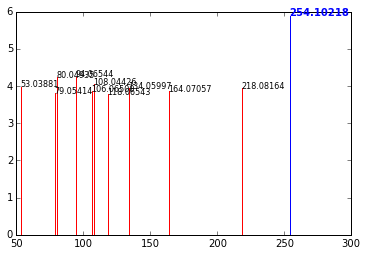

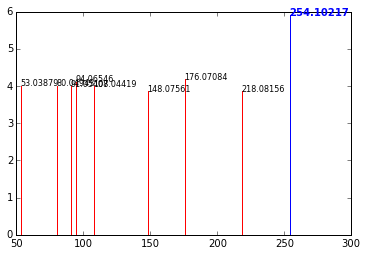

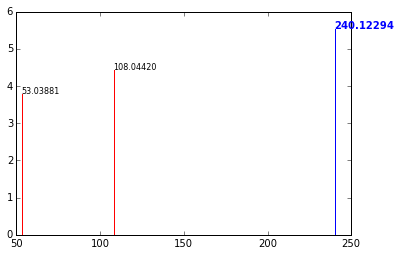

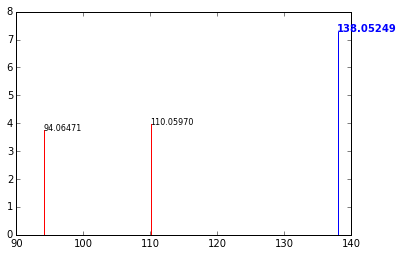

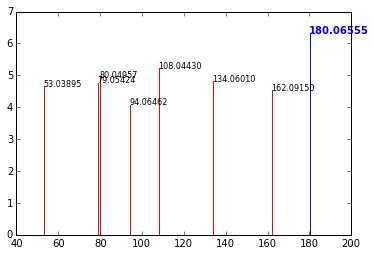

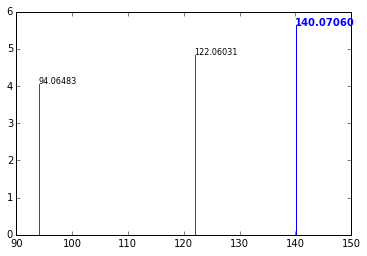

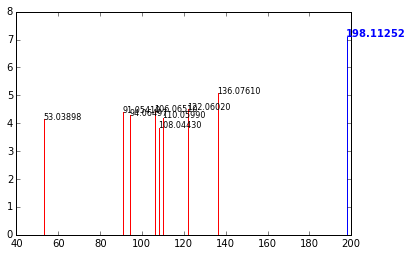

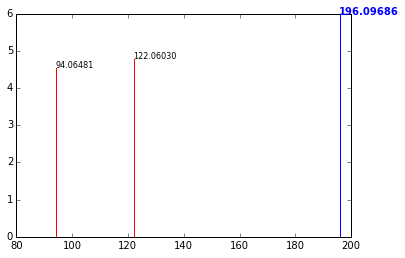

Topic 49

Parent peaks

     peakID	mz		rt		int		prob
1    7854 	229.15463	538.378		3.700e+06	0.989
2    7241 	236.16836	532.509		4.792e+07	0.977
3    7234 	352.24414	531.443		5.502e+06	0.958
4    7853 	229.15460	525.002		2.835e+06	0.917
5    5883 	341.06339	460.808		1.647e+06	0.912
6    5831 	325.08943	460.808		8.356e+05	0.909
7    5620 	366.09500	444.820		1.363e+06	0.908
8    10863	299.16084	955.415		3.168e+05	0.908
9    5093 	435.12642	310.690		2.610e+06	0.904

Fragments

1    fragment_70.06514 (0.606)
 peakID  MSnParentPeakID  mz         rt       intensity    
 16960    5093            70.065086  315.590   11913.002930
 17673    5620            70.065201  453.498   16938.136719
 18022    5831            70.065029  460.550   21301.902344
 18031    5883            70.065176  458.604   31252.203125
 21425    7853            70.065100  526.817  377738.700000
 21437    7854            70.065100  543.562  542131.000000
 24852   10863            70.065070  954.449   16230.990000
2    frag

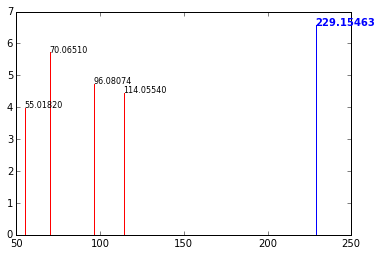

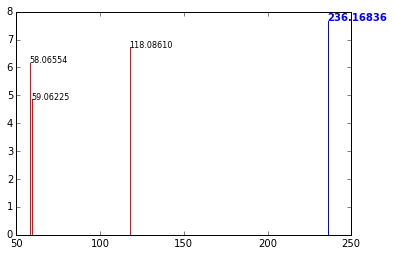

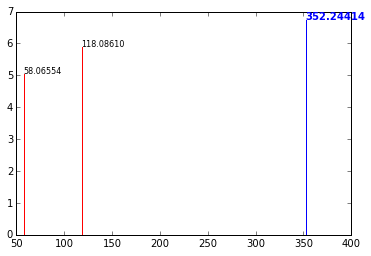

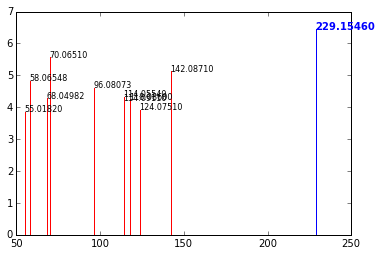

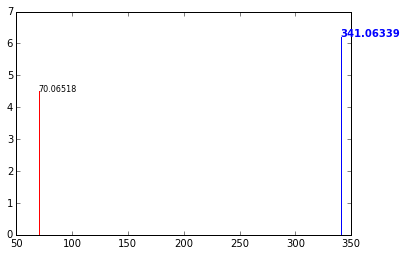

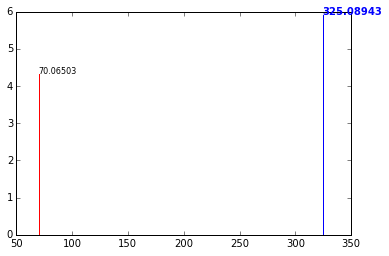

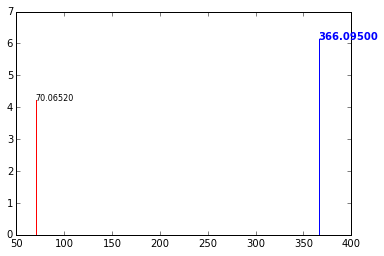

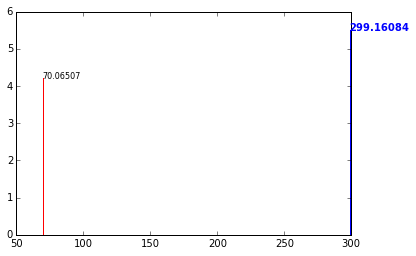

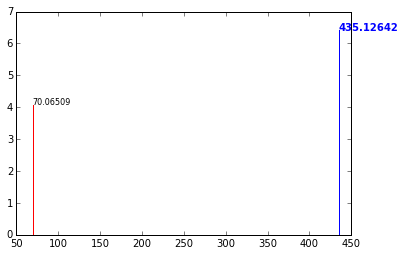

In [12]:
n_docs = 10
n_fragments = 20

topic_fragments = model.topic_word_
headers = list(docdf.columns.values)

ms2['bin_id'] = ms2['bin_id'].astype(str)

for i, topic_dist in enumerate(topic_fragments):
    
    print "Topic " + str(i)
    print "=========="
    print
        
    column_values = np.array(docdf.columns.values)    
    doc_dist = docdf.iloc[[i]].as_matrix().flatten()
    idx = np.argsort(doc_dist)[::-1] # argsort in descending order
    topic_d = np.array(column_values)[idx]
    topic_p = np.array(doc_dist)[idx]
    top_n_docs = topic_d[1:n_docs]
    top_n_docs_p = topic_p[1:n_docs]
        
    print "Parent peaks"
    print
    print '     %s\t%s\t\t%s\t\t%s\t\t%s' % ('peakID', 'mz', 'rt', 'int', 'prob')
    parent_ids = []
    parent_masses = []
    parent_intensities = []
    count = 1
    for t in zip(top_n_docs, top_n_docs_p):

        # split mz_rt_peakid string into tokens
        tokens = t[0].split('_')
        peakid = int(tokens[2])
        ms1_row = ms1.loc[[peakid]]
        mz = ms1_row[['mz']]
        mz = np.asscalar(mz.values)
        rt = ms1_row[['rt']]
        rt = np.asscalar(rt.values)
        intensity = ms1_row[['intensity']]
        intensity = np.asscalar(intensity.values)
        prob = t[1]
        
        print '%-5d%-5d\t%.5f\t%.3f\t\t%.3e\t%.3f' % (count, peakid, mz, rt, intensity, prob)
        parent_ids.append(peakid)
        parent_masses.append(mz)
        parent_intensities.append(intensity)

        count += 1

    column_values = np.array(data.columns.values)
    idx = np.argsort(topic_dist)[::-1] # argsort in descending order
    topic_w = np.array(column_values)[idx]
    topic_p = np.array(topic_dist)[idx]    
    fragments = []
    fragments_p = []
    others = []
    others_p = []
    for w, p in zip(topic_w, topic_p):
        if len(fragments) > n_fragments:
            break
        if w.startswith('fragment'):
            fragments.append(w)
            fragments_p.append(p)
        else:
            others.append(w)
            others_p.append(p)

    print
    print "Fragments"
    print
    parent_fragments = {}
    count = 1
    for t in zip(fragments, fragments_p):
        
        fragment = t[0]
        tokens = fragment.split('_')
        bin_id = tokens[1]
        bin_prob = t[1]
        ms2_rows = ms2.loc[ms2['bin_id']==bin_id]
        ms2_rows = ms2_rows.loc[ms2_rows['MSnParentPeakID'].isin(parent_ids)]

        print '%-5d%s (%.3f)' % (count, t[0], t[1])
        print ms2_rows[['peakID', 'MSnParentPeakID', 'mz', 'rt', 'intensity']].to_string(index=False, justify='left')
        
        count += 1

        peakids = ms2_rows[['peakID']]
        mzs = ms2_rows[['mz']]
        intensities = ms2_rows[['intensity']]
        parentids = ms2_rows[['MSnParentPeakID']]
        
        # convert from pandas dataframes to list
        peakids = peakids.values.ravel().tolist()
        mzs = mzs.values.ravel().tolist()
        intensities = intensities.values.ravel().tolist()
        parentids = parentids.values.ravel().tolist()
        
        for n in range(len(parentids)):
            parentid = parentids[n]
            mz = mzs[n]
            intensity = intensities[n]
            peakid = peakids[n]
            item = (peakid, parentid, mz, intensity)
            if parentid in parent_fragments:
                existing_list = parent_fragments[parentid]
                existing_list.append(item)
            else:
                new_list = [item]
                parent_fragments[parentid] = new_list

    print
    print "Others"
    print "\n".join(' - %-15s\t%.3f' % t for t in zip(others, others_p))
    print

    # plot the n_docs parent peaks in this topic
    parent_fontspec = {
        'size':'10', 
        'color':'blue', 
        'weight':'bold'
    }
    fragment_fontspec = {
        'size':'8', 
        'color':'black', 
        'weight':'normal'
    }
    num_peaks = len(parent_ids)
    for i in range(num_peaks):
        
        plt.figure()
        
        # plot the parent peak
        mass = parent_masses[i]
        intensity = np.log10(parent_intensities[i])
        plt.plot((mass, mass), (0, intensity), 'b')
        x = mass
        y = intensity
        parent_id = parent_ids[i]
        label = "%.5f" % mass
        plt.text(x, y, label, **parent_fontspec)   
        
        # plot the n_fragments fragment peaks in this topic that also occur in the parent peaks above
        if parent_id in parent_fragments:        
            fragments_list = parent_fragments[parent_id]
            num_peaks = len(fragments_list)
            for j in range(num_peaks):
                item = fragments_list[j]
                peakid = item[0]
                parentid = item[1]
                mass = item[2]
                intensity = np.log10(item[3])
                plt.plot((mass, mass), (0, intensity), 'r')
                x = mass
                y = intensity
                label = "%.5f" % mass
                plt.text(x, y, label, **fragment_fontspec)        
    
        plt.show()

5. No. of Topics
-------------------

Compute the held-out perplexity on the testing set and plot as the no. of topics is increased ..